# <center>BoardGameGeek Exploratory Data Analysis</center>

## 1. Introduction <a id="introduction"></a>

Board games have experienced a resurgence in recent years, fascinating players of all ages with their intricate designs, strategic depth, and immersive experiences. With thousands of games released annually, BoardGameGeek (BGG) stands as the definitive hub where players can discover, discuss, and review board games of all genres and complexities. As such, BGG contains an extensive database that could provide insights on the current landscape of board gaming industry.

This notebook focuses on exploring the BGG dataset, which includes information on game mechanics, categories, ratings, etc. The analysis aims to uncover trends, patterns, and correlations between features that would help facilitate a comprehensive understanding of the data. The data was obtained using the BGG API where 150,000+ board games were collected and stored in an S3 bucket. 

### 1.1 Business Questions <a id="business_questions"></a>

The EDA aims to investigate the following questions regarding the dataset:

1. What is the **overall distribution of the features**, and which values occur most frequently for each?
2. What **recent trends** have emerged in board games concerning average rating, complexity, and the adoption of mechanics and categories?
3. How does each feature contribute to the **overall rating** of a board game?

---
## 2. Table of Contents <a id="table_of_contents"></a>

[1. Introduction](#introduction)
* [1.1 Business Questions](#business_questions)

[2. Table of Contents](#table_of_contents)

[3. Declarations](#declarations)
* [3.1 Libraries](#libraries)
* [3.2 Environment Variables](#environment_variables)
* [3.3 Function Definition](#function_definition)

[4. Data Collection](#data_collection)

[5. Data Wrangling](#data_wrangling)
* [5.1 Features](#features)
* [5.2 Mechanics and Cateogries](#mechanics_and_categories)
* [5.3 Poll](#poll)
* [5.4 Categorical and Numerical Columns](#categorical_and_numerical)

[6. Univariate Analysis](#univariate_analysis)
* [6.1 Categorical Attributes](#categorical_attributes)
    * [6.1.1 Subdomain](#subdomain)
    * [6.1.2 Mechanics](#mechanics)
    * [6.1.3 Categories](#categories)
    * [6.1.4 Families](#families)
    * [6.1.5 Best No. of Players](#best_no_players)
    * [6.1.6 Recommended Player Age](#recommended_player_age)
* [6.2 Numerical Attributes](#numerical_attributes)
    * [6.2.1 Ranked Games](#ranked_games)
    * [6.2.2 Year Published (1900-2023)](#year_published)
    * [6.2.3 Minimum Age](#minimum_age)
    * [6.2,4 Minimum Playing Time](#minimum_playing_time)
    * [6.2.5 No. of User Ratings](#no_of_user_ratings)
    * [6.2.6 Average Rating](#average_rating)
    * [6.2.7 Geek Rating](#geek_rating)
    * [6.2.8 No. of Weight Ratings](#no_weight_ratings)
    * [6.2.9 Weight/Complexity](#weight)
    * [6.2.10 No. of Owners](#no_owners)
    
[7. Bivariate Analysis](#bivariate_analysis)
* [7.1 Board Game Trends](#board_game_trends)
    * [7.1.1 BGG Rank](#bgg_rank)
    * [7.1.2 Average Rating](#average_rating_bivariate)
    * [7.1.3 Weight](#weight_bivariate)
    * [7.1.4 No. of Mechanics](#no_mechanics_bivariate)
    * [7.1.5 No. of Categories](#no_categories_bivariate)
    * [7.1.6 Mechanics Adoption](#mechanics_adoption)
    * [7.1.7 Categories Adoption](#categories_adoption)
* [7.2 Target Feature](#target_feature)
    * [7.2.1 Data Filter](#data_filter)
* [7.3 Feature Correlations](#feature_correlations)
* [7.4 Features vs Target Feature](#features_vs_target)
    * [7.4.1 Weight](#weight_target_bivariate)
    * [7.4.2 No. of Owners](#no_owners_bivariate)
    * [7.4.3 Minimum Age](#minimum_age_bivariate)
    * [7.4.4 Minimum Players](#minimum_players_bivariate)
    * [7.4.5 No. of Mechanics](#no_of_mechanics_bivariate)
    * [7.4.6 Average Rating of Mechanics](#rating_mechanics_bivariate)
    * [7.4.7 Change in Rating due to Incorporation of Mechanics](#change_rating_mechanics_bivariate)
    * [7.4.8 Average Rating of Categories](#rating_categories_bivariate)
    * [7.4.9 Change in Rating due to Incorporation of Categories](#change_rating_categories_bivariate) 
    
[8. Multivariate Analysis](#multivariate_analysis)
* [8.1 Average Ratings vs (Geek Rating, Number of Ratings)](#geek_number_multivariate)
* [8.2 Average Ratings vs (Weight, Number of Ratings)](#weight_number_multivariate)
* [8.3 Average Rating vs (Weight, Year Published)](#weight_year_multivariate)
* [8.4 Average Ratings vs (Mechanics, Categories)](#mechanics_categories_multivariate)

[9. Conclusion](#conclusion)

---
## 3. Declarations <a id="declarations"></a>

### 3.1 Libraries <a id="libraries"></a>

In [2]:
import os
import time
from io import BytesIO
from datetime import timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import boto3
from dotenv import load_dotenv
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

### 3.2 Environment Variables <a id="environment_variables"></a>

In [2]:
load_dotenv()
access_key = os.getenv("AWS_ACCESS_KEY")
secret_key = os.getenv("AWS_SECRET_KEY")
aws_region = os.getenv("AWS_REGION")
role_arn = os.getenv("AWS_ROLE_ARN")

athena_output_directory = os.getenv("ATHENA_OUTPUT_DIRECTORY")
athena_database = os.getenv("ATHENA_DATABASE")

### 3.3 Function Definition <a id="function_definition"></a>

In [3]:
def initialize_aws_role(access_key, secret_key, aws_region, role_arn):
    """Initializes AWS user and role.
    
    Parameters:
        access_key {string} -- an ID of unique identifier to authenticate requests to AWS.
        secret_key {string} -- a digital signature for API requests made to AWS. 
        aws_region {string} -- location of AWS resources.
        role_arn {string} -- unique identifier for an IAM role to grant permission to AWS resources.
        
    Returns:
        {dict} -- contains response to a successful IAM role requests granting temporary permissions to AWS services \
        including the AWS user granted with such permission and the expiration time of the rewarded token.
    """
    try:
        sts_client = boto3.client(
            'sts',
            aws_access_key_id = access_key,
            aws_secret_access_key= secret_key,
            region_name = aws_region,
        )

        assumed_role = sts_client.assume_role(
            RoleArn=role_arn,
            RoleSessionName='BGGRoleSession',
            DurationSeconds=7200,
        )

        aws_user = sts_client.get_caller_identity()['Arn'].split("/")[-1]
        aws_role = assumed_role['AssumedRoleUser']['Arn'].split("/")[-2]
        token_expiration = assumed_role['Credentials']['Expiration'] + timedelta(hours=8)

        print(f"AWS user '{aws_user}' assigned with role '{aws_role}'.")
        print(f"Token expiration time: {token_expiration.strftime('%I:%M %p %d-%b-%Y')}")
        
        return assumed_role
    
    except Exception as e:
        print(f"Error initializing AWS: {e}")
        raise

In [4]:
def initilize_aws_service(aws_service, assumed_role):
    """Initializes an AWS service client.
    
    Parameters:
        aws_service {string} -- AWS service that needs client session initialization.
        assumed_role {dict} -- contains the temporary security credentials granted to a specific AWS user.
    
    Returns:
        {client_instance} -- can be used to call API requests to the corresponding AWS service client.
    """
    
    try:
        client = boto3.client(
            aws_service,
            aws_access_key_id=assumed_role['Credentials']['AccessKeyId'],
            aws_secret_access_key=assumed_role['Credentials']['SecretAccessKey'],
            aws_session_token=assumed_role['Credentials']['SessionToken']
        )
        print(f"{aws_service} successfully initilized.")

        return client

    except Exception as e:

        print(f"Error initializing {aws_service}: {e}")
        raise    

In [5]:
def athena_query_df(athena_query, athena_client, s3_client):
    """Send a query to AWS Athena and return the results in a pandas dataframe format.
    
    Parameters:
        athena_query {string} -- the query to run in AWS Athena using an SQL like syntax.
        athena_client {client_instance} -- initialized client of AWS Athena that permits API requests.
        s3_client {client_instance} -- initialized client of AWS S3 that permits API requests.
    
    Returns:
        {dataframe} -- table containing the results of the Athena query.
    """
    
    query_response = athena_client.start_query_execution(
        QueryString=athena_query,
        QueryExecutionContext = {"Database": athena_database},
        ResultConfiguration={
            "OutputLocation":athena_output_directory,
        }
    )
    
    #Wait for Athena query to finish execution
    while True:
        execution_response = athena_client.get_query_execution(QueryExecutionId=query_response['QueryExecutionId'])
        athena_state = execution_response['QueryExecution']['Status']['State']
        if athena_state in ['RUNNING', 'QUEUED']:
            time.sleep(5)
        else:
            break

    athena_output_location = execution_response['QueryExecution']['ResultConfiguration']['OutputLocation']
    athena_bucket, athena_key = athena_output_location.replace('s3://', '').split('/', 1)

    s3_response = s3_client.get_object(
        Bucket=athena_bucket, 
        Key=athena_key
    )
    
    athena_query_results = BytesIO(s3_response['Body'].read())

    return pd.read_csv(athena_query_results)

In [7]:
#get no of nunique, cardinality, % of NaNs and Uknowns
def analyse_features(df, cat_cols):
    """Explores the various features of the dataframe in terms of data type, values, and cardinality.
    
    Parameters:
        df {dataframe} -- the dataframe where feature analysis will be conducted. 
        cat_cols {dataframe columns} -- columns of the dataframe that will be included in the feature analysis.
    
    Returns:
        {dataframe} -- returns the data type, unique values, cardinality, minimum value, \
        maximum value, and null values for each feature.
    """
    
    feature_details = []

    for column in cat_cols:
        
        feature_details.append({
            "Feature":column,
            "Data Type":df[column].dtype,
            "Uniques":df[column].unique(),
            "Cardinality":df[column].nunique(),
            "Minimum": df[column].min() if df[column].dtype != "object" else "-",
            "Maximum":df[column].max() if df[column].dtype != "object" else "-",
            "Nans":df[column].isnull().sum(),
            "% Share of Nans":round((df[column].isnull().sum()/len(df))*100,2)
        })

    return pd.DataFrame(feature_details)

---
## 4. Data Collection <a id="data_collection"></a>

In [129]:
assumed_role = initialize_aws_role(access_key, secret_key, aws_region, role_arn)
s3_client = initilize_aws_service('s3', assumed_role)
athena_client = initilize_aws_service('athena', assumed_role)

AWS user 'bgg_user' assigned with role 'bgg_user_role'.
Token expiration time: 08:47 PM 04-Jan-2024
s3 successfully initilized.
athena successfully initilized.


In [104]:
athena_query = '''
    SELECT *
    FROM bgg_transformed
'''

In [ ]:
bgg_details = athena_query_df(athena_query, athena_client, s3_client)

In [127]:
athena_query = '''
    SELECT *
    FROM bgg_transformed_classification
'''

In [ ]:
bgg_classification = athena_query_df(athena_query, athena_client, s3_client)

In [132]:
athena_query = '''
    SELECT *
    FROM bgg_transformed_poll
'''

In [ ]:
bgg_poll = athena_query_df(athena_query, athena_client, s3_client)

---
## 5. Data Wrangling <a id="data_wrangling"></a>

### 5.1 Features <a id="features"></a>

In [4]:
bgg_details.shape

(150800, 28)

In [5]:
bgg_details.head()

bgg_id   bgg_type                                 name  \
0   66360  boardgame                   BrainBox: Football   
1   66361  boardgame                    BrainBox: History   
2   66363  boardgame                     BrainBox: Nature   
3   66364  boardgame               Brainbox: My First ABC   
4   66365  boardgame  BrainBox: Kings & Queens Of England   

                                             img_src  \
0  https://cf.geekdo-images.com/lDmJeHafwyOjsY7dl...   
1  https://cf.geekdo-images.com/Q_CYxiE8Sn2pt1dXn...   
2  https://cf.geekdo-images.com/KbGU2TDCIwE1sH0mT...   
3  https://cf.geekdo-images.com/raBZB082irx8Uq68J...   
4  https://cf.geekdo-images.com/A1K_i3yy4LTVMCDkJ...   

                                         description  year_published  \
0  From the publisher:&#10;What can you spot in t...            2008   
1  From the publisher:&#10;What can you spot in t...            2008   
2  From the publisher:&#10;The object of the game...            2008   
3  From the publisher:&#10;The object of the game...            2008   
4  From the publisher:&#10;The object of this gam...            2008   

   min_players  max_players  playing_time  min_playtime  max_playtime  \
0            1            8            15            15            15   
1            1            8            15            15            15   
2            1            8            15            15            15   
3            1            8            15            15            15   
4            1            8            10            10            10   

   min_age  users_rated  average  bayes_average  num_weights  average_weight  \
0        8            0  0.00000            0.0            0             0.0   
1        8            3  5.00000            0.0            0             0.0   
2        8           17  5.97059            0.0            0             0.0   
3        8           20  6.50000            0.0            1             2.0   
4        8            0  0.00000            0.0            0             0.0   

   bgg_rank  num_owners           subdomain_1  subdomain_1_rank subdomain_2  \
0         0          17  Children's Game Rank                 0         NaN   
1         0          18  Children's Game Rank                 0         NaN   
2         0          71  Children's Game Rank                 0         NaN   
3         0          70  Children's Game Rank                 0         NaN   
4         0           6  Children's Game Rank                 0         NaN   

   subdomain_2_rank  year  month  day        date     type  
0                 0  2024      1    2  2024-01-02  details  
1                 0  2024      1    2  2024-01-02  details  
2                 0  2024      1    2  2024-01-02  details  
3                 0  2024      1    2  2024-01-02  details  
4                 0  2024      1    2  2024-01-02  details

In [8]:
analyse_features(bgg_details, bgg_details.columns)

Feature Data Type  \
0             bgg_id     int64   
1           bgg_type    object   
2               name    object   
3            img_src    object   
4        description    object   
5     year_published     int64   
6        min_players     int64   
7        max_players     int64   
8       playing_time     int64   
9       min_playtime     int64   
10      max_playtime     int64   
11           min_age     int64   
12       users_rated     int64   
13           average   float64   
14     bayes_average   float64   
15       num_weights     int64   
16    average_weight   float64   
17          bgg_rank     int64   
18        num_owners     int64   
19       subdomain_1    object   
20  subdomain_1_rank     int64   
21       subdomain_2    object   
22  subdomain_2_rank     int64   
23              year     int64   
24             month     int64   
25               day     int64   
26              date    object   
27              type    object   

                                              Uniques  Cardinality Minimum  \
0   [66360, 66361, 66363, 66364, 66365, 66366, 663...       150757       1   
1                     [boardgame, boardgameexpansion]            2       -   
2   [BrainBox: Football, BrainBox: History, BrainB...       145412       -   
3   [https://cf.geekdo-images.com/lDmJeHafwyOjsY7d...       139636       -   
4   [From the publisher:&#10;What can you spot in ...       149977       -   
5   [2008, 2009, 2010, 0, 2007, 1989, 1995, 2000, ...          336   -3500   
6   [1, 2, 4, 3, 0, 6, 7, 9, 5, 8, 15, 10, 12, 40,...           25       0   
7   [8, 99, 1, 4, 0, 2, 5, 6, 7, 3, 31, 27, 10, 10...           99       0   
8   [15, 10, 0, 30, 45, 240, 60, 20, 40, 180, 150,...          206       0   
9   [15, 10, 0, 30, 45, 240, 60, 20, 180, 150, 120...          134       0   
10  [15, 10, 0, 30, 45, 240, 60, 20, 40, 180, 150,...          206       0   
11  [8, 12, 5, 6, 0, 4, 3, 7, 16, 15, 9, 14, 18, 1...           39       0   
12  [0, 3, 17, 20, 21, 1, 4, 18, 62, 28, 2, 50, 96...         3788       0   
13  [0.0, 5.0, 5.97059, 6.5, 5.33333, 6.22381, 5.1...        38447     0.0   
14  [0.0, 5.52391, 5.54524, 5.85504, 5.5352, 5.551...        21944     0.0   
15  [0, 1, 5, 2, 3, 36, 4, 99, 102, 512, 6, 57, 11...          832       0   
16  [0.0, 2.0, 1.0, 1.6, 1.5, 2.5, 1.8611, 4.0, 3....         4720     0.0   
17  [0, 18140, 17444, 19119, 20210, 16471, 12031, ...        25608       0   
18  [17, 18, 71, 70, 6, 12, 161, 5, 3, 23, 0, 16, ...         5898       0   
19  [Children's Game Rank, War Game Rank, nan, Abs...           11       -   
20  [0, 6558, 6142, 1912, 2315, 1305, 652, 2422, 2...         4162       0   
21  [nan, Abstract Game Rank, Party Game Rank, Str...            9       -   
22  [0, 647, 1313, 658, 2286, 2815, 621, 1499, 101...         1360       0   
23                                             [2024]            1    2024   
24                                                [1]            1       1   
25                                                [2]            1       2   
26                                       [2024-01-02]            1       -   
27                                          [details]            1       -   

     Maximum    Nans  % Share of Nans  
0     410267       0             0.00  
1          -       0             0.00  
2          -       0             0.00  
3          -   10969             7.27  
4          -      34             0.02  
5       2026       0             0.00  
6         50       0             0.00  
7      11299       0             0.00  
8   63072000       0             0.00  
9     157680       0             0.00  
10  63072000       0             0.00  
11      2017       0             0.00  
12    123891       0             0.00  
13      10.0       0             0.00  
14   8.42003       0             0.00  
15      8160       0             0.00  
16       5.0       0             0.00  
17     25622       0             0.00  
18 

#### Description of features:

* `bgg_id` - unique identifier of each board game in the BGG database.
* `bgg_type` - specifies if the board game is an original game or an expansion of another game.
* `name` - title of the board game.
* `img_src` - contains url for the board game photo used in BGG
* `description` - contains back stories, themes, and general gameplay usually obtained from the board game publishers.
* `year_published` - year of publication of the board game.
* `min_players`, `max_players` - minimum and maximum number of players as indicated by the board game designers.
* `playing_time`, `min_playtime`, `max_playtime` - minimum and maximum recommended time to complete the games as indicated by the board game designers.
* `min_age` - minimum age as indicated by the board game designers.
* `users_rated` - number of users in BGG that rated the board game
* `average` - average rating of the board game with a scale from 1 to 10.
* `bayes_average` - also know as the Geek Rating, a rating system used by BGG to determine the board game ranking and eliminates board games with high average ratings but has minimal votes (games must have a minimum of 30 votes).
* `num_weights` - number of users that voted for the weight/complexity of the game.
* `average_weight` - average weight rating of the game with a scale from 1 to 5.
* `bgg_rank` - ranking of the board game based from `bayes_average` or Geek Rating.
* `num_owners` - number of users in BGG that owns the board game. 
* `subdomain_1`, `subdomain_2` - rough partition of games into eight [genres](https://boardgamegeek.com/browse/boardgamesubdomain).
    * e.g. Abstract, Party, Thematic, Children, etc.
* `subdomain_1_rank`, `subdomain_2_rank` - ranking of the board game within its subdomain.
* `date`,`year`,`month`,`day` - temporal attribute reflecting when the board game details was obtained from the BGG API.
* `type` - the type of data that the dataframe is showing (board game details/classification/poll).

#### Findings:

* `bgg_id` is a unique identifier for board games in the boardgamegeek database and holds no value as an integer.
* The cardinality of `bgg_id` shows that there may be duplicate values in the dataset.
* The cardinality of `bgg_id` and `name` is not equal suggesting that there may be unregistered or duplicating values for board game names.
* The dataset contains both `boardgame` and `boardgameexpansion` but the analysis shall focus on vanilla board games only.
* `year_published` has a negative minimum value which may suggest ancient games may be included in the dataset.
* Majority of numerical features have a minimum value of 0 suggesting that 0 was used as replacement for null values or proper details has not been added yet to the database.
* The cardinality of unique values of `bgg_rank` is 25608 but the maximum value is 25622 which needs to be reviewed.
* Most of the board games in the dataset does not subdomain assignments based from the high percentage in null values of `subdomain_1` and `subdomain_2`.
* Features such as `date` and `type` contain single value which may be dropped before analysis. 

In [9]:
#Convert bgg_id to string

bgg_details['bgg_id'] = bgg_details['bgg_id'].astype(str)

In [10]:
#Check for duplicated values in the dataset

bgg_details.duplicated().value_counts()

False    150757
True         43
dtype: int64

In [11]:
bgg_details[bgg_details.duplicated(keep=False)].sort_values('bgg_id').head(6)

bgg_id            bgg_type                                   name  \
125593  10113           boardgame                     Fore-Playing Cards   
125600  10113           boardgame                     Fore-Playing Cards   
125594  10114           boardgame                         Rate Your Mate   
125601  10114           boardgame                         Rate Your Mate   
125595  10115  boardgameexpansion  Love, Sex and Romance Trivia Card Set   
125602  10115  boardgameexpansion  Love, Sex and Romance Trivia Card Set   

                                                  img_src  \
125593  https://cf.geekdo-images.com/mQ0JSOSlk1INd2bHx...   
125600  https://cf.geekdo-images.com/mQ0JSOSlk1INd2bHx...   
125594  https://cf.geekdo-images.com/AXHSo4Cghjn81r7-F...   
125601  https://cf.geekdo-images.com/AXHSo4Cghjn81r7-F...   
125595  https://cf.geekdo-images.com/mX6-UZ-Pau_vY8jM1...   
125602  https://cf.geekdo-images.com/mX6-UZ-Pau_vY8jM1...   

                                              description  year_published  \
125593  The sensational game for unleashing the advent...            1993   
125600  The sensational game for unleashing the advent...            1993   
125594  The object of the game is to have fun while yo...            1994   
125601  The object of the game is to have fun while yo...            1994   
125595  This trivia card set is designed to be played ...            1984   
125602  This trivia card set is designed to be played ...            1984   

        min_players  max_players  playing_time  min_playtime  max_playtime  \
125593            2            2            10            10            10   
125600            2            2            10            10            10   
125594            4            0            10            10            10   
125601            4            0            10            10            10   
125595            1            0            30            30            30   
125602            1            0            30            30            30   

        min_age  users_rated  average  bayes_average  num_weights  \
125593        0            2  8.50000            0.0            0   
125600        0            2  8.50000            0.0            0   
125594       13           20  4.82500            0.0            1   
125601       13           20  4.82500            0.0            1   
125595       18            3  6.66667            0.0            0   
125602       18            3  6.66667            0.0            0   

        average_weight  bgg_rank  num_owners subdomain_1  subdomain_1_rank  \
125593             0.0         0           5         NaN                 0   
125600             0.0         0           5         NaN                 0   
125594             1.0         0          68         NaN                 0   
125601             1.0         0          68         NaN                 0   
125595             0.0         0          14         NaN                 0   
125602             0.0         0          14         NaN                 0   

       subdomain_2  subdomain_2_rank  year  month  day        date     type  
125593         NaN                 0  2024      1    2  2024-01-02  details  
125600         NaN                 0  2024      1    2  2024-01-02  details  
125594         NaN                 0  2024      1    2  2024-01-02  details  
125601         NaN                 0  2024      1    2  2024-01-02  details  
125595         NaN                 0  2024      1    2  2024-01-02  details  
125602         NaN                 0  2024      1    2  2024-01-02  details

In [12]:
#Drop duplicates

bgg_details = bgg_details.drop_duplicates()

In [13]:
#Check for duplicate names

bgg_details['name'].duplicated().value_counts()

False    145412
True       5345
Name: name, dtype: int64

In [14]:
bgg_details[bgg_details['name'].duplicated(keep=False)].sort_values('name').head(6)

bgg_id   bgg_type       name  \
11892   369498  boardgame  #hashtags   
34226   225795  boardgame  #hashtags   
107280   12751  boardgame        007   
129969   35920  boardgame        007   
22167    17183  boardgame       1001   
135135  205495  boardgame       1001   

                                                  img_src  \
11892                                                 NaN   
34226   https://cf.geekdo-images.com/OGYaSZsGv5aHlP0YZ...   
107280  https://cf.geekdo-images.com/N1XpYEaPP7Yn7K9Yq...   
129969  https://cf.geekdo-images.com/yRKV9_MEJeZIFXMAn...   
22167   https://cf.geekdo-images.com/IvnPQ96DcYBvRmfDA...   
135135  https://cf.geekdo-images.com/Vdp8mxt_bEuHvQ4D4...   

                                              description  year_published  \
11892   #hashtags is a party game, based on a public d...            2022   
34226   The objective is to create a tweet/response fo...            2014   
107280  In 007, players use the letters from the word ...            1965   
129969  A card game based on the exploits of James Bon...            2005   
22167   Traditional three player trick taking card gam...            1900   
135135  Aladdin wished to conquer the heart of the pri...            2016   

        min_players  max_players  playing_time  min_playtime  max_playtime  \
11892             4           99            60            20            60   
34226             4           99             0             0             0   
107280            2            4             0             0             0   
129969            2            4             0             0             0   
22167             2            4            60            60            60   
135135            2            8            45            30            45   

        min_age  users_rated  average  bayes_average  num_weights  \
11892         9            0  0.00000        0.00000            0   
34226        12            1  8.00000        0.00000            0   
107280       10            3  4.50000        0.00000            0   
129969        0            4  4.50175        0.00000            1   
22167        12           40  6.36750        5.51539            3   
135135        8           59  6.03729        5.51020            2   

        average_weight  bgg_rank  num_owners subdomain_1  subdomain_1_rank  \
11892              0.0         0           1         NaN                 0   
34226              0.0         0          13         NaN                 0   
107280             0.0         0          19         NaN                 0   
129969             2.0         0           9         NaN                 0   
22167              2.0     17762          21         NaN                 0   
135135             2.0     19004         129         NaN                 0   

       subdomain_2  subdomain_2_rank  year  month  day        date     type  
11892          NaN                 0  2024      1    2  2024-01-02  details  
34226          NaN                 0  2024      1    2  2024-01-02  details  
107280         NaN                 0  2024      1    2  2024-01-02  details  
129969         NaN                 0  2024      1    2  2024-01-02  details  
22167          NaN                 0  2024      1    2  2024-01-02  details  
135135         NaN                 0  2024      1    2  2024-01-02  details

* Duplicate board game names are either caused by reimplementation of the board game like `A Dog's Life` which was first published in 2001 and later reimplemented in 2017. The duplicate names may also have happen by chance such as the game `14 Days`, where the name refers to games about virus outbreak, self-care struggles,and aerial combat war game.
* The duplicate board game names should be retained in the dataset.

In [15]:
bgg_details[bgg_details['bgg_type'] == 'boardgameexpansion'].head(3)

bgg_id            bgg_type  \
17  66450  boardgameexpansion   
21  66468  boardgameexpansion   
32  66491  boardgameexpansion   

                                                 name  \
17                           Zooloretto: Iberian Lynx   
21  Le Franc Tireur #12: PTO and Chinese Civil War...   
32                      Timber Tom: The Wollemi Pines   

                                              img_src  \
17  https://cf.geekdo-images.com/lm1BidUIQpw43tqz-...   
21  https://cf.geekdo-images.com/6UStEk4tDqxkGShyy...   
32  https://cf.geekdo-images.com/VEuB-8VWqHv_4_ZOQ...   

                                          description  year_published  \
17  A special expansion tile available at LeiriaCo...            2010   
21  80 color pages, articles mainly analyze beach ...            2010   
32  Bonus Expansion to the Timber Tom board game.&...            2010   

    min_players  max_players  playing_time  min_playtime  max_playtime  \
17            2            5            45            45            45   
21            1            2           240           240           240   
32            2            4            60            60            60   

    min_age  users_rated  average  bayes_average  num_weights  average_weight  \
17        8           62  6.33763        5.52391            3             2.0   
21       12           28  8.48214        0.00000            2             2.5   
32        8           50  7.28600        5.54524            2             2.0   

    bgg_rank  num_owners    subdomain_1  subdomain_1_rank subdomain_2  \
17         0         517            NaN                 0         NaN   
21         0         145  War Game Rank                 0         NaN   
32         0         164            NaN                 0         NaN   

    subdomain_2_rank  year  month  day        date     type  
17                 0  2024      1    2  2024-01-02  details  
21                 0  2024      1    2  2024-01-02  details  
32                 0  2024      1    2  2024-01-02  details

* BGG defines `boardgameexpansion` as additional components and rules for expanding the original game and should be played in conjunction with the base game. Therefore, board game expansions should be dropped in the dataset as it will not provide additional value in the analysis.

In [16]:
bgg_details = bgg_details.drop(bgg_details[bgg_details['bgg_type'] == 'boardgameexpansion'].index)

In [17]:
#Check year_published for negative values

bgg_details[bgg_details['year_published'] < 0].head()

bgg_id   bgg_type                name  \
2262   340997  boardgame          Five Lines   
7022    37701  boardgame         Five Stones   
22200   21488  boardgame             Petteia   
24736   19915  boardgame  Three Men's Morris   
41903   28128  boardgame             Pah Tum   

                                                 img_src  \
2262   https://cf.geekdo-images.com/HNJEs5JRZ_L7IQygN...   
7022   https://cf.geekdo-images.com/UAArq2Ky6Ysm3Ilfn...   
22200  https://cf.geekdo-images.com/aX9aBKIGb0gfUeSBe...   
24736  https://cf.geekdo-images.com/buuUO4acmUcZuOGDW...   
41903  https://cf.geekdo-images.com/DE0L7w5UJTgPz_QBj...   

                                             description  year_published  \
2262   Five Lines comes from ancient Greece, where it...            -600   
7022   Five Stones is an ancient game played in vario...           -2000   
22200  Roughly translated as 'Robbers', this abstract...            -100   
24736  This ancient game is probably a direct ancesto...           -1400   
41903  The game of PAH-TUM is played on a board of 7x...           -1800   

       min_players  max_players  playing_time  min_playtime  max_playtime  \
2262             2            2            20            20            20   
7022             1            4            10            10            10   
22200            2            2            20            20            20   
24736            2            2             5             5             5   
41903            2            2             0             0             0   

       min_age  users_rated  average  bayes_average  num_weights  \
2262        10            3  4.66667        0.00000            0   
7022         0           14  5.76429        0.00000            1   
22200        5           68  6.06397        5.51528            6   
24736        5           69  4.41029        5.45972            9   
41903        8           10  5.60000        0.00000            2   

       average_weight  bgg_rank  num_owners         subdomain_1  \
2262           0.0000         0           9                 NaN   
7022           1.0000         0          34                 NaN   
22200          2.1667     17800         124  Abstract Game Rank   
24736          1.2222     24803          82  Abstract Game Rank   
41903          1.5000         0          20  Abstract Game Rank   

       subdomain_1_rank subdomain_2  subdomain_2_rank  year  month  day  \
2262                  0         NaN                 0  2024      1    2   
7022                  0         NaN                 0  2024      1    2   
22200               914         NaN                 0  2024      1    2   
24736              1373         NaN                 0  2024      1    2   
41903                 0         NaN                 0  2024      1    2   

             date     type  
2262   2024-01-02  details  
7022   2024-01-02  details  
22200  2024-01-02  details  
24736  2024-01-02  details  
41903  2024-01-02  details

In [18]:
# Check for board games with year_published > 2023, drop unreleased.

bgg_details[bgg_details['year_published'] > 2023].head()

bgg_id   bgg_type                                    name  \
372   338455  boardgame  Werewolf: The Apocalypse – RETALIATION   
703   338651  boardgame                      Pursuit of Victory   
857   339030  boardgame          Cartagena 1741: All or Nothing   
865   339046  boardgame            Spartacus: Rome Under Threat   
1726  339598  boardgame                                 Divinus   

                                                img_src  \
372   https://cf.geekdo-images.com/3FgJDvMSHjvr0uelg...   
703   https://cf.geekdo-images.com/PIwhs7f0kf3ypE6xg...   
857   https://cf.geekdo-images.com/AdWRss2wcBVg4IY2O...   
865   https://cf.geekdo-images.com/tKxBbvsyIoqABZu5t...   
1726  https://cf.geekdo-images.com/G7aRN5uOovRMl4zZA...   

                                            description  year_published  \
372   A new violent, mature and Visceral roleplaying...            2024   
703   Europe, 1805. Emperor Napoleon prepares his La...            2024   
857   The Battle of Cartagena de Indias took place d...            2024   
865   The Third Servile War, also called the Gladiat...            2024   
1726  Divinus is a competitive, legacy, tile-laying,...            2024   

      min_players  max_players  playing_time  min_playtime  max_playtime  \
372             1            4            60            30            60   
703             2            2           150           120           150   
857             1            2           180           120           180   
865             2            2           120            60           120   
1726            2            4            60            45            60   

      min_age  users_rated  average  bayes_average  num_weights  \
372        18           15  7.06667            0.0            1   
703        14            0  0.00000            0.0            0   
857        14            1  9.00000            0.0            0   
865        15            3  8.33333            0.0            1   
1726       10           25  7.22000            0.0            6   

      average_weight  bgg_rank  num_owners    subdomain_1  subdomain_1_rank  \
372              4.0         0          23            NaN                 0   
703              0.0         0           1  War Game Rank                 0   
857              0.0         0           1            NaN                 0   
865              2.0         0           1  War Game Rank                 0   
1726             2.5         0         231            NaN                 0   

     subdomain_2  subdomain_2_rank  year  month  day        date     type  
372          NaN                 0  2024      1    2  2024-01-02  details  
703          NaN                 0  2024      1    2  2024-01-02  details  
857          NaN                 0  2024      1    2  2024-01-02  details  
865          NaN                 0  2024      1    2  2024-01-02  details  
1726         NaN                 0  2024      1    2  2024-01-02  details

* Board games with negative `year_published` values refer to ancient board games like `Tic-Tac-Toe`, `Backgammon` and `Go`.
* Also, there are games listed beyond 2023 even though the dataset was only obtained at the start of 2024. These games refer to upcoming games and the BGG database may have already created initial details for such. Since these games are not yet available to the community, they should be dropped from the list.

In [19]:
# Drop games for year_published > 2023

bgg_details = bgg_details.drop(bgg_details[bgg_details['year_published'] > 2023].index)

In [20]:
# Check for duplicate bgg ranks

bgg_details[bgg_details['bgg_rank'] != 0].duplicated().value_counts()

False    25521
dtype: int64

In [21]:
#Review missing bgg ranks

rank_set = set(bgg_details['bgg_rank'])
n_set = set([i for i in range(1,25608)])
missing_ranks = n_set.difference(rank_set)

print(f"There are {len(missing_ranks)} ranks that are not included in the dataset:")
print(missing_ranks)

There are 100 ranks that are not included in the dataset:
{12802, 16388, 7175, 6666, 14862, 18447, 7705, 12828, 17950, 12319, 14879, 24617, 24618, 24619, 9260, 13357, 5678, 15919, 24620, 24622, 24625, 17971, 24626, 14912, 7746, 11849, 14411, 10319, 13411, 14947, 19050, 15469, 8308, 12922, 17021, 15999, 14464, 15498, 10894, 16527, 17041, 13460, 8343, 15538, 16579, 12495, 10974, 24298, 15601, 24314, 24320, 24324, 24325, 19719, 25352, 16658, 24339, 11028, 9493, 9501, 15646, 13087, 12066, 12591, 24367, 12081, 24376, 14137, 10568, 6985, 14667, 17229, 17760, 13153, 10606, 12656, 7538, 10649, 13215, 12209, 8630, 18365, 12225, 11213, 9175, 18394, 10717, 13794, 13284, 10213, 12263, 6632, 18407, 15340, 25585, 13810, 14835, 13304, 12793, 14330}


* Since these ranks are almost the lowest ranked games in the database(out of 25622 ranks), no further data processing will be conducted as these games will not have any major impact on the analysis.

In [22]:
# drop type, date, year, month, and day columns

bgg_details = bgg_details.drop(['year','month', 'day', 'date', 'type'], axis=1).reset_index(drop=True)

* Note that for future analysis, it is not recommended to drop the temporal features for studies that focus on historical attributes of the board games such rank over time, number of owners over time, geek rating over time, etc.

In [23]:
#Reanalyse features

analyse_features(bgg_details, bgg_details.columns)

Feature Data Type  \
0             bgg_id    object   
1           bgg_type    object   
2               name    object   
3            img_src    object   
4        description    object   
5     year_published     int64   
6        min_players     int64   
7        max_players     int64   
8       playing_time     int64   
9       min_playtime     int64   
10      max_playtime     int64   
11           min_age     int64   
12       users_rated     int64   
13           average   float64   
14     bayes_average   float64   
15       num_weights     int64   
16    average_weight   float64   
17          bgg_rank     int64   
18        num_owners     int64   
19       subdomain_1    object   
20  subdomain_1_rank     int64   
21       subdomain_2    object   
22  subdomain_2_rank     int64   

                                              Uniques  Cardinality Minimum  \
0   [66360, 66361, 66363, 66364, 66365, 66366, 663...       117378       -   
1                                         [boardgame]            1       -   
2   [BrainBox: Football, BrainBox: History, BrainB...       112198       -   
3   [https://cf.geekdo-images.com/lDmJeHafwyOjsY7d...       108369       -   
4   [From the publisher:&#10;What can you spot in ...       117068       -   
5   [2008, 2009, 2010, 0, 2007, 1989, 1995, 2000, ...          333   -3500   
6   [1, 2, 4, 3, 0, 6, 7, 9, 5, 8, 15, 10, 12, 40,...           25       0   
7   [8, 99, 1, 4, 0, 2, 6, 7, 3, 5, 31, 27, 10, 10...           97       0   
8   [15, 10, 0, 30, 45, 20, 180, 150, 60, 120, 90,...          198       0   
9   [15, 10, 0, 30, 45, 20, 60, 180, 150, 120, 90,...          126       0   
10  [15, 10, 0, 30, 45, 20, 180, 150, 60, 120, 90,...          198       0   
11  [8, 12, 5, 6, 0, 4, 3, 7, 16, 15, 9, 14, 18, 1...           36       0   
12  [0, 3, 17, 20, 21, 1, 4, 18, 2, 5, 7, 15, 10, ...         3559       0   
13  [0.0, 5.0, 5.97059, 6.5, 5.33333, 6.22381, 5.1...        29407     0.0   
14  [0.0, 6.3633, 5.76074, 5.53849, 5.5139, 5.5167...        17441     0.0   
15  [0, 1, 5, 2, 3, 4, 33, 6, 9, 8, 7, 29, 16, 10,...          817       0   
16  [0.0, 2.0, 1.0, 1.6, 1.5, 4.0, 3.5, 1.3333, 3....         4355     0.0   
17  [0, 18140, 17444, 19119, 20210, 16471, 12031, ...        25522       0   
18  [17, 18, 71, 70, 6, 12, 161, 5, 3, 23, 0, 16, ...         4871       0   
19  [Children's Game Rank, War Game Rank, nan, Abs...           11       -   
20  [0, 6558, 6142, 1912, 2315, 1305, 652, 2422, 2...         4158       0   
21  [nan, Abstract Game Rank, Strategy Game Rank, ...            9       -   
22  [0, 647, 1313, 658, 2286, 2815, 621, 1499, 101...         1359       0   

     Maximum    Nans  % Share of Nans  
0          -       0             0.00  
1          -       0             0.00  
2          -       0             0.00  
3          -    8928             7.61  
4          -      32             0.03  
5       2023       0             0.00  
6         50       0             0.00  
7      11299       0             0.00  
8   63072000       0             0.00  
9     157680       0             0.00  
10  63072000       0             0.00  
11      2017       0             0.00  
12    123891       0             0.00  
13      10.0       0             0.00  
14   8.42003       0             0.00  
15      8160       0             0.00  
16       5.0       0             0.00  
17     25621       0             0.00  
18    199586       0             0.00  
19         -   90700            77.27  
20      6558       0             0.00  
21         -  115203            98.15  
22      5721       0             0.00

### 5.2 Mechanics and Categories <a id="mechanics_and_categories"></a>

In [24]:
bgg_classification.shape

(1651037, 5)

In [25]:
bgg_classification.head()

bgg_id     classification               value        date            type
0   26182  boardgamecategory  Action / Dexterity  2024-01-02  classification
1   26182  boardgamecategory     Children's Game  2024-01-02  classification
2   26182  boardgamecategory             Fantasy  2024-01-02  classification
3   26182    boardgamefamily  Creatures: Dragons  2024-01-02  classification
4   26182  boardgamedesigner      Barbara Schyns  2024-01-02  classification

In [26]:
analyse_features(bgg_classification, bgg_classification.columns)

Feature Data Type  \
0          bgg_id     int64   
1  classification    object   
2           value    object   
3            date    object   
4            type    object   

                                             Uniques  Cardinality Minimum  \
0  [26182, 26183, 26185, 26186, 26188, 26189, 261...       150755       1   
1  [boardgamecategory, boardgamefamily, boardgame...           11       -   
2  [Action / Dexterity, Children's Game, Fantasy,...       147756       -   
3                                       [2024-01-02]            1       -   
4                                   [classification]            1       -   

  Maximum  Nans  % Share of Nans  
0  410267     0              0.0  
1       -     0              0.0  
2       -     0              0.0  
3       -     0              0.0  
4       -     0              0.0

In [27]:
bgg_classification['classification'].unique()

array(['boardgamecategory', 'boardgamefamily', 'boardgamedesigner',
       'boardgameartist', 'boardgamepublisher', 'boardgamemechanic',
       'boardgameexpansion', 'boardgamecompilation',
       'boardgameintegration', 'boardgameimplementation',
       'boardgameaccessory'], dtype=object)

#### Description of Features

* `bgg_id` - unique identifier of each board game in the BGG database.
* `classification` - 
    * `boardgamecategory` - groups the games based on similar subjects or [characteristics](https://boardgamegeek.com/browse/boardgamecategory).
        * e.g. Adventure, Card Game, Dice, Memory, etc
    * `boardgamemechanic` - refers to the [functional aspect](https://boardgamegeek.com/browse/boardgamemechanic) of the game.
        * e.g. Area Movement, Pattern Recognition, Tile Placement, etc.
    * `boardgamefamily` - groups of games that share similar [traits](https://boardgamegeek.com/browse/boardgamefamily).
        * e.g. Ancient: Greece, Characters: Minions, etc.
* `date` - temporal attribute reflecting when the board game details was obtained from the BGG API.
* `type` - the type of data that the dataframe is showing (board game details/classification/poll).

#### Findings

* Similar to the first table, `bgg_id` can be converted to string data type.
* Features such as `date` and `type` contain single value which may be dropped before analysis.
* Review classification values of `mechanics`, `categories`, and `family` for possible data binning.

In [28]:
bgg_classification['bgg_id'] = bgg_classification['bgg_id'].astype(str)

In [29]:
bgg_classification = bgg_classification.drop(['date', 'type'], axis=1)

In [30]:
# Check for duplicate values

bgg_classification.duplicated().value_counts().loc[True]

679

In [52]:
bgg_classification[bgg_classification.duplicated(keep=False)].head()

bgg_id        classification           value
17898  131362  boardgamecompilation  Catan: Big Box
17899  131362  boardgamecompilation  Catan: Big Box
17900  131362  boardgamecompilation  Catan: Big Box
20466  131958  boardgamecompilation  Catan: Big Box
20467  131958  boardgamecompilation  Catan: Big Box

In [31]:
bgg_classification = bgg_classification.drop_duplicates().reset_index(drop=True)

In [32]:
# Board game mechanics

sorted(bgg_classification[bgg_classification['classification'] == 'boardgamemechanic']['value'].unique())[:10]

['Acting',
 'Action Drafting',
 'Action Points',
 'Action Queue',
 'Action Retrieval',
 'Action Timer',
 'Action/Event',
 'Advantage Token',
 'Alliances',
 'Area Majority / Influence']

In [33]:
# Board game category

sorted(bgg_classification[bgg_classification['classification'] == 'boardgamecategory']['value'].unique())[:10]

['Abstract Strategy',
 'Action / Dexterity',
 'Adventure',
 'Age of Reason',
 'American Civil War',
 'American Indian Wars',
 'American Revolutionary War',
 'American West',
 'Ancient',
 'Animals']

In [34]:
#Board game family

sorted(bgg_classification[bgg_classification['classification'] == 'boardgamefamily']['value'].unique())[:10]

['Admin: Better Description Needed!',
 'Admin: Book entries that should be split',
 'Admin: Cancelled Games',
 'Admin: Game System Entries',
 'Admin: Miscellaneous Placeholder',
 'Admin: Outside the Scope of BGG',
 'Admin: Test Family',
 'Admin: Test Family for revision',
 'Admin: Unreleased Games',
 'Admin: Upcoming Releases']

* Board game mechanics such as `Auction`, `Turn order`, and `Worker Placement` have repeating values defining a more specific category. Though this values may be binned into a more general category, the specific mechanics will be retained since this defines the board games' core game implementation. 
* The classification `boardgamefamily` gives the subcategories of `boardgamecategories` that defines games that usually share the same themes.

In [35]:
bgg_classification.head()

bgg_id     classification               value
0  26182  boardgamecategory  Action / Dexterity
1  26182  boardgamecategory     Children's Game
2  26182  boardgamecategory             Fantasy
3  26182    boardgamefamily  Creatures: Dragons
4  26182  boardgamedesigner      Barbara Schyns

### 5.3 Poll <a id="poll"></a>

In [36]:
bgg_poll.shape

(670351, 5)

In [37]:
bgg_poll.head()

bgg_id            poll_title poll_answer        date  type
0  131263  suggested_numplayers         NaN  2024-01-02  poll
1  131263   suggested_playerage         NaN  2024-01-02  poll
2  131263   language_dependence         NaN  2024-01-02  poll
3  131264  suggested_numplayers         NaN  2024-01-02  poll
4  131264   suggested_playerage           8  2024-01-02  poll

In [38]:
analyse_features(bgg_poll, bgg_poll.columns)

Feature Data Type                                            Uniques  \
0       bgg_id     int64  [131263, 131264, 131265, 131271, 131272, 13127...   
1   poll_title    object  [suggested_numplayers, suggested_playerage, la...   
2  poll_answer    object  [nan, 8, Best, Recommended, 6, No necessary in...   
3         date    object                                       [2024-01-02]   
4         type    object                                             [poll]   

   Cardinality Minimum Maximum    Nans  % Share of Nans  
0       150757       1  410267       0             0.00  
1           63       -       -       0             0.00  
2           20       -       -  332032            49.53  
3            1       -       -       0             0.00  
4            1       -       -       0             0.00

#### Description of Features

* `bgg_id`- unique identifier of each board game in the BGG database.
* `poll_title` - community review of the board game regarding the *best* number of players, player age, and language dependence as opposed to publisher recommended values.
* `poll_answer` - contains community answers/votes on each poll category.
* `date` - temporal attribute reflecting when the board game details was obtained from the BGG API.
* `type` - the type of data that the dataframe is showing (board game details/classification/poll).

#### Findings

* Similar to the first table, `bgg_id` can be converted to string data type.
* Features such as `date` and `type` contain single value which may be dropped before analysis. 
* Almost 50% of the boardgames have unanswered polls relating to number of players, player age, and language dependence.

In [39]:
bgg_poll['bgg_id'] = bgg_poll['bgg_id'].astype(str)

In [40]:
bgg_poll = bgg_poll.drop(['date', 'type'], axis=1)

In [41]:
# Drop duplicate values

bgg_poll.duplicated().value_counts().loc[True]

210

In [42]:
bgg_poll = bgg_poll.drop_duplicates().reset_index(drop=True)

In [43]:
#Drop null values

bgg_poll = bgg_poll.dropna().reset_index(drop=True)

In [67]:
bgg_poll.head()

bgg_id                poll_title  poll_answer
0  131264       suggested_playerage            8
1  131271  suggested_numplayers - 1         Best
2  131271  suggested_numplayers - 2         Best
3  131271  suggested_numplayers - 3         Best
4  131271  suggested_numplayers - 4  Recommended

### 5.4 Categorical and Numerical Columns <a id="categorical_and_numerical"></a>

In [44]:
dataframes = ['bgg_details', 'bgg_classification', 'bgg_poll']

for i, df in enumerate([bgg_details, bgg_classification, bgg_poll]):
    cat_cols = df.select_dtypes(include='object').columns.tolist()
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    
    print(f"Feature types for {dataframes[i]}:")
    print(f"\t{len(cat_cols)} Categorical columns: {cat_cols}")
    print(f"\t{len(num_cols)} Numerical columns: {num_cols}")
    print("\n")

Feature types for bgg_details:
	7 Categorical columns: ['bgg_id', 'bgg_type', 'name', 'img_src', 'description', 'subdomain_1', 'subdomain_2']
	16 Numerical columns: ['year_published', 'min_players', 'max_players', 'playing_time', 'min_playtime', 'max_playtime', 'min_age', 'users_rated', 'average', 'bayes_average', 'num_weights', 'average_weight', 'bgg_rank', 'num_owners', 'subdomain_1_rank', 'subdomain_2_rank']


Feature types for bgg_classification:
	3 Categorical columns: ['bgg_id', 'classification', 'value']
	0 Numerical columns: []


Feature types for bgg_poll:
	3 Categorical columns: ['bgg_id', 'poll_title', 'poll_answer']
	0 Numerical columns: []




---
## 6. Univariate Analysis <a id="univariate_analysis"></a>

In this section, the categorical and numerical attributes will be examined one at a time to determine their respective distributions, along with the statistics for numerical attributes or the most prevalent data for categorical attributes.

### 6.1 Categorical Attributes <a id="categorical_attributes"></a>

#### 6.1.1 Subdomain of Board Games <a id="subdomain"></a>

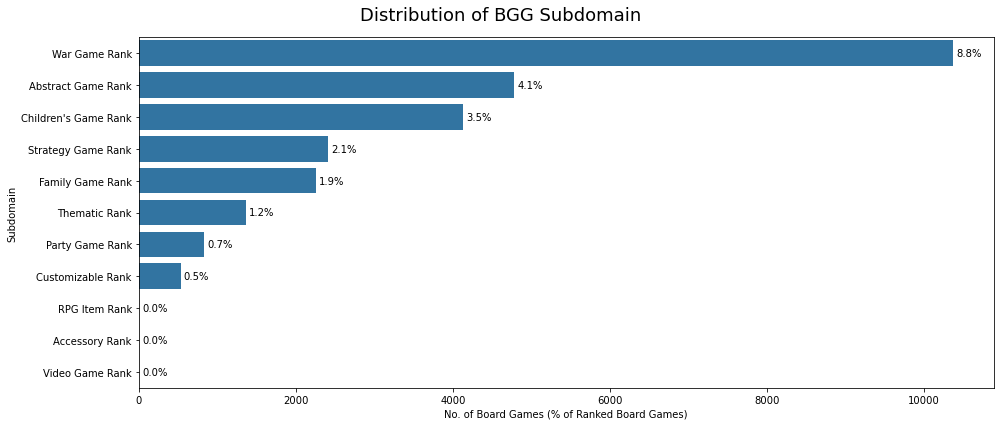

In [45]:
#Subdomain

bgg_subdomain = bgg_details['subdomain_1'].value_counts().reset_index(name='count').sort_values('count', ascending=False)

fig, ax = plt.subplots(figsize=(14,6))

sns.barplot(ax=ax, data=bgg_subdomain, y='index', x='count')

fig.suptitle('Distribution of BGG Subdomain', size=18)
ax.set_ylabel('Subdomain')
ax.set_xlabel('No. of Board Games (% of Ranked Board Games)')

#Annotate bars
for bars in ax.containers:
    for p in bars:
        ax.annotate(f"{round(100*p.get_width()/len(bgg_details),1)}%",
                    (p.get_width(), p.get_y() + p.get_height()/ 2,),
                    xytext=(3, 0),
                    textcoords='offset points',
                    size=10,
                    ha='left',
                    va='center')

plt.tight_layout();


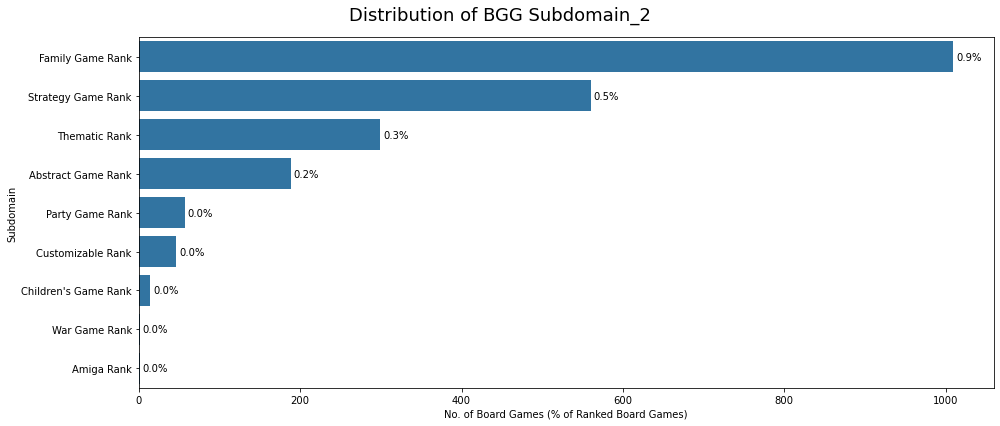

In [46]:
#Subdomain2

bgg_subdomain = bgg_details['subdomain_2'].value_counts().reset_index(name='count').sort_values('count', ascending=False)

fig, ax = plt.subplots(figsize=(14,6))

sns.barplot(ax=ax, data=bgg_subdomain, y='index', x='count')

fig.suptitle('Distribution of BGG Subdomain_2', size=18)
ax.set_ylabel('Subdomain')
ax.set_xlabel('No. of Board Games (% of Ranked Board Games)')

#Annotate bars
for bars in ax.containers:
    for p in bars:
        ax.annotate(f"{round(100*p.get_width()/len(bgg_details),1)}%",
                    (p.get_width(), p.get_y() + p.get_height()/ 2,),
                    xytext=(3, 0),
                    textcoords='offset points',
                    size=10,
                    ha='left',
                    va='center')

plt.tight_layout();


* We could see that from the dataset, majority of the board games belong to a War Game (e.g. Root, Risk) or Abstract Game (e.g. Azul, Santorini) subdomain.

#### 6.1.2 Mechanics of Board Games <a id="mechanics"></a>

In [70]:
bgg_mechanics = bgg_classification[bgg_classification['classification'] == 'boardgamemechanic'].value_counts('value')\
.reset_index(name='count')

bgg_mechanics.head()

value  count
0            Dice Rolling  38857
1         Hand Management  21030
2    Roll / Spin and Move  17230
3  Variable Player Powers  15738
4          Set Collection  15711

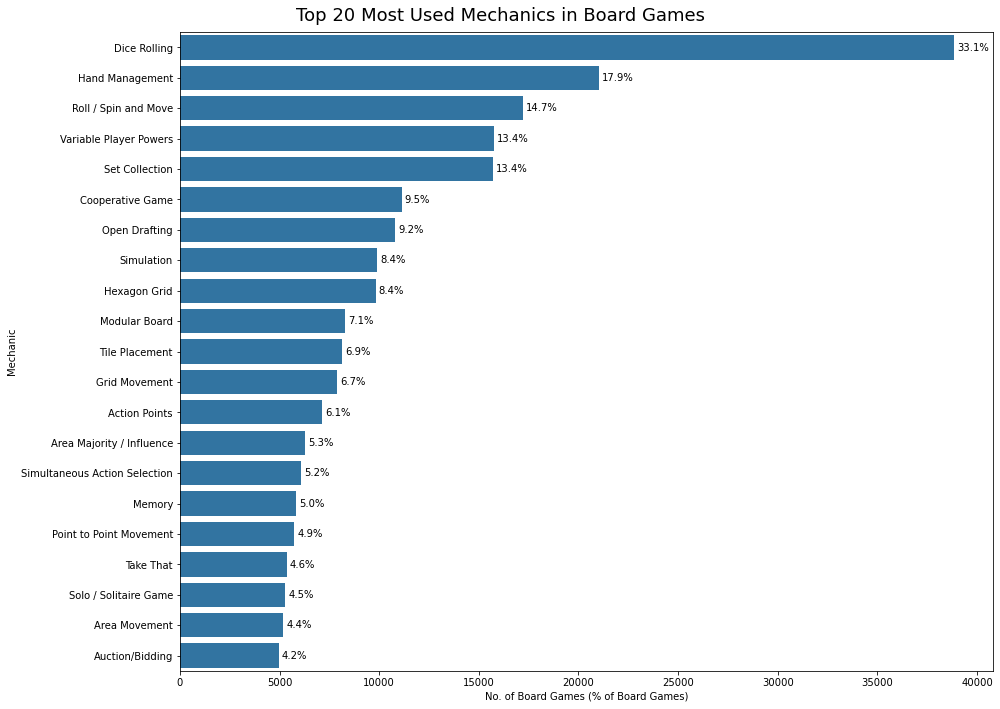

In [70]:
#Top 20 Mechanics

fig, ax = plt.subplots(figsize=(14,10))

sns.barplot(ax=ax, 
            data=bgg_mechanics.sort_values('count', ascending=False).iloc[:21], 
            y='value', 
            x='count')

fig.suptitle('Top 20 Most Used Mechanics in Board Games', size=18)
ax.set_ylabel('Mechanic')
ax.set_xlabel('No. of Board Games (% of Board Games)')

#Annotate bars
for bars in ax.containers:
    for p in bars:
        ax.annotate(f"{round(100*p.get_width()/len(bgg_details),1)}%",
                    (p.get_width(), p.get_y() + p.get_height()/ 2,),
                    xytext=(3, 0),
                    textcoords='offset points',
                    size=10,
                    ha='left',
                    va='center')

plt.tight_layout();

* `Dice Rolling` is the top mechanic that is incorporated in board games to introduce randomness in the board game, while `Hand Management` rewards the strategic decision making of players of choosing the most optimal sequence of cards played. Similarly, `Roll/Spin and Move` allows players to move a component depending on the the results of dice or spinners.

#### 6.1.3 Categories of Board Games <a id="categories"></a>

In [72]:
bgg_categories = bgg_classification[bgg_classification['classification'] == 'boardgamecategory'].value_counts('value')\
.reset_index(name='count')

bgg_categories.head()

value  count
0                Card Game  38878
1  Expansion for Base-game  29161
2                  Wargame  23176
3                  Fantasy  16974
4          Children's Game  16293

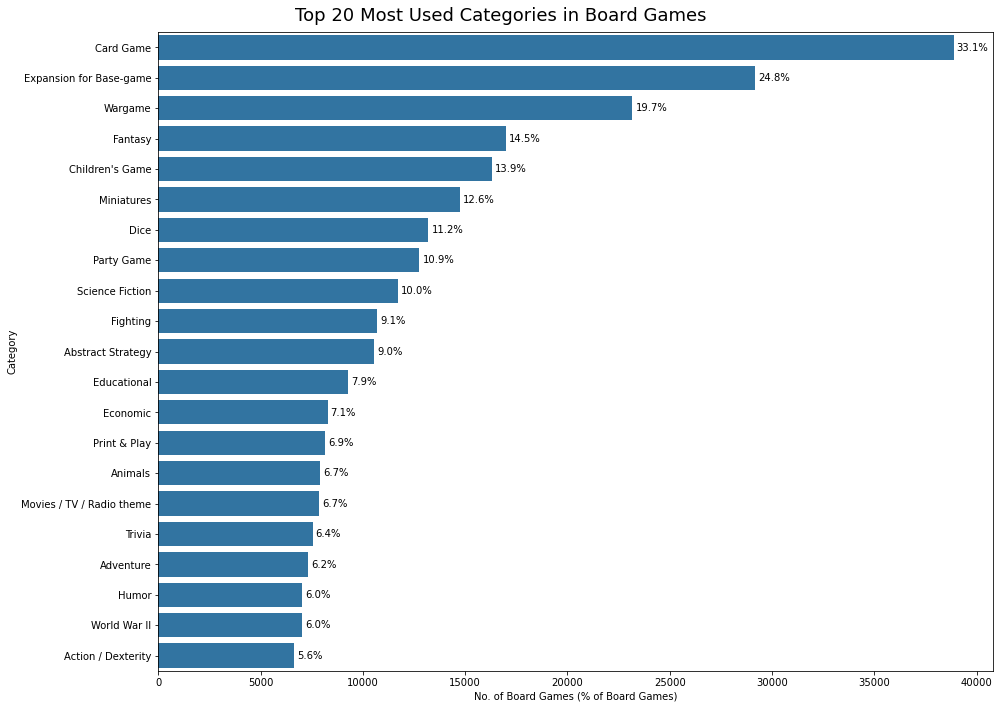

In [72]:
#Top 20 Categories

fig, ax = plt.subplots(figsize=(14,10))

sns.barplot(ax=ax, data=bgg_categories.sort_values('count', ascending=False).iloc[:21], 
            y='value', 
            x='count')

fig.suptitle('Top 20 Most Used Categories in Board Games', size=18)
ax.set_ylabel('Category')
ax.set_xlabel('No. of Board Games (% of Board Games)')

#Annotate bars
for bars in ax.containers:
    for p in bars:
        ax.annotate(f"{round(100*p.get_width()/len(bgg_details),1)}%",
                    (p.get_width(), p.get_y() + p.get_height()/ 2,),
                    xytext=(3, 0),
                    textcoords='offset points',
                    size=10,
                    ha='left',
                    va='center')

plt.tight_layout();

* `Card Game` can refer to stand-alone games in which all cards are included in the board game itself and can also extend to collectible card games where players can purchase starter cards that can be later supplemented with booster cards. Successful board games often introduce new elements to their core game by releasing variations or additional components categorized as `Expansion for Base Game`. With `War games` containing strategic and tactical components in all its board game and their adaptability to various timelines, positions them as one of the most frequently released board game genres, as evidenced by the distribution within the `subdomain`.

#### 6.1.4 Families of Board Games <a id="families"></a>

In [73]:
bgg_families = bgg_classification[bgg_classification['classification'] == 'boardgamefamily'].value_counts('value')\
.reset_index(name='count')

bgg_families.head()

value  count
0       Players: Two Player Only Games  23187
1            Crowdfunding: Kickstarter  15786
2             Admin: Upcoming Releases   8866
3  Players: Games with Solitaire Rules   3965
4    Admin: Better Description Needed!   3637

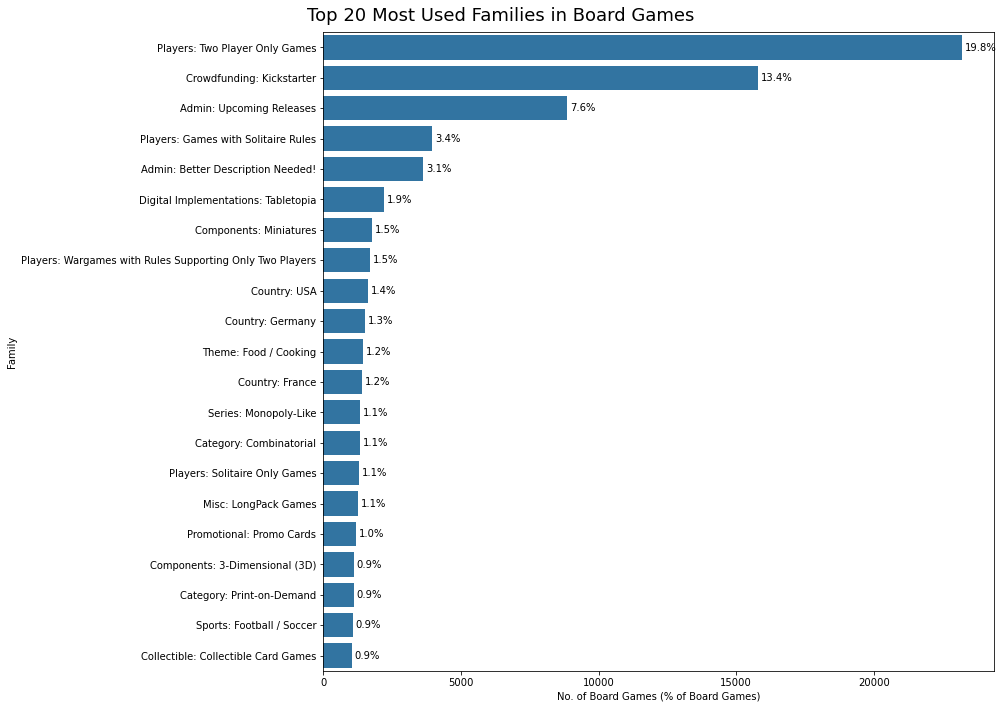

In [74]:
#Top 20 Families

fig, ax = plt.subplots(figsize=(14,10))

sns.barplot(ax=ax, data=bgg_families.sort_values('count', ascending=False).iloc[:21], 
            y='value', 
            x='count')

fig.suptitle('Top 20 Most Used Families in Board Games', size=18)
ax.set_ylabel('Family')
ax.set_xlabel('No. of Board Games (% of Board Games)')

#Annotate bars
for bars in ax.containers:
    for p in bars:
        ax.annotate(f"{round(100*p.get_width()/len(bgg_details),1)}%",
                    (p.get_width(), p.get_y() + p.get_height()/ 2,),
                    xytext=(3, 0),
                    textcoords='offset points',
                    size=10,
                    ha='left',
                    va='center')

plt.tight_layout();

* `Crowfunding: Kickstarter` are board games that were launched on the [Kickstarter website.](https://www.kickstarter.com/) as a crowdfunding initiative where initial investors are rewarded with early access or other benefits in exchange for their support. This board game family includes top board games like Brass: Birmingham, Gloomhaven, and Scythe.

#### 6.1.5 Best No. of Players for Board Games <a id="best_no_players"></a>

In [74]:
#Poll for suggested number of players
bgg_poll_players = bgg_poll[bgg_poll['poll_title'].apply(lambda x: True if 'suggested_numplayers' in x else False)]

#Number of players with 'Best' rating
bgg_best_numplayers = bgg_poll_players[bgg_poll_players['poll_answer'] == 'Best'].value_counts('poll_title')\
.reset_index(name='count')

#Excluding num_players with '+'
bgg_best_numplayers['poll_title'] = bgg_best_numplayers['poll_title'].apply(lambda x: x.split(' - ')[-1])
bgg_best_numplayers.columns = ['num_players', 'count']
bgg_best_numplayers = bgg_best_numplayers[bgg_best_numplayers['num_players'].apply(lambda x: False if '+' in x else True)]\
.astype('int64').sort_values('num_players').reset_index(drop=True)

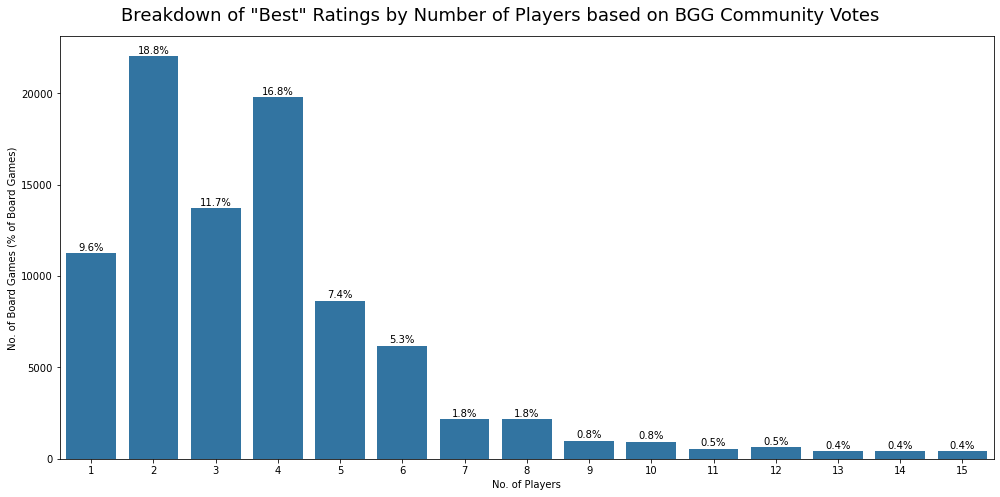

In [75]:
fig, ax = plt.subplots(figsize=(14,7))

sns.barplot(ax=ax, 
            data=bgg_best_numplayers.iloc[:15], 
            y='count', 
            x='num_players')

fig.suptitle('Breakdown of "Best" Ratings by Number of Players based on BGG Community Votes', size=18)
ax.set_ylabel('No. of Board Games (% of Board Games)')
ax.set_xlabel('No. of Players')

# #Annotate bars
for bars in ax.containers:
    for p in bars:
        ax.annotate(f"{round(100*p.get_height()/len(bgg_details),1)}%",
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    xytext=(0, 6),
                    textcoords='offset points',
                    size=10,
                    ha='center',
                    va='center'
                   )

plt.tight_layout();

* According to the poll on the preferred number of players for board games, it appears that the sweet spot lies within the range of 2 to 4 players. This range may serve as an indicator of the optimal number of players commonly preferred by users of BGG.

#### 6.1.6 Recommended Player Age of Board Games <a id="recommended_player_age"></a>

In [77]:
bgg_poll_age = bgg_poll[bgg_poll['poll_title'].apply(lambda x: True if 'suggested_playerage' in x else False)]

bgg_poll_age = bgg_poll_age.value_counts('poll_answer').reset_index(name='count')

bgg_poll_age['poll_answer'].iloc[11] = 21

bgg_poll_age['poll_answer'] = bgg_poll_age['poll_answer'].astype('int64')

bgg_poll_age = bgg_poll_age.sort_values('poll_answer').reset_index(drop=True)

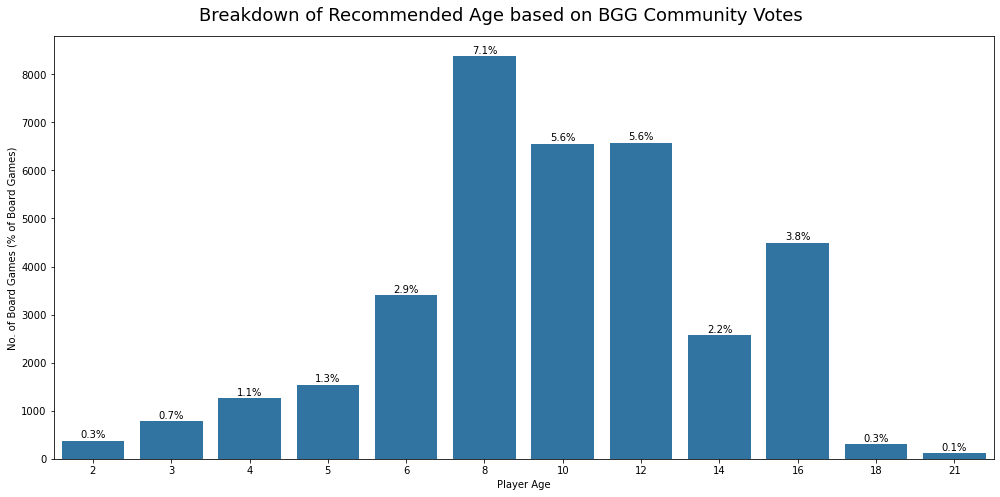

In [78]:
fig, ax = plt.subplots(figsize=(14,7))

sns.barplot(ax=ax, 
            data=bgg_poll_age, 
            y='count', 
            x='poll_answer')

fig.suptitle('Breakdown of Recommended Age based on BGG Community Votes', size=18)
ax.set_ylabel('No. of Board Games (% of Board Games)')
ax.set_xlabel('Player Age')

# #Annotate bars
for bars in ax.containers:
    for p in bars:
        ax.annotate(f"{round(100*p.get_height()/len(bgg_details),1)}%",
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    xytext=(0, 6),
                    textcoords='offset points',
                    size=10,
                    ha='center',
                    va='center'
                   )

plt.tight_layout();

* Most board games have a recommended minimum age of 8-10 years old which is the minimum age for most board games that have a *medium light* complexity rating (e.g. Carcasonne, Ticket to Ride, King of Tokyo).

### 6.2 Numerical Attributes <a id="numerical_attributes"></a>

#### 6.2.1 Ranked Games <a id="ranked_games"></a>

In [47]:
bgg_ranked = bgg_details[bgg_details['bgg_rank'] != 0].sort_values('bgg_rank').reset_index(drop=True)

In [48]:
bgg_ranked.shape

(25521, 23)

* Among nearly 118,000 board games in the dataset, only 25,000 have rankings, indicating that they have received a minimum of 30 user ratings. The subsequent analysis will concentrate on these ranked games (except of `year_published`, reflecting their significant popularity within the BoardGameGeek community.

In [81]:
bgg_ranked.head(3)

bgg_id   bgg_type                       name  \
0  224517  boardgame          Brass: Birmingham   
1  161936  boardgame  Pandemic Legacy: Season 1   
2  174430  boardgame                 Gloomhaven   

                                             img_src  \
0  https://cf.geekdo-images.com/x3zxjr-Vw5iU4yDPg...   
1  https://cf.geekdo-images.com/-Qer2BBPG7qGGDu6K...   
2  https://cf.geekdo-images.com/sZYp_3BTDGjh2unaZ...   

                                         description  year_published  \
0  Brass: Birmingham is an economic strategy game...            2018   
1  Pandemic Legacy is a co-operative campaign gam...            2015   
2  Gloomhaven  is a game of Euro-inspired tactica...            2017   

   min_players  max_players  playing_time  min_playtime  max_playtime  \
0            2            4           120            60           120   
1            2            4            60            60            60   
2            1            4           120            60           120   

   min_age  users_rated  average  bayes_average  num_weights  average_weight  \
0       14        42488  8.60549        8.42003         2011          3.8916   
1       13        52171  8.53167        8.38546         1418          2.8322   
2       14        60552  8.60523        8.37103         2480          3.9008   

   bgg_rank  num_owners         subdomain_1  subdomain_1_rank  \
0         1       58962  Strategy Game Rank                 1   
1         2       81047       Thematic Rank                 1   
2         3       94566       Thematic Rank                 2   

          subdomain_2  subdomain_2_rank  
0                 NaN                 0  
1  Strategy Game Rank                 1  
2  Strategy Game Rank                 2

In [82]:
bgg_ranked.describe().T

count          mean          std         min         25%  \
year_published    25521.0   1987.272168   211.431180 -3500.00000  2003.00000   
min_players       25521.0      1.974805     0.703796     0.00000     2.00000   
max_players       25521.0      5.924494    15.085747     0.00000     4.00000   
playing_time      25521.0     93.602641   724.486381     0.00000    25.00000   
min_playtime      25521.0     58.884918   396.414297     0.00000    20.00000   
max_playtime      25521.0     93.602641   724.486381     0.00000    25.00000   
min_age           25521.0      9.661259     3.648187     0.00000     8.00000   
users_rated       25521.0    925.909016  4060.776040    30.00000    56.00000   
average           25521.0      6.449083     0.927914     1.15595     5.87037   
bayes_average     25521.0      5.674941     0.354550     3.63981     5.50926   
num_weights       25521.0     48.325144   207.152422     0.00000     4.00000   
average_weight    25521.0      1.951265     0.831574     0.00000     1.26470   
bgg_rank          25521.0  12802.152502  7402.067697     1.00000  6382.00000   
num_owners        25521.0   1627.281141  6111.117982     1.00000   153.00000   
subdomain_1_rank  25521.0    709.345598  1019.257341     0.00000     0.00000   
subdomain_2_rank  25521.0     76.501548   378.286801     0.00000     0.00000   

                          50%          75%           max  
year_published     2013.00000   2018.00000    2023.00000  
min_players           2.00000      2.00000      10.00000  
max_players           4.00000      6.00000     999.00000  
playing_time         45.00000     90.00000   84000.00000  
min_playtime         30.00000     60.00000   60000.00000  
max_playtime         45.00000     90.00000   84000.00000  
min_age              10.00000     12.00000      21.00000  
users_rated         125.00000    408.00000  123891.00000  
average               6.48380      7.07609       9.75686  
bayes_average         5.54046      5.65838       8.42003  
num_weights           9.00000     24.00000    8160.00000  
average_weight        1.87500      2.50000       5.00000  
bgg_rank          12797.00000  19223.00000   25621.00000  
num_owners          333.00000    952.00000  199586.00000  
subdomain_1_rank     99.00000   1130.00000    5721.00000  
subdomain_2_rank      0.00000      0.00000    5721.00000

#### Findings:

* The median value of `year_published` is 2013 which tells us that majority of ranked board games came from recent games, most likely for the past 10 to 20 years.
* The suggested `min_players` and `max_players` based from the median are 2 to 4 players which is a good range of players for most of the board games I played.  Seeing that the minimum (0) and maximum values (999) for these features are not possible could mean that the dataset contains erroneous information.
* Likewise, the `playing_time` for the ranked board games are between 30 to 45 minutes which an acceptable time range for beginner up to advanced players.
* The mean and median of `users_rated` have significant difference and may signify non-normal distribution of user ratings.
* The `average` rating of ranked board games is nearly identical at 6.45 for both the mean and median, indicating a normal distribution of the variable.
* Geek rating (`bayes_average`) of ranked board games is around 5.5, which is lower than the average rating.
* The `average_weight` or complexity of boards games is around 2.0, representing Medium Light type of board games.

#### 6.2.2 Year Published (1900-2023) <a id="year_published"></a>

In [83]:
bgg_year = bgg_details[bgg_details['year_published'].between(1900,2023)].value_counts('year_published')\
.reset_index(name='count').sort_values('year_published')

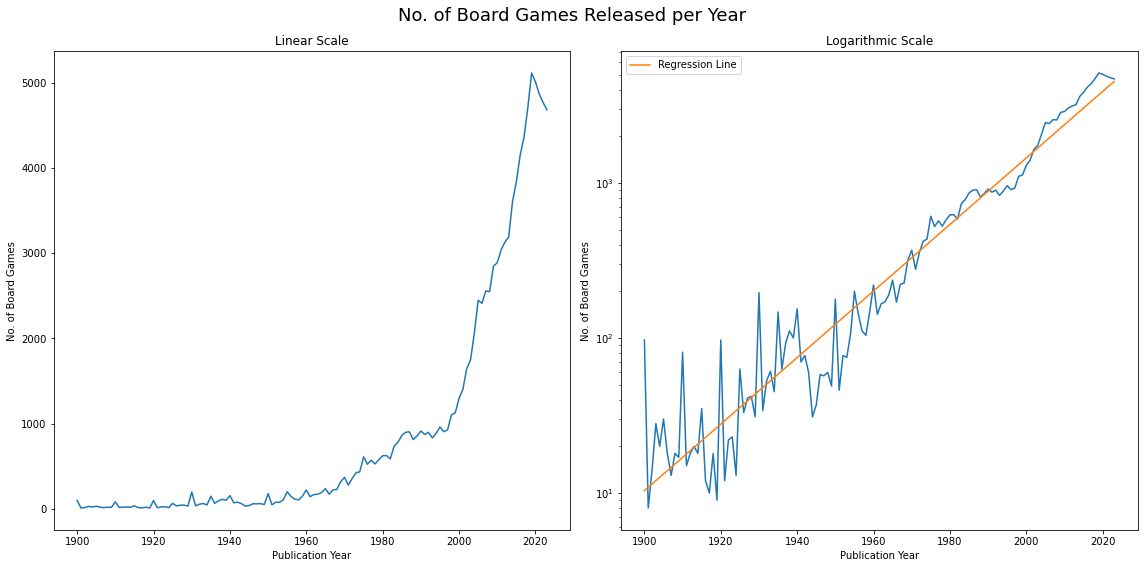

In [84]:
fig, axs = plt.subplots(nrows=1,
                        ncols=2,
                        figsize=(16,8))

sns.lineplot(ax=axs[0],
             data=bgg_year,
             x='year_published',
             y='count')

sns.lineplot(ax=axs[1],
             data=bgg_year,
             x='year_published',
             y='count')

#regression line
reg_line = np.poly1d(np.polyfit(bgg_year['year_published'], np.log(bgg_year['count']), 1))

sns.lineplot(ax=axs[1],
             x=bgg_year['year_published'],
             y=np.exp(reg_line(bgg_year['year_published'])),
            label='Regression Line')

axs[1].set_yscale('log')

fig.suptitle('No. of Board Games Released per Year', size=18)
ax.set_ylabel('No. of Board Games (% of Board Games)')
axs[0].set_title('Linear Scale')
axs[1].set_title('Logarithmic Scale')
axs[0].set_xlabel('Publication Year')
axs[1].set_xlabel('Publication Year')
axs[0].set_ylabel('No. of Board Games')
axs[1].set_ylabel('No. of Board Games')

axs[1].legend()

plt.tight_layout();

* The line chart shows that there has been an exponential increase in board game publications since 2000. The [robust growth](https://www.washingtonpost.com/business/2022/12/24/board-game-popularity/) of the board game industry can be attributed to crowdfunding platforms making it easier for designers to release games with better mechanics and higher quality components.  

#### 6.2.3 Minimum Age <a id="minimum_age"></a>

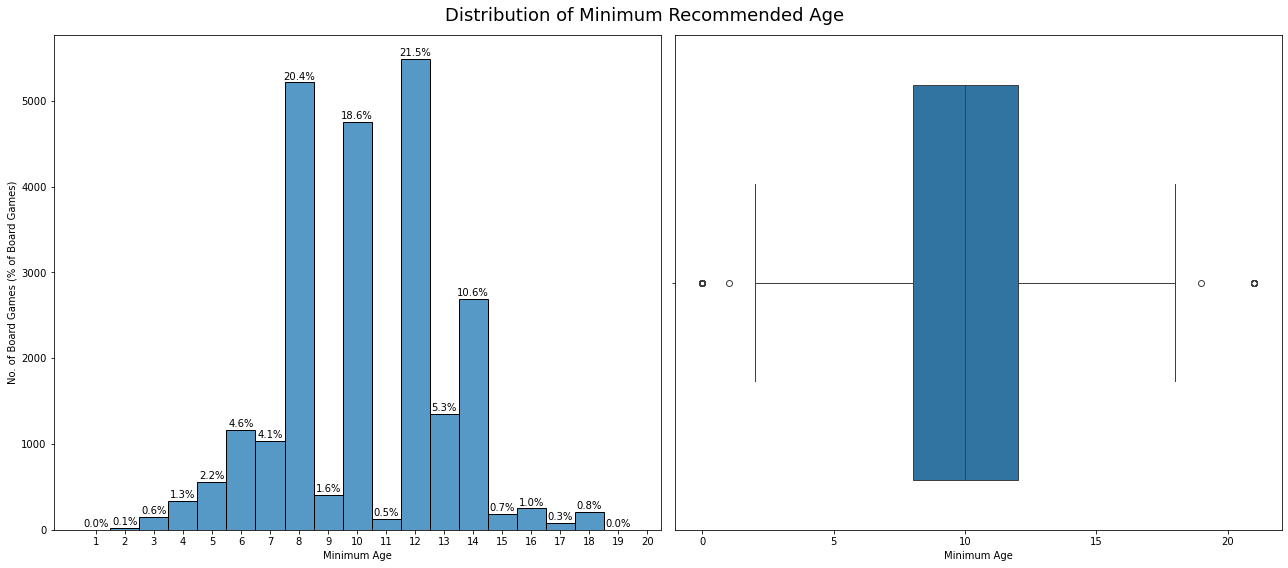

In [85]:
fig, axs = plt.subplots(nrows=1,
                        ncols=2,
                        figsize=(18,8))

sns.histplot(
    ax=axs[0],
    data=bgg_ranked,
    x='min_age',
    bins=np.arange(1,21)-0.5
)

sns.boxplot(
    ax=axs[1],
    data=bgg_ranked[bgg_ranked['min_age'] <= 50],
    x='min_age',
)

fig.suptitle('Distribution of Minimum Recommended Age', size=18)

axs[0].set_ylabel('No. of Board Games (% of Board Games)')
axs[0].set_xlabel('Minimum Age')
axs[1].set_xlabel('Minimum Age')

# #Annotate bars
for bars in axs[0].containers:
    for p in bars:
        axs[0].annotate(f"{round(100*p.get_height()/len(bgg_ranked),1)}%",
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    xytext=(0, 6),
                    textcoords='offset points',
                    size=10,
                    ha='center',
                    va='center'
                   )

axs[0].set_xticks(np.arange(1,21,1))
axs[1].set_xticks(np.arange(0,25,5))

plt.tight_layout();

* The majority of ranked games typically have a recommended minimum age falling within the range of 8 to 12 years old, with a median value of 10 years old. Again, these figures align closely with the age range commonly agreed upon by the community, including unranked board games.

#### 6.2.4 Minimum Playing Time <a id="minimum_playing_time"></a>

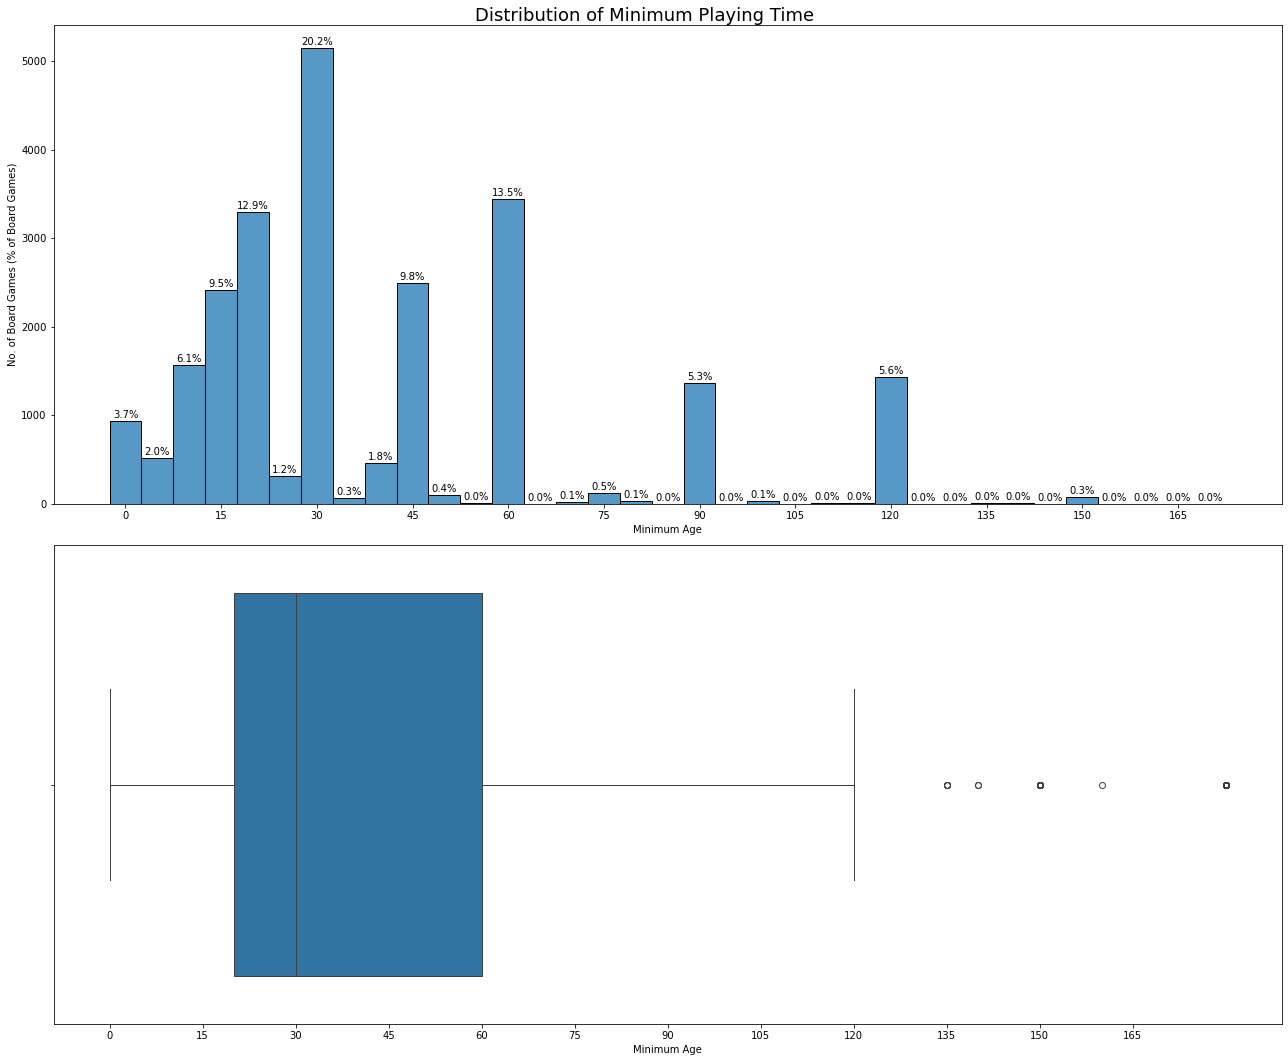

In [86]:
fig, axs = plt.subplots(nrows=2,
                        ncols=1,
                        figsize=(18,15))

sns.histplot(
    ax=axs[0],
    data=bgg_ranked[bgg_ranked['min_playtime'] <= 180],
    x='min_playtime',
    bins=np.arange(0,180,5)-2.5
)

sns.boxplot(
    ax=axs[1],
    data=bgg_ranked[bgg_ranked['min_playtime'] <= 180],
    x='min_playtime',
)

fig.suptitle('Distribution of Minimum Playing Time', size=18)

axs[0].set_ylabel('No. of Board Games (% of Board Games)')
axs[0].set_xlabel('Minimum Age')
axs[1].set_xlabel('Minimum Age')

# #Annotate bars
for bars in axs[0].containers:
    for p in bars:
        axs[0].annotate(f"{round(100*p.get_height()/len(bgg_ranked),1)}%",
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    xytext=(0, 6),
                    textcoords='offset points',
                    size=10,
                    ha='center',
                    va='center'
                   )

axs[0].set_xticks(np.arange(0,180,15))
axs[1].set_xticks(np.arange(0,180,15))

plt.tight_layout();

* Board games typically have an average playing time of 30 mins as shown in the graphs above which caters to players that prefer short but intense games (e.g. 7 Wonders, Splendor, Dominion).

#### 6.2.5 Number of User Ratings <a id="no_of_user_ratings"></a>

In [87]:
bgg_ranked_sorted = bgg_ranked.sort_values('users_rated', ascending=False).reset_index(drop=True)

In [573]:
bgg_ranked_sorted.head(10)['name']

0                CATAN
1          Carcassonne
2             Pandemic
3            7 Wonders
4    Terraforming Mars
5       7 Wonders Duel
6             Dominion
7            Codenames
8       Ticket to Ride
9             Wingspan
Name: name, dtype: object

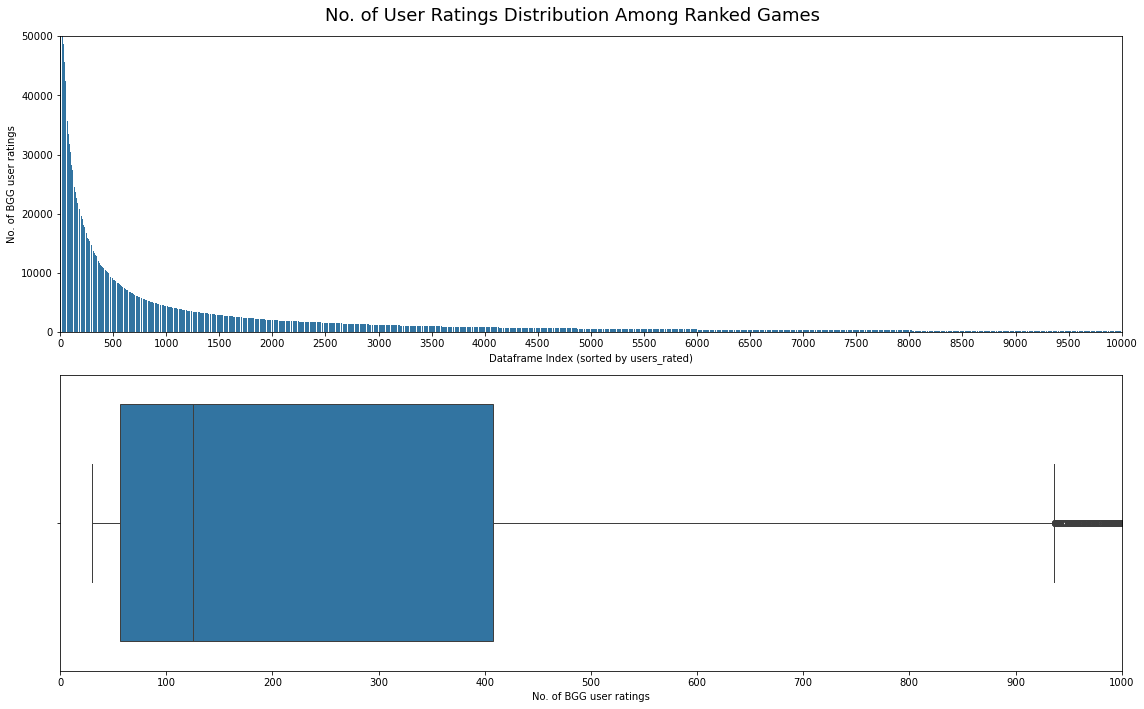

In [571]:
fig, axs = plt.subplots(ncols=1,
                        nrows=2,
                        figsize=(16,10))

sns.barplot(
    ax=axs[0],
    x=bgg_ranked_sorted.iloc[:10001].index,
    y=bgg_ranked_sorted['users_rated'].iloc[:10001]
)

sns.boxplot(
    ax=axs[1],
    data=bgg_ranked,
    x='users_rated',
)

fig.suptitle('No. of User Ratings Distribution Among Ranked Games', size=18)

axs[0].set_ylabel('No. of BGG user ratings')
axs[0].set_xlabel('Dataframe Index (sorted by users_rated)')
axs[0].set_xlim(0,10000)
axs[0].set_ylim(0,50000)
axs[0].set_xticks(np.arange(0,10001,500))

axs[1].set_xlim(0,1000)
axs[1].set_xticks(np.arange(0,1001,100))
axs[1].set_xlabel('No. of BGG user ratings')

plt.tight_layout();

* The long tail distribution of user ratings for board games implies that numerous games have a very low number of ratings. Among the top 1000 games ranked by user ratings, some have received up to 50,000 votes. However, subsequent games tend to have significantly fewer votes, often falling below 1000. The median number of votes is around 125 for ranked games and this pattern suggests that user ratings can serve as an indicator of a board game's popularity.

#### 6.2.6 Average Rating <a id="average_rating"></a>

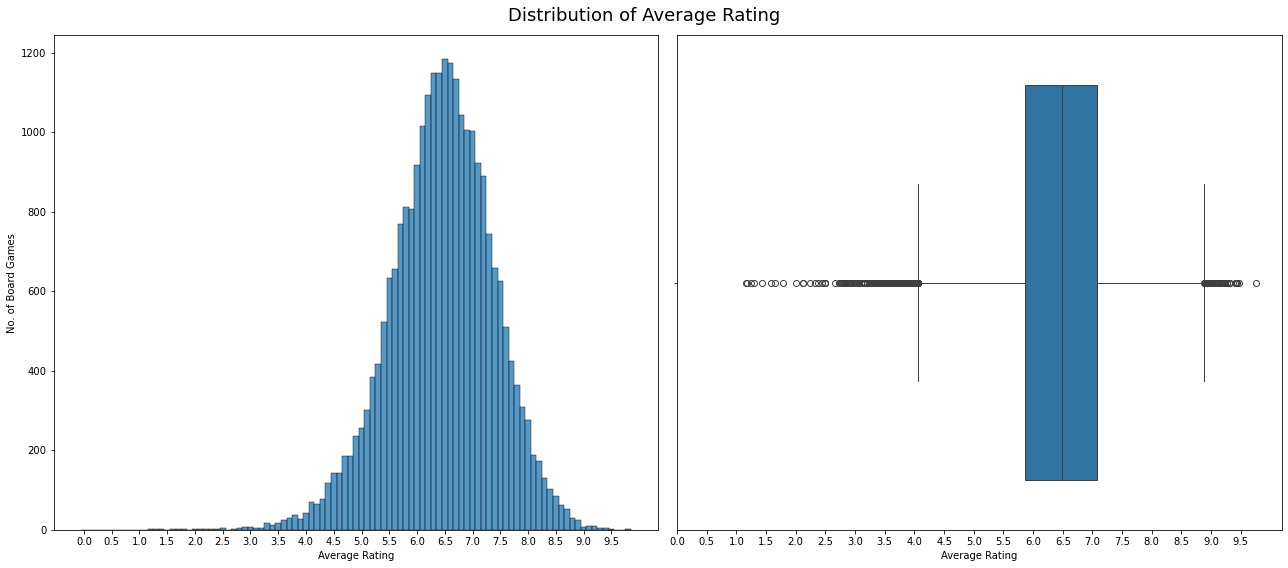

In [90]:
fig, axs = plt.subplots(nrows=1,
                        ncols=2,
                        figsize=(18,8))

sns.histplot(
    ax=axs[0],
    data=bgg_ranked,
    x='average',
    bins=np.arange(0,10,0.1)-0.05
)

sns.boxplot(
    ax=axs[1],
    data=bgg_ranked,
    x='average',
)

fig.suptitle('Distribution of Average Rating', size=18)

axs[0].set_ylabel('No. of Board Games')
axs[0].set_xlabel('Average Rating')
axs[1].set_xlabel('Average Rating')


axs[0].set_xticks(np.arange(0,10,0.5))
axs[1].set_xticks(np.arange(0,10,0.5))

plt.tight_layout();

* Both the mean and median values of the average rating is around 6.5 which means that the BGG community has a tendency to rate board games positively.

#### 6.2.7 Geek Rating <a id="geek_rating"></a>

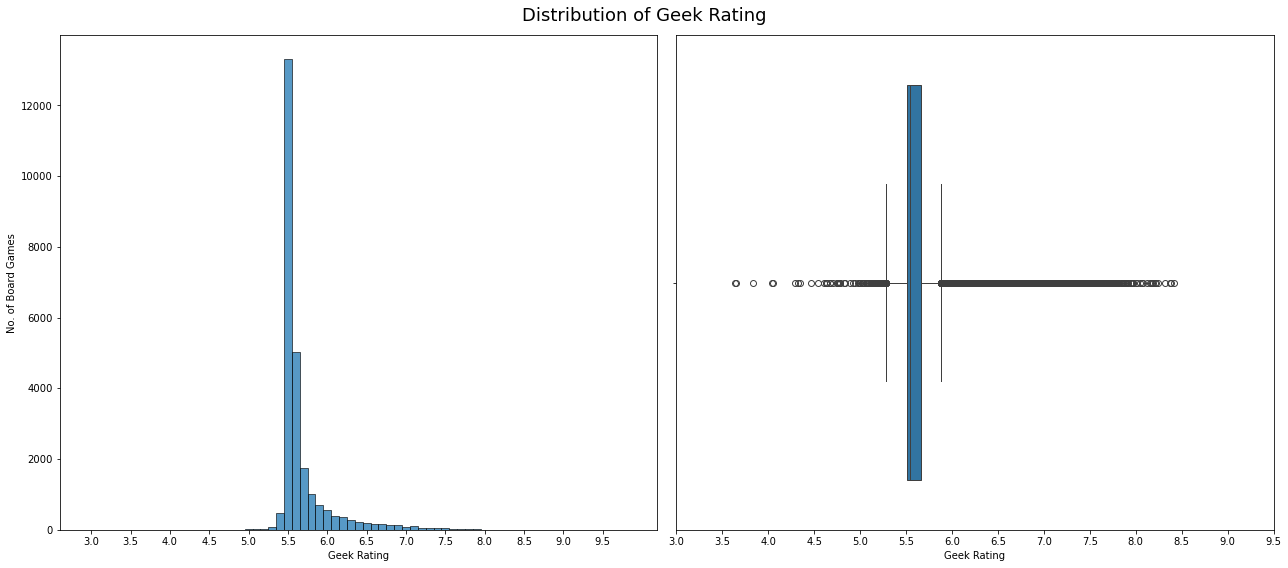

In [91]:
fig, axs = plt.subplots(nrows=1,
                        ncols=2,
                        figsize=(18,8))

sns.histplot(
    ax=axs[0],
    data=bgg_ranked,
    x='bayes_average',
    bins=np.arange(3,10,0.1)-0.05
)

sns.boxplot(
    ax=axs[1],
    data=bgg_ranked,
    x='bayes_average',
)

fig.suptitle('Distribution of Geek Rating', size=18)

axs[0].set_ylabel('No. of Board Games')
axs[0].set_xlabel('Geek Rating')
axs[1].set_xlabel('Geek Rating')


axs[0].set_xticks(np.arange(3,10,0.5))
axs[1].set_xticks(np.arange(3,10,0.5))

plt.tight_layout();

* The conversion of average ratings to geek ratings involves reducing the rating by adding dummy votes, as described in the explanation provided [here](https://boardgamegeek.com/thread/1878315/geek-rating-how-does-it-work). Consequently, a majority of board games tend to have a geek rating of around 5.5. Outliers, depicted in box and whisker plots, represent games that have garnered a significant number of user ratings which contribute to a more compelling evaluation of the board game.

#### 6.2.8 Number of Weight Ratings <a id="no_weight_ratings"></a>

In [574]:
bgg_ranked_sorted = bgg_ranked.sort_values('num_weights', ascending=False).reset_index(drop=True)

In [576]:
bgg_ranked_sorted.head(10)['name']

0          Carcassonne
1                CATAN
2             Agricola
3          Puerto Rico
4             Pandemic
5            7 Wonders
6             Dominion
7       Ticket to Ride
8           Power Grid
9    Terraforming Mars
Name: name, dtype: object

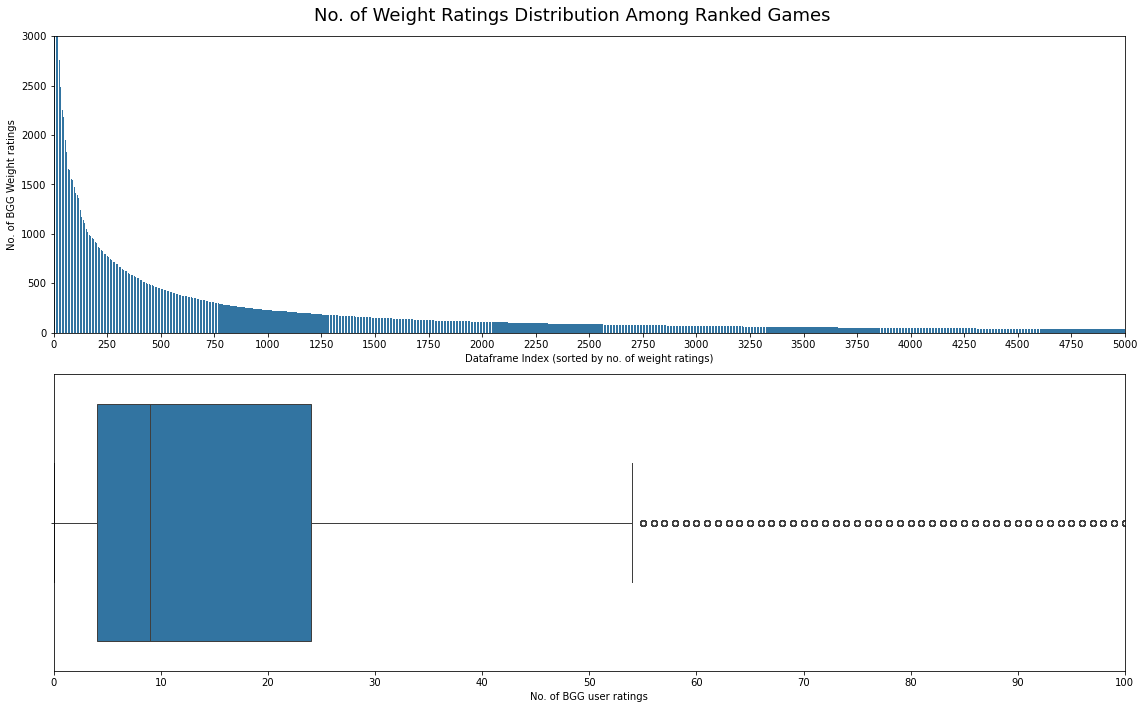

In [584]:
fig, axs = plt.subplots(ncols=1,
                        nrows=2,
                        figsize=(16,10))

sns.barplot(
    ax=axs[0],
    x=bgg_ranked_sorted.iloc[:5001].index,
    y=bgg_ranked_sorted['num_weights'].iloc[:5001]
)

sns.boxplot(
    ax=axs[1],
    data=bgg_ranked,
    x='num_weights',
)

fig.suptitle('No. of Weight Ratings Distribution Among Ranked Games', size=18)

axs[0].set_ylabel('No. of BGG Weight ratings')
axs[0].set_xlabel('Dataframe Index (sorted by no. of weight ratings)')
axs[0].set_xlim(0,5000)
axs[0].set_ylim(0,3000)
axs[0].set_xticks(np.arange(0,5001,250))

axs[1].set_xlim(0,100)
axs[1].set_xticks(np.arange(0,101,10))
axs[1].set_xlabel('No. of BGG user ratings')

plt.tight_layout();

* Similar to user ratings, the long tailed distribution of weight ratings tells us that majority of the ranked board games have low number of votes with only a median value of 9. The top 1000 games by complexity have votes as high as 250.

#### 6.2.9 Weight/Complexity <a id="weight"></a>

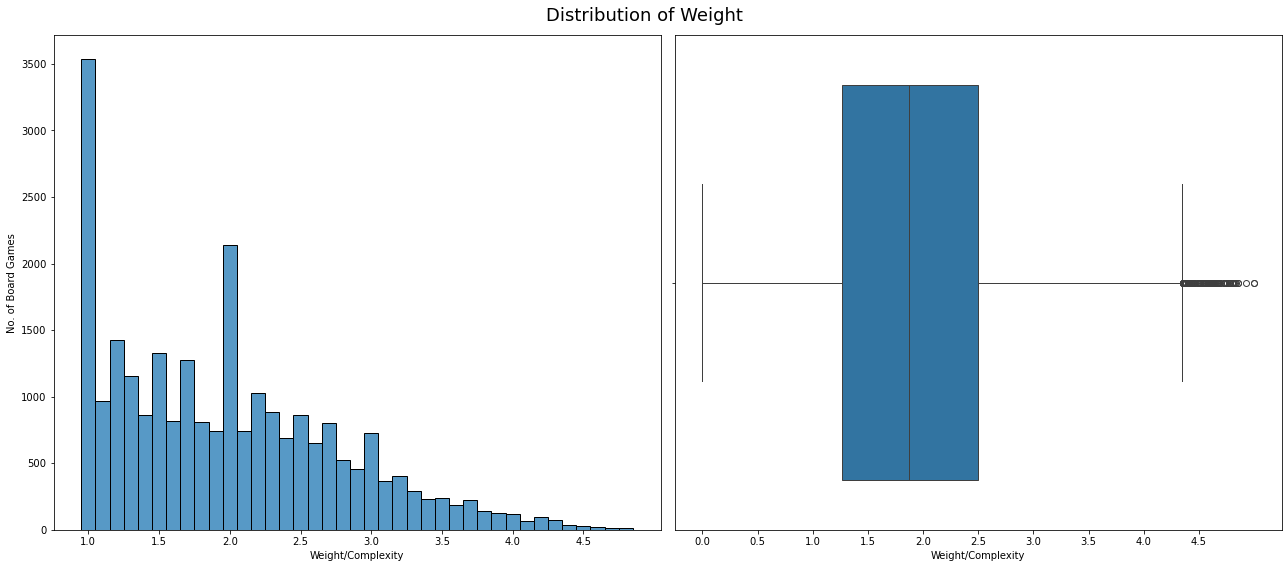

In [92]:
fig, axs = plt.subplots(nrows=1,
                        ncols=2,
                        figsize=(18,8))

sns.histplot(
    ax=axs[0],
    data=bgg_ranked,
    x='average_weight',
    bins=np.arange(1,5,0.1)-0.05
)

sns.boxplot(
    ax=axs[1],
    data=bgg_ranked,
    x='average_weight',
)

fig.suptitle('Distribution of Weight', size=18)

axs[0].set_ylabel('No. of Board Games')
axs[0].set_xlabel('Weight/Complexity')
axs[1].set_xlabel('Weight/Complexity')


axs[0].set_xticks(np.arange(1,5,0.5))
axs[1].set_xticks(np.arange(0,5,0.5))

plt.tight_layout();

* The histogram on the left shows that there is a decreasing number of board games as complexity increases. Overall, the median value of weight for ranked board games is 1.875. This tells us that majority of ranked board games are medium-lightweight to medium weight games.

#### 6.2.10 Number of Owners <a id="no_owners"></a>

In [50]:
bgg_sorted_owners = bgg_ranked.sort_values('num_owners', ascending=False).reset_index(drop=True)

bgg_sorted_owners.head(10)['name']

0                CATAN
1             Pandemic
2          Carcassonne
3       7 Wonders Duel
4            Codenames
5            7 Wonders
6                 Azul
7             Wingspan
8    Terraforming Mars
9       Ticket to Ride
Name: name, dtype: object

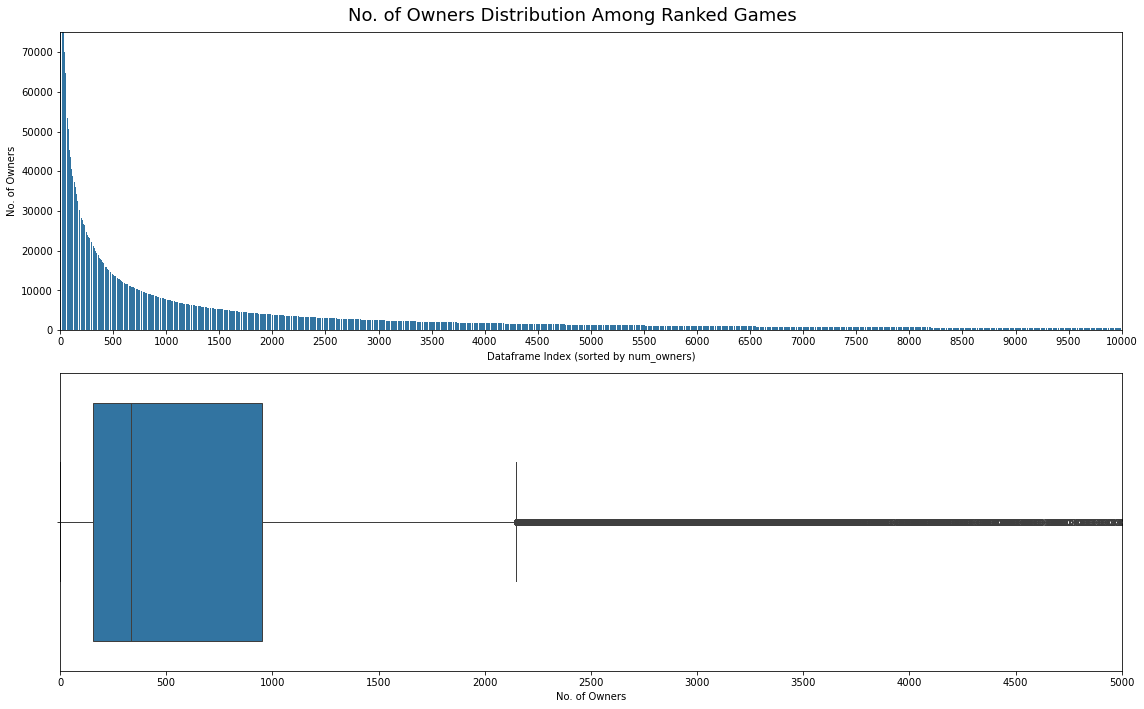

In [51]:
fig, axs = plt.subplots(ncols=1,
                        nrows=2,
                        figsize=(16,10))

sns.barplot(
    ax=axs[0],
    x=bgg_sorted_owners.iloc[:10001].index,
    y=bgg_sorted_owners['num_owners'].iloc[:10001]
)

sns.boxplot(
    ax=axs[1],
    data=bgg_ranked,
    x='num_owners',
)

fig.suptitle('No. of Owners Distribution Among Ranked Games', size=18)

axs[0].set_ylabel('No. of Owners')
axs[0].set_xlabel('Dataframe Index (sorted by num_owners)')
axs[0].set_xlim(0,10000)
axs[0].set_ylim(0,75000)
axs[0].set_xticks(np.arange(0,10001,500))

axs[1].set_xlim(0,5000)
axs[1].set_xticks(np.arange(0,5001,500))
axs[1].set_xlabel('No. of Owners')

plt.tight_layout();

* Likewise, the number of owners exhibits a long-tailed distribution, with the top 1000 games (by ownership) showing values by up to 10,000 users. With a median value of 350, this indicates that the majority of board games have relatively low ownership numbers, making it another potential measure of popularity. It can also be observed that the top 10 games by user ratings also belongs to the top 10 games by ownership.

---
# 7. Bivariate Analysis <a id="bivariate_analysis"></a>

This section focuses on analysis of two features simultaneously. Board game trends (feature vs `year_published`), correlations of features, and the contribution of each feature to board game ratings will be explored.

### 7.1 Board Game Trends <a id="board_game_trends"></a>

The distribution of `year_published` showed an exponential increase in board games since 2000. To have a more in-depth analysis of the trends of board games, we will examine how other features have evolved over the past 30 years (1990-2023). The trend analysis will focus on the ranked board games to have a more representative set of board games that has been reviewed by at least 30 BGG users.

#### 7.1.1 BGG Rank <a id="bgg_rank"></a>

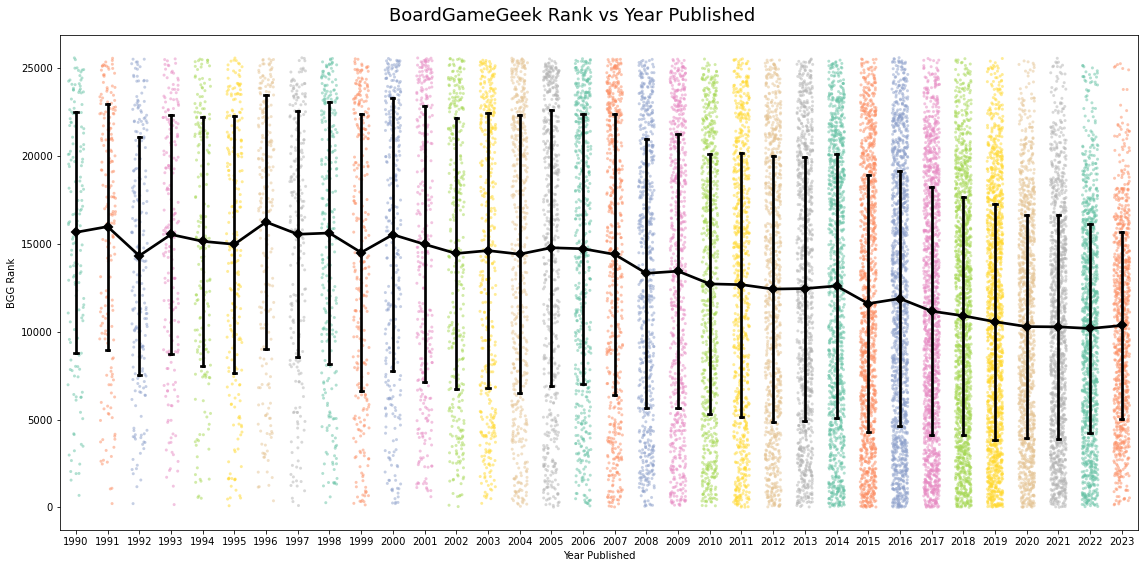

In [96]:
fig, ax = plt.subplots(figsize=(16,8))

sns.stripplot(
    data=bgg_ranked[bgg_ranked['year_published'].between(1990, 2023)],
    x='year_published',
    y='bgg_rank',
    hue='year_published',
    palette='Set2',
    alpha=0.5,
    jitter=0.25,
    s=3,
    zorder=1
)

sns.pointplot(
    data=bgg_ranked[bgg_ranked['year_published'].between(1990, 2023)],
    x='year_published',
    y='bgg_rank',
    estimator='mean',
    errorbar='sd',
    marker='D',
    capsize=0.1,
    color='k',
    scale=1,
)

fig.suptitle('BoardGameGeek Rank vs Year Published', size=18)
ax.set_ylabel('BGG Rank')
ax.set_xlabel('Year Published')

ax.legend().set_visible(False)

plt.tight_layout()

* The decline in average BGG rank can be attributed to the fact that recent games tend to have a Geek Rating close to 5.5, as BGG calculates its ranking based on Geek Rating. It's only when an established board game gains recognition from the community that it can be expected to rise in the rankings, as intended by the BGG administrators.

#### 7.1.2 Average Rating <a id="average_rating_bivariate"></a>

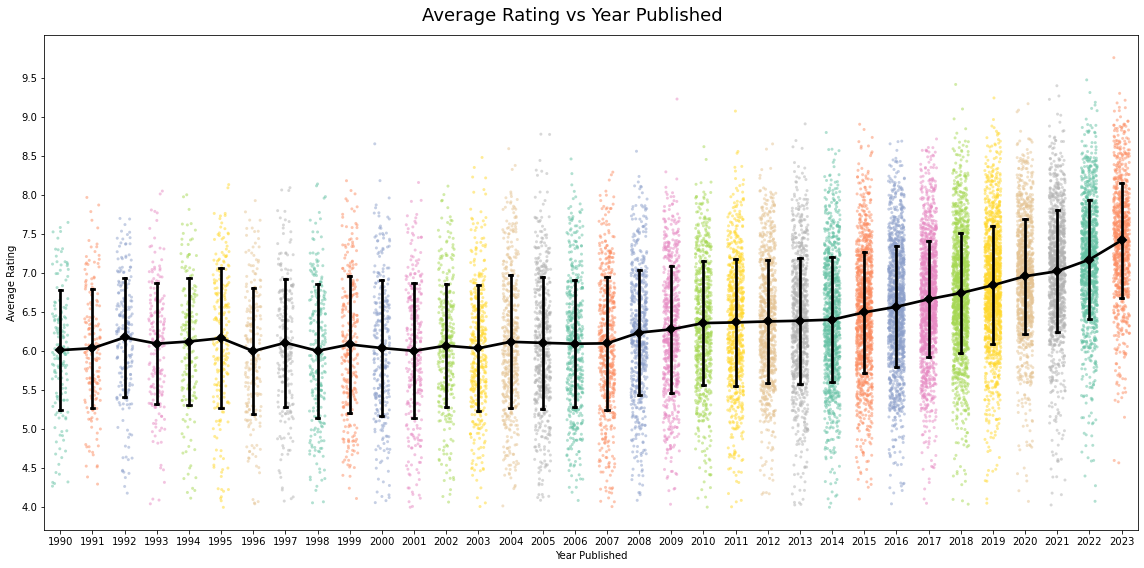

In [97]:
fig, ax = plt.subplots(figsize=(16,8))

sns.stripplot(
    data=bgg_ranked[bgg_ranked['year_published'].between(1990, 2023) & (bgg_ranked['average'] > 4.0)],
    x='year_published',
    y='average',
    hue='year_published',
    palette='Set2',
    alpha=0.5,
    jitter=0.25,
    s=3,
    zorder=1,
)

sns.pointplot(
    data=bgg_ranked[bgg_ranked['year_published'].between(1990, 2023) & (bgg_ranked['average'] > 4.0)],
    x='year_published',
    y='average',
    estimator='mean',
    errorbar='sd',
    marker='D',
    capsize=0.1,
    color='k',
    scale=1,
)

fig.suptitle('Average Rating vs Year Published', size=18)
ax.set_ylabel('Average Rating')
ax.set_xlabel('Year Published')
ax.set_yticks(np.arange(4,10,0.5))

ax.legend().set_visible(False)

plt.tight_layout()

* A clear trend can be seen in the line chart above which shows that recent games tend to have higher average ratings. Some users attribute this increase to *recency bias* but nevertheless, games for the past five to ten years are well received by the community.

#### 7.1.3 Complexity <a id="weight_bivariate"></a>

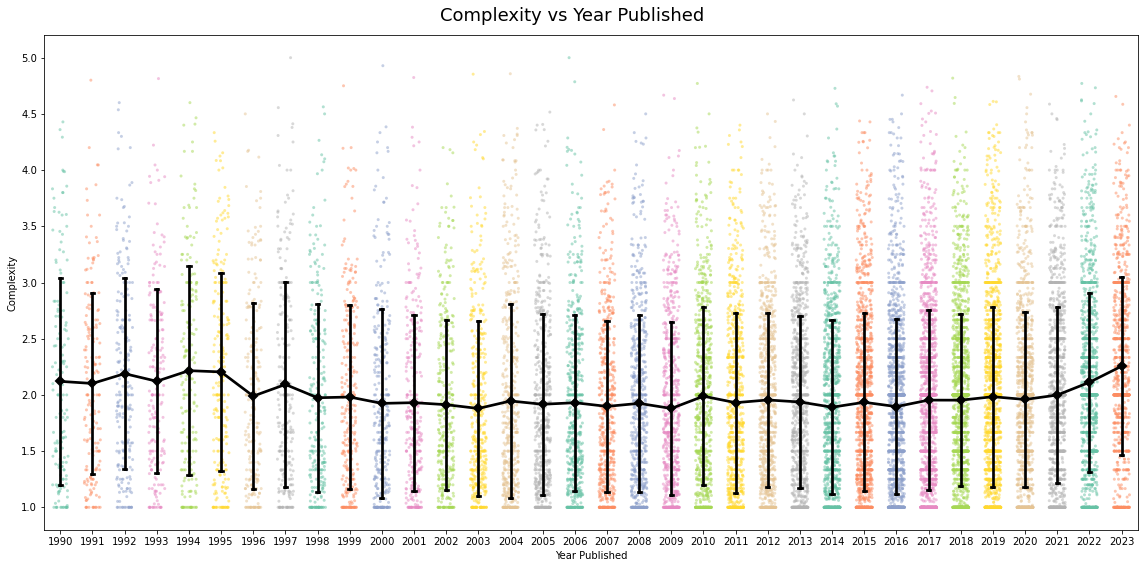

In [98]:
fig, ax = plt.subplots(figsize=(16,8))

sns.stripplot(
    data=bgg_ranked[bgg_ranked['year_published'].between(1990, 2023) & bgg_ranked['average_weight'] > 0],
    x='year_published',
    y='average_weight',
    hue='year_published',
    palette='Set2',
    alpha=0.5,
    jitter=0.25,
    s=3,
    zorder=1
)

sns.pointplot(
    data=bgg_ranked[bgg_ranked['year_published'].between(1990, 2023) & bgg_ranked['average_weight'] > 0],
    x='year_published',
    y='average_weight',
    estimator='mean',
    errorbar='sd',
    marker='D',
    capsize=0.1,
    color='k',
    scale=1,
)

fig.suptitle('Complexity vs Year Published', size=18)
ax.set_ylabel('Complexity')
ax.set_xlabel('Year Published')
ax.set_yticks(np.arange(1,5.5,0.5))

ax.legend().set_visible(False)

plt.tight_layout()

* The complexity of board games has consistently remained at medium-light level over the past 30 years. This suggests that, despite the increase in number of board games being released in recent years, there has been no significant change in the overall complexity of games on average.

#### 7.1.4 No. of Mechanics <a id="no_mechanics_bivariate"></a>

In [802]:
bgg_no_mechanics = bgg_classification[bgg_classification['classification'] == 'boardgamemechanic'].value_counts('bgg_id')\
.reset_index(name='no_mechanics')

bgg_year_mechanics = pd.merge(bgg_ranked[['bgg_id', 'year_published']], bgg_no_mechanics, on='bgg_id', how='left')

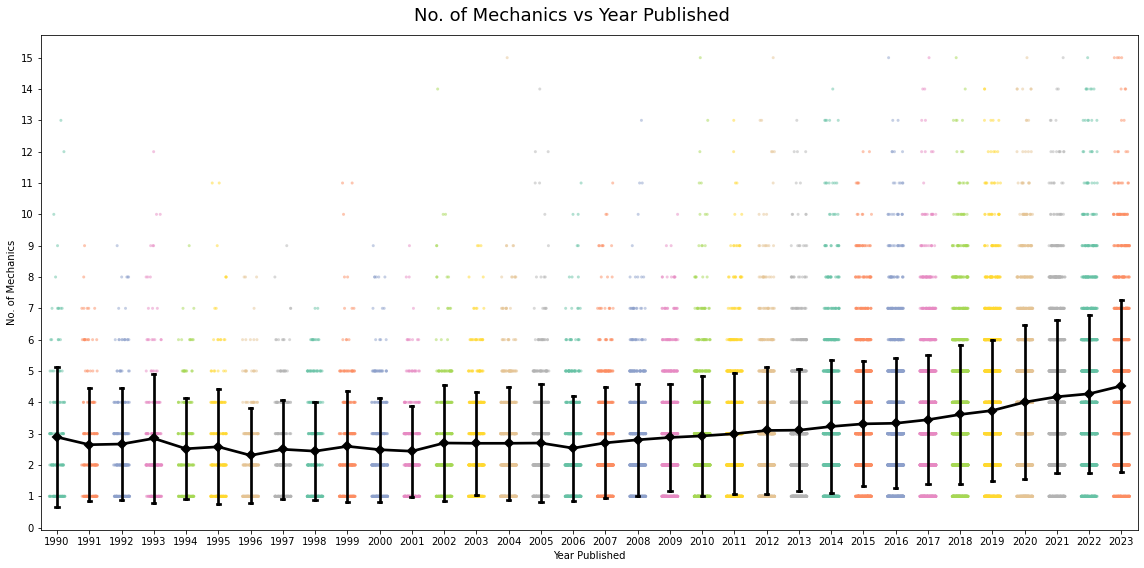

In [101]:
fig, ax = plt.subplots(figsize=(16,8))

sns.stripplot(
    data=bgg_year_mechanics[bgg_year_mechanics['year_published'].between(1990, 2023) 
                            & (bgg_year_mechanics['no_mechanics'] <= 15)],
    x='year_published',
    y='no_mechanics',
    hue='year_published',
    palette='Set2',
    alpha=0.5,
    jitter=0.25,
    s=3,
    zorder=1
)

sns.pointplot(
    data=bgg_year_mechanics[bgg_year_mechanics['year_published'].between(1990, 2023) 
                            & (bgg_year_mechanics['no_mechanics'] <= 15)],
    x='year_published',
    y='no_mechanics',
    estimator='mean',
    errorbar='sd',
    marker='D',
    capsize=0.1,
    color='k',
    scale=1,
)

fig.suptitle('No. of Mechanics vs Year Published', size=18)
ax.set_ylabel('No. of Mechanics')
ax.set_xlabel('Year Published')
ax.set_yticks(np.arange(0,16,1))

ax.legend().set_visible(False)

plt.tight_layout()

* While the complexity of board games has remained consistent over the years, there has been a noticeable increase in the no. of mechanics incorporated into recent games.

#### 7.1.5 No. of Categories <a id="no_categories_bivariate"></a>

In [801]:
bgg_no_category = bgg_classification[bgg_classification['classification'] == 'boardgamecategory'].value_counts('bgg_id')\
.reset_index(name='no_category')

bgg_year_category = pd.merge(bgg_ranked[['bgg_id', 'year_published']], bgg_no_category, on='bgg_id', how='left')

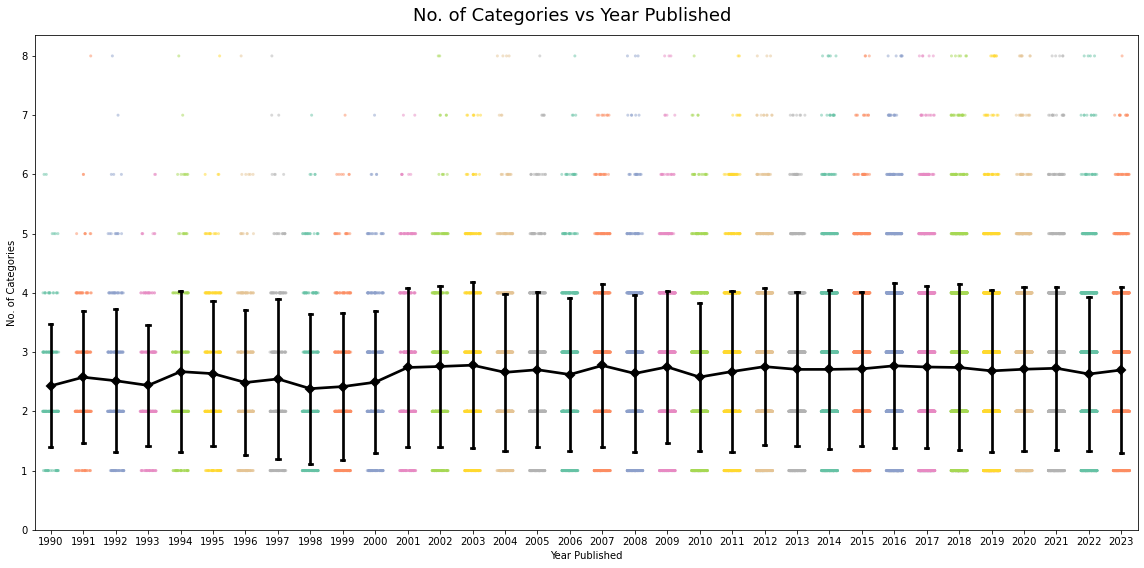

In [104]:
fig, ax = plt.subplots(figsize=(16,8))

sns.stripplot(
    data=bgg_year_category[bgg_year_category['year_published'].between(1990, 2023)
                            & (bgg_year_category['no_category'] <= 8)],
    x='year_published',
    y='no_category',
    hue='year_published',
    palette='Set2',
    alpha=0.5,
    jitter=0.25,
    s=3,
    zorder=1
)

sns.pointplot(
    data=bgg_year_category[bgg_year_category['year_published'].between(1990, 2023)
                            & (bgg_year_category['no_category'] <= 8)],
    x='year_published',
    y='no_category',
    estimator='mean',
    errorbar='sd',
    marker='D',
    capsize=0.1,
    color='k',
    scale=1,
)

fig.suptitle('No. of Categories vs Year Published', size=18)
ax.set_ylabel('No. of Categories')
ax.set_xlabel('Year Published')
ax.set_yticks(np.arange(0,9,1))

ax.legend().set_visible(False)

plt.tight_layout()

* The number of categories has also remained constant over the past 30 years. 

#### 7.1.6 Mechanics Adoption Trends <a id="mechanics_adoption"></a>

In [105]:
bgg_mechanics_decade = pd.merge(bgg_classification[bgg_classification['classification'] == 'boardgamemechanic'], 
                                bgg_ranked[['bgg_id', 'year_published']],
                                on='bgg_id',
                                how='right',
)

bgg_mechanics_decade = bgg_mechanics_decade.drop('classification', axis=1)
bgg_mechanics_decade.columns = ['bgg_id', 'mechanic', 'year_published']
bgg_mechanics_decade = bgg_mechanics_decade.value_counts(['mechanic', 'year_published']).reset_index(name='count')
bgg_mechanics_decade['decade'] = pd.cut(bgg_mechanics_decade['year_published'], 
                                        bins=[-np.inf, 1990, 2000, 2010, 2020], 
                                        labels=[1990, 2000, 2010, 2020],
                                       )
bgg_mechanics_decade = bgg_mechanics_decade.dropna()

bgg_mechanics_decade_count = bgg_mechanics_decade.groupby('decade')['count'].sum()
bgg_mechanics_decade = bgg_mechanics_decade.groupby(['mechanic', 'decade'])['count'].sum().reset_index()

bgg_mechanics_decade['percentage'] = bgg_mechanics_decade[['decade', 'count']].apply(
    lambda row: round(100*row['count']/bgg_mechanics_decade_count.loc[row['decade']],1),
    axis=1
)

for mechanic, df in bgg_mechanics_decade.groupby('mechanic'):
    x = float(df[df['decade'] == 2020]['percentage'])
    y = float(df[df['decade'] == 1990]['percentage'])
    
    bgg_mechanics_decade.loc[bgg_mechanics_decade['mechanic'].isin([mechanic]), 'diff'] = round(x-y,2)
    
bgg_mechanics_decade = bgg_mechanics_decade.sort_values(['diff', 'mechanic'], ascending=False).reset_index(drop=True)

bgg_mechanics_decade.head()


mechanic decade  count  percentage  diff
0         Hand Management   1990    182         2.0   6.1
1         Hand Management   2000    263         5.1   6.1
2         Hand Management   2010    960         7.4   6.1
3         Hand Management   2020   3118         8.1   6.1
4  Variable Player Powers   1990    149         1.6   3.3

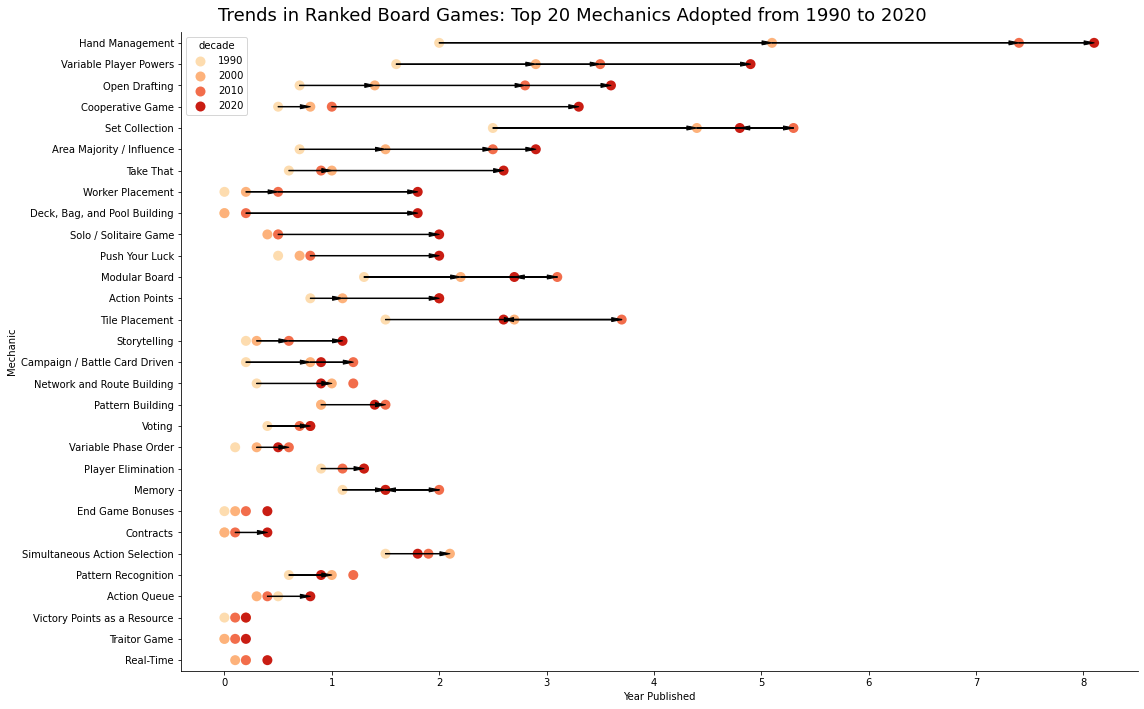

In [106]:
fig, ax = plt.subplots(figsize=(16,10))

sns.stripplot(
    data=bgg_mechanics_decade.head(120),
    x='percentage',
    y='mechanic',
    hue='decade',
    jitter=False,
    s=10,
    palette="OrRd",
    zorder=1,
)

for i, row in bgg_mechanics_decade.iterrows():
    if i==0:
        pass
    elif row['mechanic'] != bgg_mechanics_decade.iloc[i-1]['mechanic']:
        pass
    elif abs(row['percentage'] - bgg_mechanics_decade.iloc[i-1]['percentage']) < 0.3:
        pass
    else:
        ax.annotate(
            text='',
            xy=(row['percentage'], row['mechanic']),
            xytext=(bgg_mechanics_decade.iloc[i-1]['percentage'], 
                    bgg_mechanics_decade.iloc[i-1]['mechanic']),
            va='center',
            arrowprops=dict(
                facecolor='black',
                width=0.5,
                headwidth=4,
                headlength=10,
            ),
        )
        
fig.suptitle('Trends in Ranked Board Games: Top 20 Mechanics Adopted from 1990 to 2020', size=18)
ax.set_ylabel('Mechanic')
ax.set_xlabel('Year Published')

sns.despine()
plt.tight_layout()

* The adoption of mechanics such as `Hand Management`, `Variable Player Powers`, and `Open Drafting` has witnessed a notable increase in ranked board games. This surge in adoption could be attributed to board game designers opting to integrate greater player intervention, rather than relying predominantly on randomness throughout gameplay. `Hand Management`, as previously discussed, involves strategic decision-making by players when playing certain cards. `Open Drafting` involves players acquiring cards from a shared pool (e.g. 7 Wonders Duel, Ark Nova, Dune: Imperium). Conversely, `Variable Player Powers` involves players possessing distinct abilities and win conditions, thereby introducing more variability among players (e.g. Gloomhaven, Terraforming Mars, Pandemic Legacy).

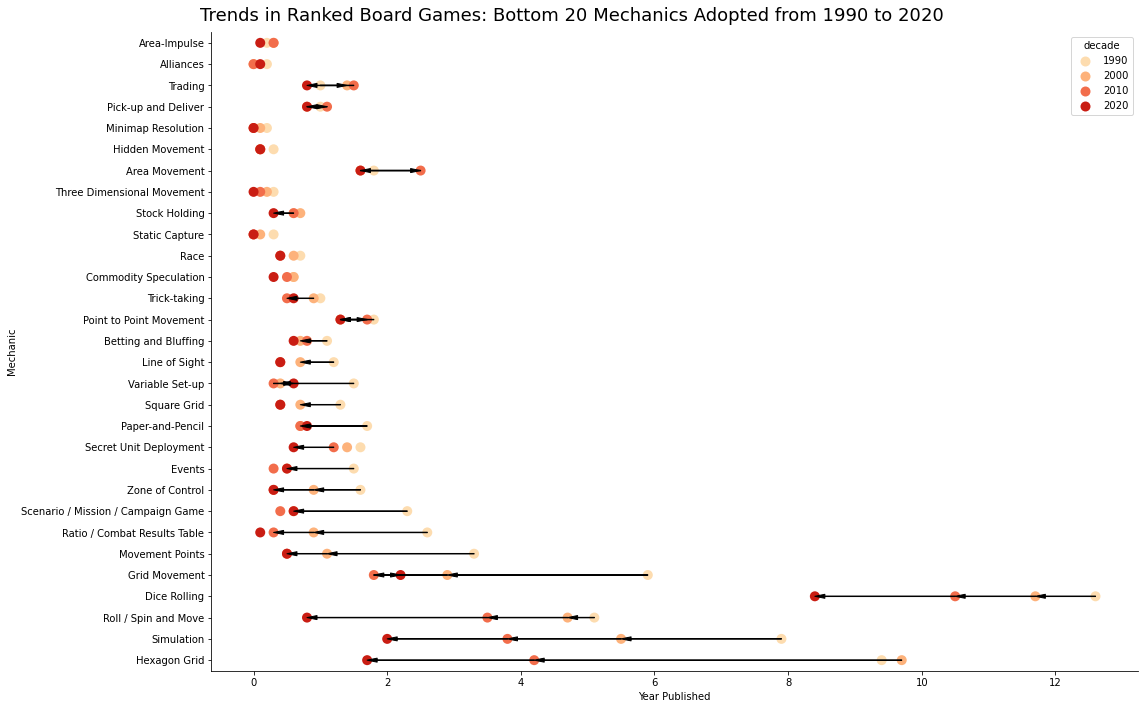

In [107]:
fig, ax = plt.subplots(figsize=(16,10))

sns.stripplot(
    data=bgg_mechanics_decade.tail(120),
    x='percentage',
    y='mechanic',
    hue='decade',
    jitter=False,
    s=10,
    palette="OrRd",
    zorder=1,
)

for i, row in bgg_mechanics_decade.iterrows():
    if i==0:
        pass
    elif row['mechanic'] != bgg_mechanics_decade.iloc[i-1]['mechanic']:
        pass
    elif abs(row['percentage'] - bgg_mechanics_decade.iloc[i-1]['percentage']) < 0.3:
        pass
    else:
        ax.annotate(
            text='',
            xy=(row['percentage'], row['mechanic']),
            xytext=(bgg_mechanics_decade.iloc[i-1]['percentage'], 
                    bgg_mechanics_decade.iloc[i-1]['mechanic']),
            va='center',
            arrowprops=dict(
                facecolor='black',
                width=0.5,
                headwidth=4,
                headlength=10,
            ),
        )
        
fig.suptitle('Trends in Ranked Board Games: Bottom 20 Mechanics Adopted from 1990 to 2020', size=18)
ax.set_ylabel('Mechanic')
ax.set_xlabel('Year Published')

sns.despine()
plt.tight_layout()

* The utilization of a `Hexagon Grid` involves employing hexagons as tiles in a map, enabling units to move in six directions. While this mechanic was prevalent in many classic war games, its adoption has diminished in recent years. `Simulation` is a mechanic that replicates real historical events, as seen in games like Twilight Struggle and Memoir '44. Although `Dice Rolling` and `Roll/Spin Move` have been common features in board games, their incorporation has also declined. This trend may be attributed to modern board games aiming to minimize random elements and emphasize player planning and interaction.

#### 7.1.7 Categories Adoption Trends <a id="categories_adoption"></a>

In [108]:
bgg_categories_decade = pd.merge(bgg_classification[bgg_classification['classification'] == 'boardgamecategory'], 
                                bgg_ranked[['bgg_id', 'year_published']],
                                on='bgg_id',
                                how='right',
)

bgg_categories_decade = bgg_categories_decade.drop('classification', axis=1)
bgg_categories_decade.columns = ['bgg_id', 'category', 'year_published']
bgg_categories_decade = bgg_categories_decade.value_counts(['category', 'year_published']).reset_index(name='count')
bgg_categories_decade['decade'] = pd.cut(bgg_categories_decade['year_published'], 
                                        bins=[-np.inf, 1990, 2000, 2010, 2020], 
                                        labels=[1990, 2000, 2010, 2020],
                                       )
bgg_categories_decade = bgg_categories_decade.dropna()

bgg_categories_decade_count = bgg_categories_decade.groupby('decade')['count'].sum()
bgg_categories_decade = bgg_categories_decade.groupby(['category', 'decade'])['count'].sum().reset_index()

bgg_categories_decade['percentage'] = bgg_categories_decade[['decade', 'count']].apply(
    lambda row: round(100*row['count']/bgg_categories_decade_count.loc[row['decade']],1),
    axis=1
)

for category, df in bgg_categories_decade.groupby('category'):
    x = float(df[df['decade'] == 2020]['percentage'])
    y = float(df[df['decade'] == 1990]['percentage'])
    
    bgg_categories_decade.loc[bgg_categories_decade['category'].isin([category]), 'diff'] = round(x-y,2)
    
bgg_categories_decade = bgg_categories_decade.sort_values(['diff', 'category'], ascending=False).reset_index(drop=True)

bgg_categories_decade.head()

category decade  count  percentage  diff
0  Card Game   1990    375         5.0   8.6
1  Card Game   2000    558         9.7   8.6
2  Card Game   2010   1458        10.4   8.6
3  Card Game   2020   4285        13.6   8.6
4    Fantasy   1990    196         2.6   3.0

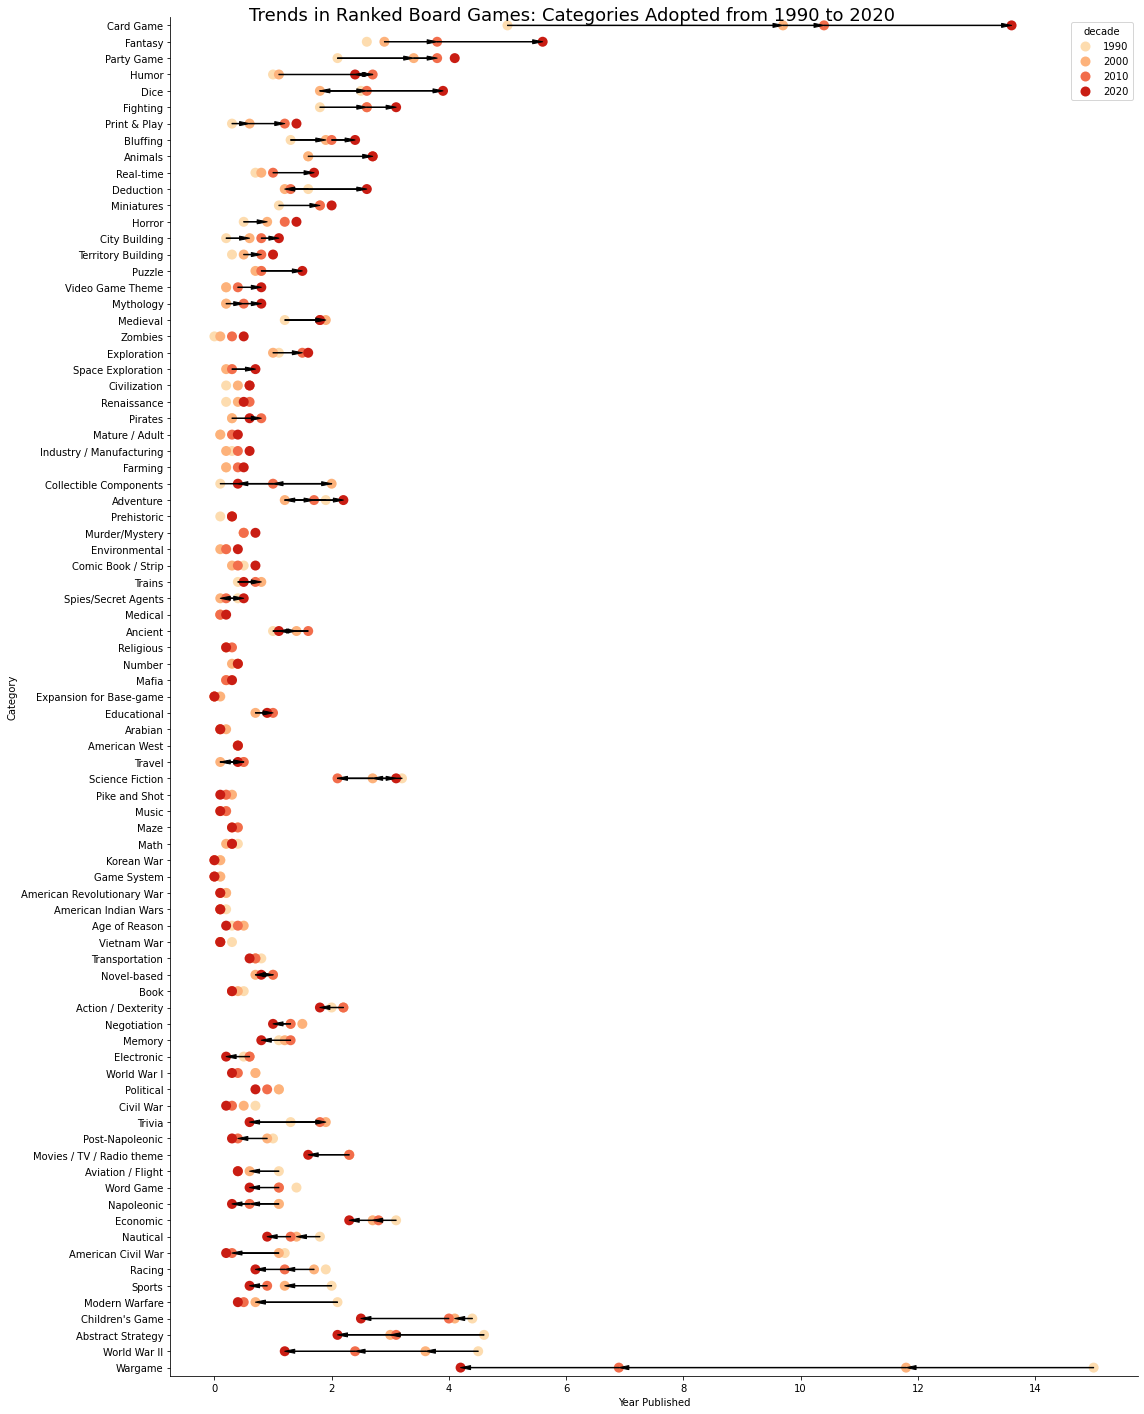

In [109]:
fig, ax = plt.subplots(figsize=(16,20))

sns.stripplot(
    data=bgg_categories_decade,
    x='percentage',
    y='category',
    hue='decade',
    jitter=False,
    s=10,
    palette="OrRd",
    zorder=1,
)

for i, row in bgg_categories_decade.iterrows():
    if i==0:
        pass
    elif row['category'] != bgg_categories_decade.iloc[i-1]['category']:
        pass
    elif abs(row['percentage'] - bgg_categories_decade.iloc[i-1]['percentage']) < 0.3:
        pass
    else:
        ax.annotate(
            text='',
            xy=(row['percentage'], row['category']),
            xytext=(bgg_categories_decade.iloc[i-1]['percentage'], 
                    bgg_categories_decade.iloc[i-1]['category']),
            va='center',
            arrowprops=dict(
                facecolor='black',
                width=0.5,
                headwidth=4,
                headlength=10,
            ),
        )
        
fig.suptitle('Trends in Ranked Board Games: Categories Adopted from 1990 to 2020', size=18)
ax.set_ylabel('Category')
ax.set_xlabel('Year Published')

sns.despine()
plt.tight_layout()

*  There has been a significant surge in the adoption of `Card Games` as a category, aligning with earlier analyses that noted increased adoption of mechanics such as `Hand Management` and `Open Drafting.` For `Fantasy` games, which includes magical abilities and mythical creatures like orcs, trolls, and dragons, there has been a notable increase as well. This surge in `fantasy` games may be correlated with the decrease in the number of `simulation` games, as observed earlier, particularly evident in the decline of `Wargame` and `World War II` themed games. Additionally, `party games` are gaining traction due to their simple rules and easy setups, which are appealing for social interactions, as evident from their growing recognition.

### 7.2 Target Feature <a id="target_feature"></a>


Now that we have analysed how the features of board games have changed over the years, this section will examine how these features affect the overall rating of a board game. We will focus on average rating instead of geek rating since it has a more pronounced distribution compared to geek rating wherein most values are concentrated around 5.5.

#### 7.2.1 Data Filter <a id="data_filter"></a>

In [663]:
bgg_ranked = bgg_ranked[bgg_ranked['users_rated'] > 125].reset_index(drop=True)
bgg_ranked.shape

(12704, 23)

* To have a more representative collection, ranked board games are further filtered to include only games with minimum user ratings greater than to the median value (125) of `users_rated`. The data filter shows that the collection was reduced from 25521 to 12704 games.

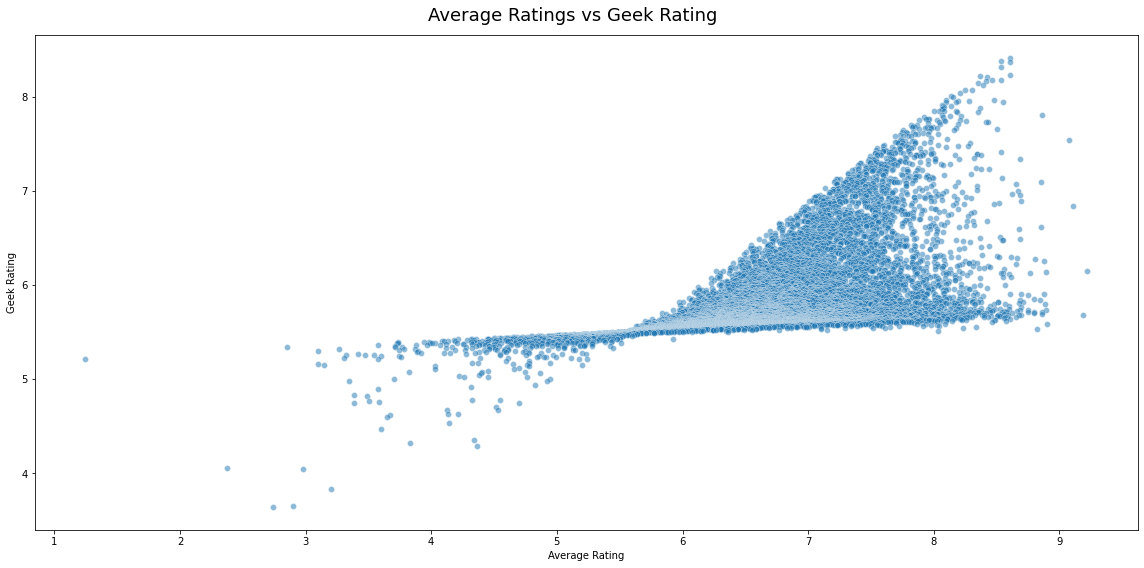

In [592]:
fig, ax = plt.subplots(figsize=(16,8))

coeff, p_value = stats.pearsonr(bgg_ranked['average'], bgg_ranked['bayes_average'])

sns.scatterplot(
    ax=ax,
    data=bgg_ranked,
    x='average',
    y='bayes_average',
    alpha=0.5,
)


fig.suptitle('Average Ratings vs Geek Rating', size=18)
ax.set_ylabel('Geek Rating')
ax.set_xlabel('Average Rating')

plt.tight_layout()

* The plot above illustrates that the majority of geek ratings cluster around the 5.5 value as seen earlier in the distribution of geek rating. However, there are also data points that exhibit a positive linear correlation with the average rating. Further exploration in the multivariate analysis will help identify when a linear relationship exists between the geek and average ratings of a board game.

### 7.3 Feature Correlations <a id="feature_correlations"></a>

In [593]:
bgg_corr = bgg_ranked.drop(['bgg_id', 'bgg_type', 'name', 'img_src', 'description','year_published',
                            'subdomain_1', 'subdomain_1_rank', 'subdomain_2', 'subdomain_2_rank', 
                            'bgg_rank', 'playing_time'], axis=1).corr()

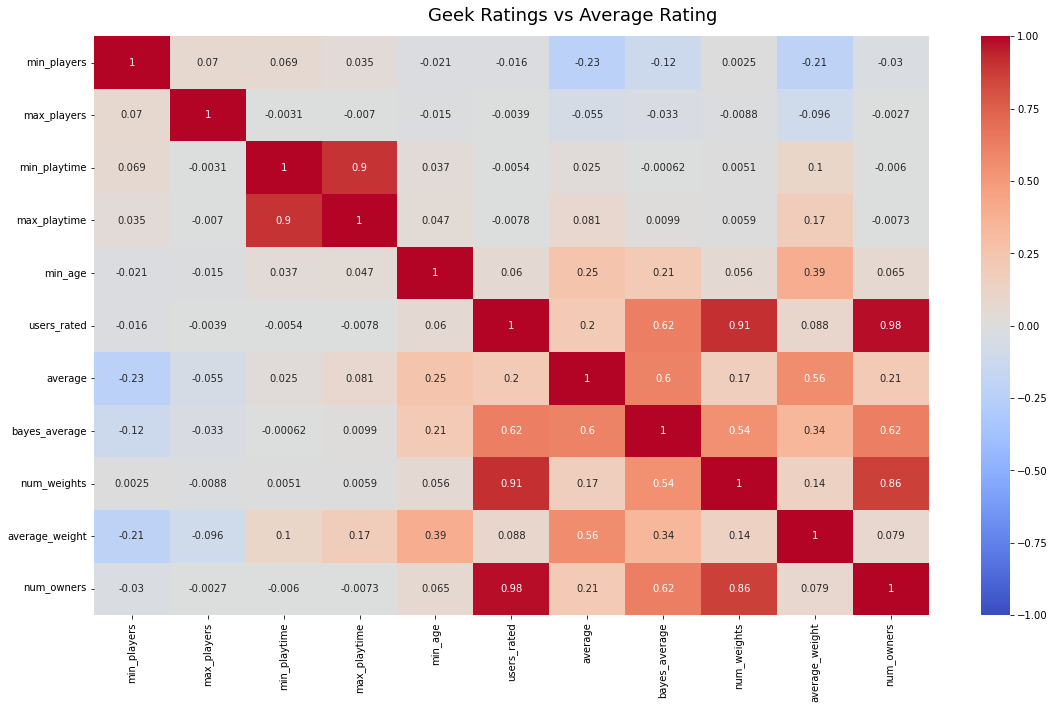

In [594]:
fig, ax = plt.subplots(figsize=(16,10))

sns.heatmap(bgg_corr, vmin=-1, vmax=1, annot=True, cmap='coolwarm')

fig.suptitle('Geek Ratings vs Average Rating', size=18)

plt.tight_layout()

* The correlation plot shows that `average_weight` and `average` rating of a board game has a correlation coefficient of 0.56, followed by `min_age` (0.25) and `num_owners`(0.21). These findings suggest that members of the BGG community assigns higher ratings to board games that are more complex. The complexity of a board game may be attributed to presence of certain mechanics or number of mechanics, which warrants further investigation. It can also be observed that `users_rated` and `num_owners` have almost the same correlation coefficient, implying that these values can serve as proxies for popularity, as discussed earler.

### 7.4 Features vs Average Rating (Target Feature) <a id="features_vs_target"></a>

#### 7.4.1 Weight <a id="weight_target_bivariate"></a>

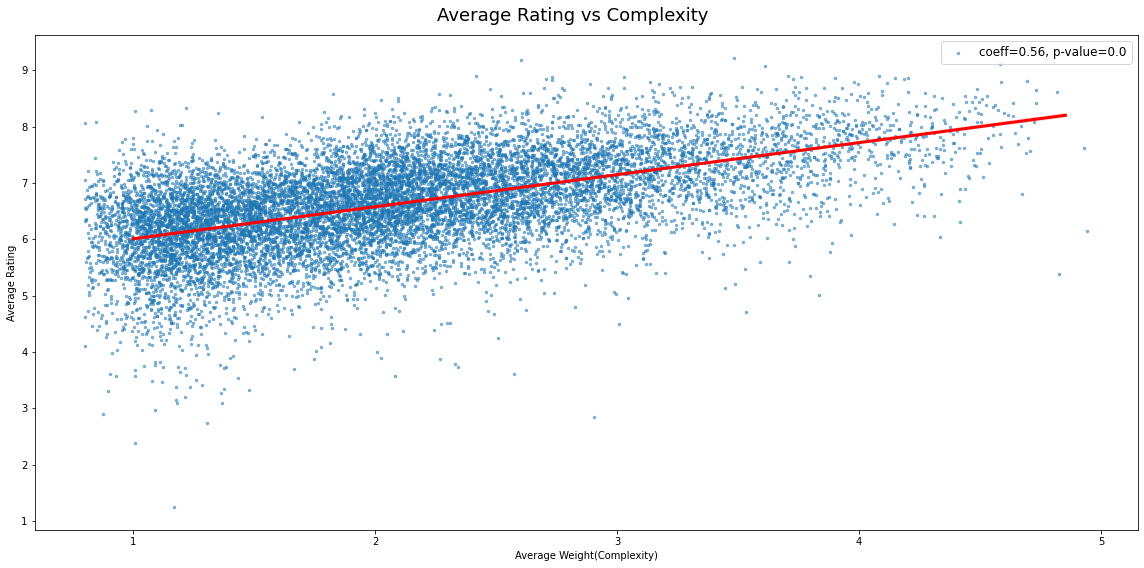

In [1096]:
fig, ax = plt.subplots(figsize=(16,8))

coeff, p_value = stats.pearsonr(bgg_ranked['average_weight'], bgg_ranked['average'])

sns.regplot(
    data=bgg_ranked[bgg_ranked['average_weight'] > 0],
    x='average_weight',
    y='average',
    line_kws=dict(
        color='r',
        lw=3
    ),
    scatter_kws=dict(
        alpha=0.5,
        s=6,
        zorder=1
    ),
    x_jitter=0.2,
    label=f'coeff={round(coeff,3)}, p-value={round(p_value,3)}'
)

ax.legend(fontsize=12).set_visible(True)

fig.suptitle('Average Rating vs Complexity', size=18)
ax.set_ylabel('Average Rating')
ax.set_xlabel('Average Weight(Complexity)')

plt.tight_layout()

* As shown, there is a moderate positive relationship between average rating and complexity. It's important to note that members of the BGG community may not necessarily represent the entirety of board game players; rather, they often embody board game enthusiasts who actively collect and review board games, rather than being casual gamers.

#### 7.4.2 Number of Owners <a id="no_owners_bivariate"></a>

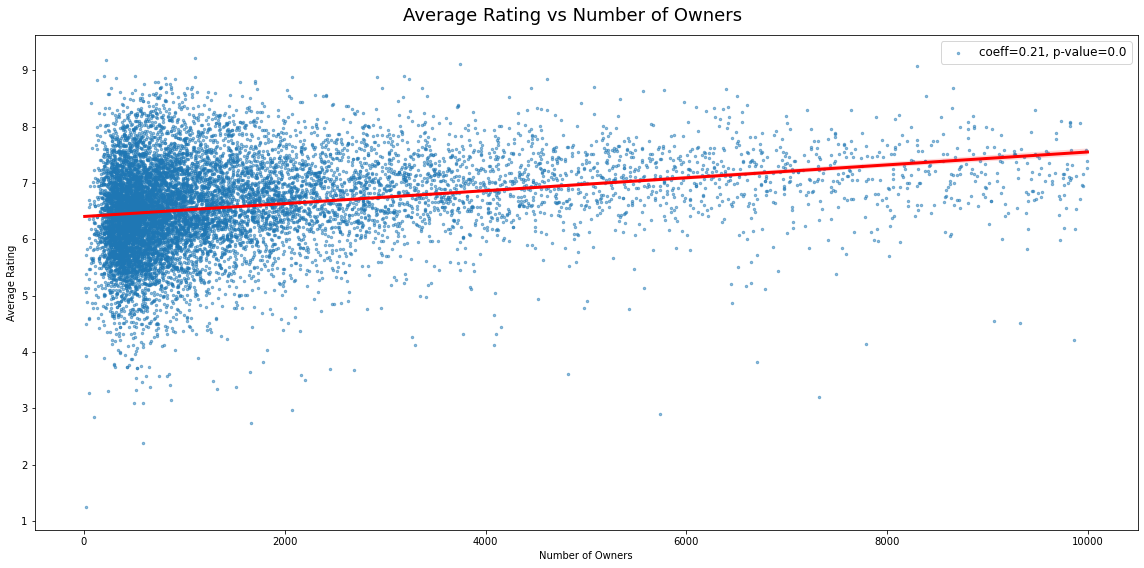

In [1095]:
fig, ax = plt.subplots(figsize=(16,8))

coeff, p_value = stats.pearsonr(bgg_ranked['num_owners'], bgg_ranked['average'])

sns.regplot(
    data=bgg_ranked[bgg_ranked['num_owners'] < 10000],
    x='num_owners',
    y='average',
    line_kws=dict(
        color='r',
        lw=3
    ),
    scatter_kws=dict(
        alpha=0.5,
        s=6,
        zorder=1
    ),
    x_jitter=0.2,
    label=f'coeff={round(coeff,3)}, p-value={round(p_value,3)}'
)

ax.legend(fontsize=12).set_visible(True)

fig.suptitle('Average Rating vs Number of Owners', size=18)
ax.set_ylabel('Average Rating')
ax.set_xlabel('Number of Owners')

plt.tight_layout()

* The low correlation between average rating and number of owners suggests that popular games may be well received by board game players in general.

#### 7.4.3 Minimum Age <a id="minimum_age_bivariate"></a>

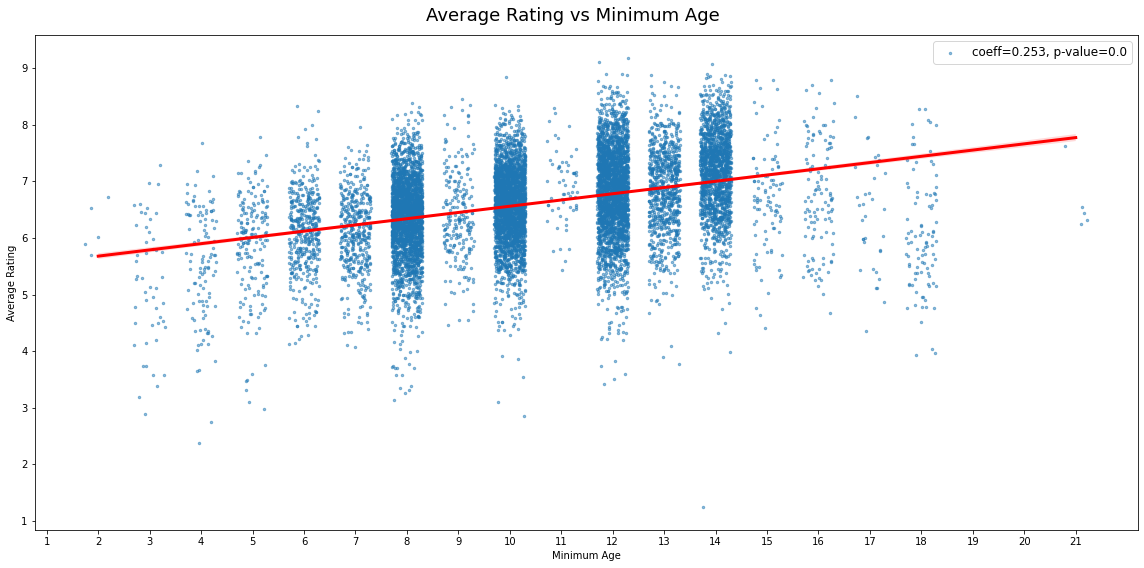

In [597]:
fig, ax = plt.subplots(figsize=(16,8))

coeff, p_value = stats.pearsonr(bgg_ranked['min_age'], bgg_ranked['average'])

sns.regplot(
    data=bgg_ranked[bgg_ranked['min_age'] > 0],
    x='min_age',
    y='average',
    line_kws=dict(
        color='r',
        lw=3
    ),
    scatter_kws=dict(
        alpha=0.5,
        s=6,
        zorder=1
    ),
    x_jitter=0.3,
    label=f'coeff={round(coeff,3)}, p-value={round(p_value,3)}'
)

ax.legend(fontsize=12)
ax.set_xticks(np.arange(1,22,1))

fig.suptitle('Average Rating vs Minimum Age', size=18)
ax.set_ylabel('Average Rating')
ax.set_xlabel('Minimum Age')

plt.tight_layout()

* Minimum age can be attributed also to the level of complexity of the game and the correlation coefficient of 0.253 shows that higher values of minimum age (more complex games) tend to have higher ratings.

#### 7.4.4 Minimum Players <a id="minimum_players_bivariate"></a>

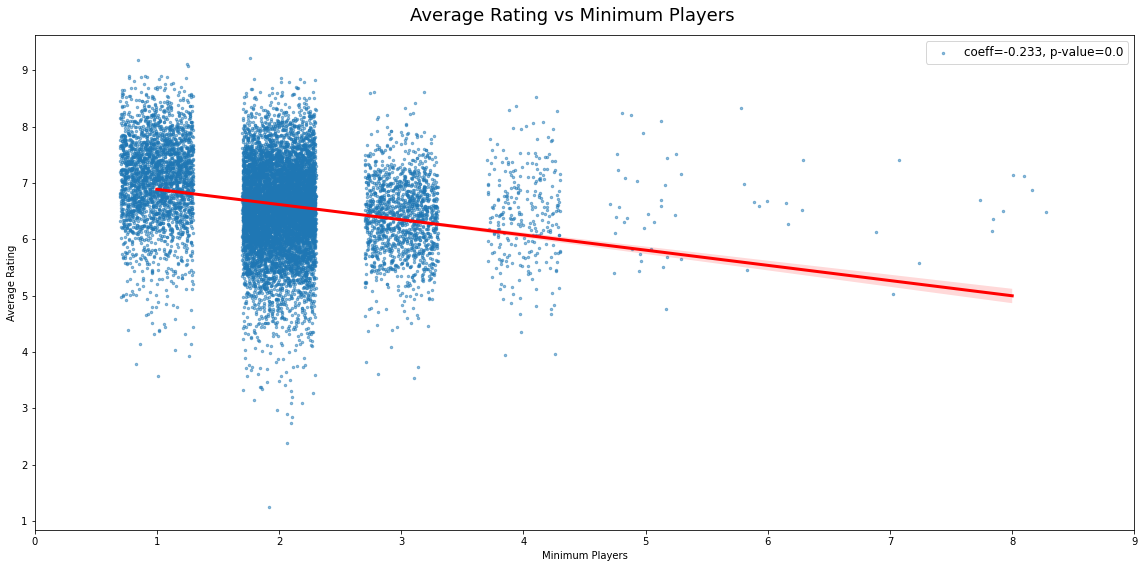

In [598]:
fig, ax = plt.subplots(figsize=(16,8))

coeff, p_value = stats.pearsonr(bgg_ranked['min_players'], bgg_ranked['average'])

sns.regplot(
    data=bgg_ranked[bgg_ranked['min_players'] > 0],
    x='min_players',
    y='average',
    line_kws=dict(
        color='r',
        lw=3
    ),
    scatter_kws=dict(
        alpha=0.5,
        s=6,
        zorder=1
    ),
    x_jitter=0.3,
    label=f'coeff={round(coeff,3)}, p-value={round(p_value,3)}'
)

ax.legend(fontsize=12)
ax.set_xticks(np.arange(0,10,1))

fig.suptitle('Average Rating vs Minimum Players', size=18)
ax.set_ylabel('Average Rating')
ax.set_xlabel('Minimum Players')

plt.tight_layout()

* The negative correlation observed (-0.233) between the minimum number of players and average ratings suggests that board games with higher minimum player counts tend to receive lower ratings. This trend may be attributed to the fact that higher player counts often indicate games that emphasize short but highly interactive party experiences. Additionally, it's possible that the population of BGG users consists primarily of players who are more engaged with long and strategic games, rather than those that promote social interaction.

#### 7.4.5 No. of Mechanics <a id="no_of_mechanics_bivariate"></a>

In [599]:
bgg_rating_mechanics = pd.merge(bgg_ranked[['bgg_id', 'average']], bgg_no_mechanics, on='bgg_id', how='left').dropna()

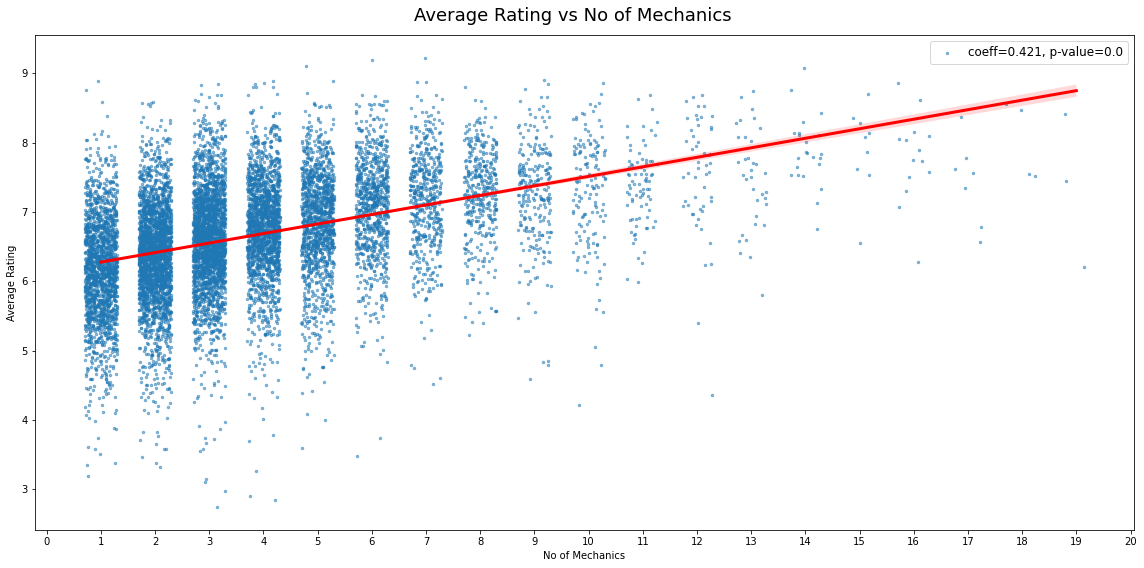

In [600]:
fig, ax = plt.subplots(figsize=(16,8))

coeff, p_value = stats.pearsonr(bgg_rating_mechanics['no_mechanics'], bgg_rating_mechanics['average'])

sns.regplot(
    data=bgg_rating_mechanics[bgg_rating_mechanics['no_mechanics'] < 20],
    x='no_mechanics',
    y='average',
    line_kws=dict(
        color='r',
        lw=3
    ),
    scatter_kws=dict(
        alpha=0.5,
        s=6,
        zorder=1
    ),
    x_jitter=0.3,
    label=f'coeff={round(coeff,3)}, p-value={round(p_value,3)}'
)

ax.legend(fontsize=12)
ax.set_xticks(np.arange(0,21,1))

fig.suptitle('Average Rating vs No of Mechanics', size=18)
ax.set_ylabel('Average Rating')
ax.set_xlabel('No of Mechanics')

plt.tight_layout()

* The plot above shows that the no. of mechanics, which can also refer to board game complexity, has a moderate positive correlation with the average rating. Interaction between mechanics of board games allows for a more dynamic and sophisticated game play which appeals to the members of BGG. 

The succeeding tables show the mechanics with the highest and lowest average rating.

#### 7.4.6 Average Rating of Mechanics <a id="rating_mechanics_bivariate"></a>

In [769]:
bgg_mechanics_rating = pd.merge(
    bgg_ranked[['bgg_id', 'average']],
    bgg_classification[bgg_classification['classification'] == 'boardgamemechanic'],
    on='bgg_id',
    how='right'
).dropna().drop(['classification'], axis=1)

bgg_mechanics_rating = bgg_mechanics_rating.groupby('value').agg({
    'bgg_id': 'count',
    'average': 'mean'
}).sort_values('average', ascending=False).reset_index()

bgg_mechanics_rating.columns = ['mechanic', 'count', 'average']

#filter for median count
bgg_mechanics_rating = bgg_mechanics_rating[bgg_mechanics_rating['count'] > bgg_mechanics_rating['count']\
                                            .median()]

bgg_mechanics_rating.head(20)

mechanic  count   average
3                   Tech Trees / Tech Tracks     96  7.585316
6   Worker Placement, Different Worker Types     98  7.503445
7               Narrative Choice / Paragraph     74  7.502222
9                   Turn Order: Claim Action     69  7.460874
13                         Deck Construction     78  7.429831
14             Card Play Conflict Resolution    132  7.426176
18                          Chit-Pull System    121  7.392577
20                             Line of Sight    202  7.384029
22                           Action Drafting     59  7.379857
23                                    Market    133  7.375607
24        Scenario / Mission / Campaign Game    436  7.366122
25              Victory Points as a Resource    120  7.362965
26                          End Game Bonuses    318  7.358234
27                                    Income    158  7.354437
28                    Turn Order: Stat-Based     78  7.345245
30                     Solo / Solitaire Game   1064  7.334947
33                          Action Retrieval     77  7.321322
37                                 Ownership     69  7.307136
38                           Multi-Use Cards     71  7.302488
40                           Variable Set-up    425  7.292322

In [771]:
bgg_mechanics_rating.tail(20)

mechanic  count   average
154               Real-Time    178  6.676598
155     Pick-up and Deliver    432  6.672643
156        Paper-and-Pencil    387  6.671057
157               Take That    818  6.644393
160          Push Your Luck    698  6.631057
162            Trick-taking    221  6.600406
163   Commodity Speculation    187  6.595100
164         Auction/Bidding    731  6.593229
166        Pattern Building    572  6.577268
167          Set Collection   2116  6.556660
169                  Voting    287  6.519808
170    Betting and Bluffing    265  6.466547
171      Player Elimination    456  6.461175
173                 Trading    361  6.395500
177                  Memory    488  6.342276
178  Stacking and Balancing     77  6.308647
179                  Acting    132  6.302494
180     Rock-Paper-Scissors     94  6.260031
181     Pattern Recognition    301  6.251206
188    Roll / Spin and Move    600  5.733107

* `Tech Trees / Tech Tracks` refers to in-game actions becoming available as the game advances. Similarly, `Worker Placement, Different Worker Types` is the placement of workers in different areas of the game which can have varying abilities. `Narrative Choice / Paragraph` is a type of mechanic that presents options to players via a narative format. The top three mechanics reinforced our analysis that board games with strategic themes, long-term planning, and decision-making have been a major factor in garnering high ratings. 

* Party game mechanics (`Rock-Paper-Scissors`, `Acting`, `Stacking and Balancing`) or games that rely heavily on mechanics that promote luck (`Roll / Spin Move`) have the lowest average rating as expected.

#### 7.4.7 Change in Rating due to Incorporation of Mechanics <a id="change_rating_mechanics_bivariate"></a>

In [53]:
#Isolate mechanics of ranked boardgames
ranked_mechanics_count = pd.merge(bgg_ranked['bgg_id'],
         bgg_classification[bgg_classification['classification'] == 'boardgamemechanic'],
         on='bgg_id',
         how='left').dropna().groupby('value', as_index=False)['bgg_id'].count().rename(columns={'bgg_id':'count'})

#Identify representative mechanics by filtering with minimum number of board games > median count
mechanics_rep = ranked_mechanics_count[ranked_mechanics_count['count'] >= ranked_mechanics_count['count']\
                                       .median()]['value']


#Dataframe with bgg_id and ranked board game mechanics as columns
bgg_id_mechanics = bgg_classification[bgg_classification['classification'] == 'boardgamemechanic']
bgg_mechanics_pivot = bgg_id_mechanics[bgg_id_mechanics['value'].isin(mechanics_rep)]\
.pivot_table(index='bgg_id', columns='value',aggfunc='count', fill_value=0)
bgg_mechanics_pivot.columns = bgg_mechanics_pivot.columns.droplevel(0)
bgg_mechanics_pivot.columns.name = None
bgg_mechanics_pivot = bgg_mechanics_pivot.reset_index()

bgg_mechanics_pivot.head(3)

bgg_id  Acting  Action Drafting  Action Points  Action Queue  \
0      1       0                0              0             0   
1     10       0                0              0             0   
2   1000       0                0              0             0   

   Action Retrieval  Action/Event  Area Majority / Influence  Area Movement  \
0                 0             0                          1              0   
1                 0             0                          0              0   
2                 0             0                          0              0   

   Area-Impulse  Auction/Bidding  Betting and Bluffing  \
0             0                1                     0   
1             0                0                     0   
2             0                1                     0   

   Campaign / Battle Card Driven  Card Play Conflict Resolution  \
0                              0                              0   
1                              0                              0   
2                              0                              0   

   Chit-Pull System  Closed Drafting  Commodity Speculation  \
0                 0                0                      0   
1                 0                0                      0   
2                 0                0                      0   

   Communication Limits  Connections  Contracts  Cooperative Game  \
0                     0            0          0                 0   
1                     0            0          0                 0   
2                     0            0          0                 0   

   Deck Construction  Deck, Bag, and Pool Building  Deduction  Dice Rolling  \
0                  0                             0          0             1   
1                  0                             0          0             0   
2                  0                             0          0             1   

   Die Icon Resolution  Enclosure  End Game Bonuses  Events  Grid Coverage  \
0                    0          0                 0       0              0   
1                    0          0                 0       0              0   
2                    0          0                 0       0              0   

   Grid Movement  Hand Management  Hexagon Grid  Hidden Movement  \
0              0                1             0                0   
1              0                1             0                0   
2              0                0             0                0   

   Hidden Roles  Income  Layering  Line Drawing  Line of Sight  Map Addition  \
0             0       0         0             0              0             0   
1             0       0         0             0              0             0   
2             0       0         0             0              0             0   

   Market  Measurement Movement  Memory  Modular Board  Move Through Deck  \
0       0                     0       0              0                  0   
1       0                     0       0              0                  0   
2       0                     0       0              0                  0   

   Movement Points  Multi-Use Cards  Narrative Choice / Paragraph  \
0                0                0                             0   
1                0                0                             0   
2                0                0                             0   

   Negotiation  Network and Route Building  Once-Per-Game Abilities  \
0            0                           0                        0   
1            0                           1                        0   
2            0                           0                        0   

   Open Drafting  Paper-and-Pencil  Pattern Building  Pattern Recognition  \
0              0                 0                 0                    0   
1              1                 0                 0                    0   
2              0                 0                 0          

In [719]:
#include average rating and bgg rank in the dataframe
bgg_ranked_mechanics = pd.merge(bgg_ranked[['bgg_id', 'name', 'bgg_rank','average']], 
                                bgg_mechanics_pivot, 
                                on='bgg_id', 
                                how='left').dropna()

#Solve for regression coefficients
Y = bgg_ranked_mechanics['average']
X = sm.add_constant(bgg_ranked_mechanics[bgg_ranked_mechanics.columns[4:]])

model = sm.OLS(Y, X)
results = model.fit()

mechanics_rating_df = results.summary2().tables[1]
mechanics_rating_df = mechanics_rating_df.sort_values('Coef.', ascending=False)

mechanics_rating_df.head()

Coef.  Std.Err.           t         P>|t|  \
const                          6.284895  0.013384  469.583986  0.000000e+00   
Deck Construction              0.434675  0.075076    5.789819  7.221349e-09   
Card Play Conflict Resolution  0.399584  0.058632    6.815113  9.865985e-12   
Market                         0.380628  0.060140    6.329011  2.554555e-10   
Deck, Bag, and Pool Building   0.379256  0.027728   13.677787  2.841864e-42   

                                 [0.025    0.975]  
const                          6.258660  6.311129  
Deck Construction              0.287514  0.581835  
Card Play Conflict Resolution  0.284656  0.514512  
Market                         0.262744  0.498513  
Deck, Bag, and Pool Building   0.324905  0.433607

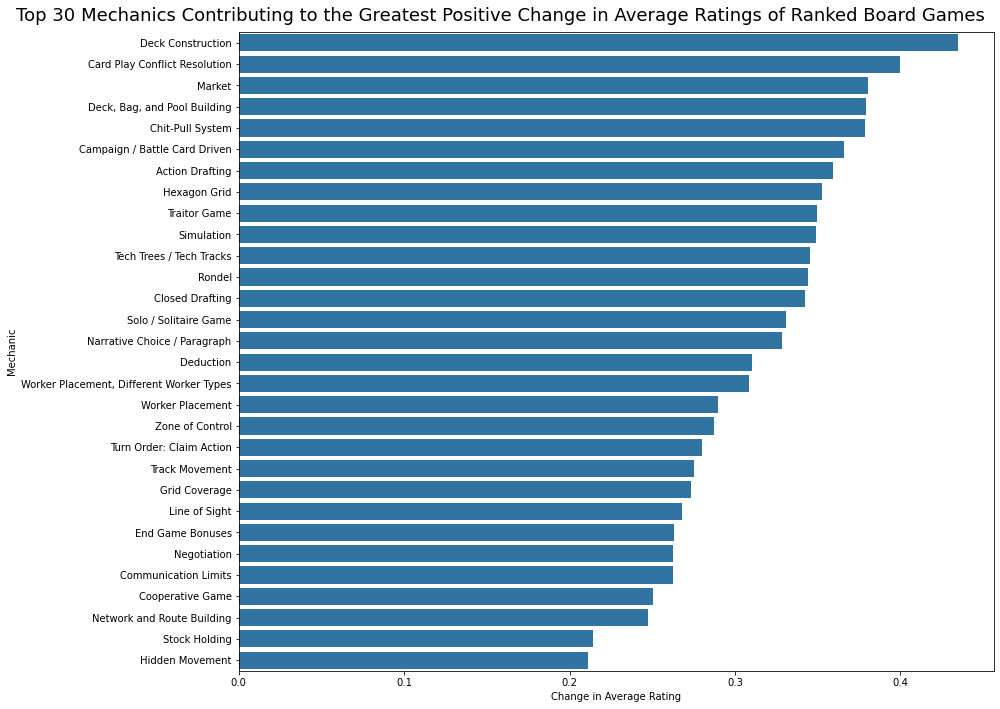

In [721]:
fig, ax = plt.subplots(figsize=(14,10))

sns.barplot(
    data=mechanics_rating_df[1:].head(30),
    y= mechanics_rating_df[1:].head(30).index,
    x= 'Coef.',
)

fig.suptitle('Top 30 Mechanics Contributing to the Greatest Positive Change in Average Ratings of Ranked Board Games',
             size=18)
ax.set_ylabel('Mechanic')
ax.set_xlabel('Change in Average Rating')

plt.tight_layout()

* Given that `Hand Management` is the most prevalent mechanic and `Card Game` has seen substantial adoption since 1990, it's notable that the mechanics contributing the most to the positive change in average ratings are closely related to this aspect of gameplay. `Deck Construction` and `Card Play Conflict Resolution` involves creating a deck of cards and simultaneous play of cards that modifies an outcome or abilities within a game. `Market` mechanic allows player to buy and sell resources such as cards and tiles that are commonly seen in *Economic* type of games. 


* The top board games featuring the `Deck Construction` mechanic are presented below. Notably, the top six board games among them are ranked within the top 100 overall, reinforcing how the inclusion of deck construction mechanics positively influences average ratings. Additionally, the success of *Magic: The Gathering,* renowned as one of the most acclaimed deck construction games, further reinforces the positive impact of this mechanic on average ratings.

In [730]:
#Top board games with a Deck Construction Mechanic

bgg_ranked_mechanics[bgg_ranked_mechanics['Deck Construction'] != 0]\
.sort_values('bgg_rank', ascending=True).head(10)[['name', 'bgg_rank']]

name  bgg_rank
2                              Gloomhaven         3
7            Gloomhaven: Jaws of the Lion         8
26           Arkham Horror: The Card Game        27
37                             Frosthaven        38
40        Marvel Champions: The Card Game        41
70                     Android: Netrunner        71
155  The Lord of the Rings: The Card Game       156
156                  Magic: The Gathering       157
315             Summoner Wars: Master Set       316
383                       Mage Wars Arena       384

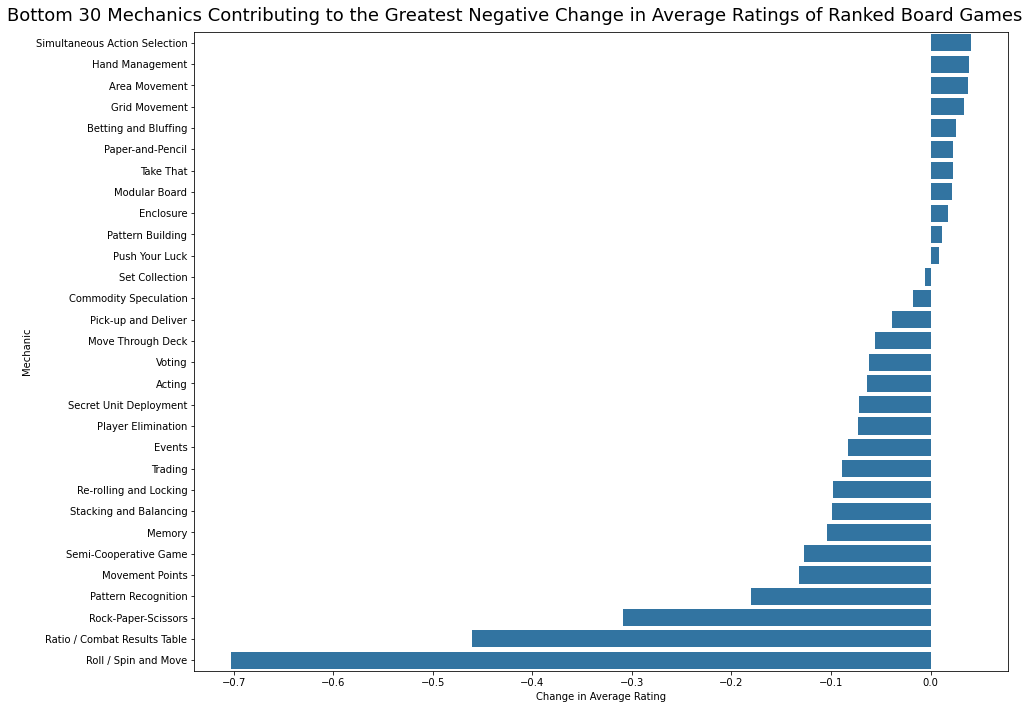

In [723]:
fig, ax = plt.subplots(figsize=(14,10))

sns.barplot(
    data=mechanics_rating_df[1:].tail(30),
    y= mechanics_rating_df[1:].tail(30).index,
    x= 'Coef.',
)

fig.suptitle('Bottom 30 Mechanics Contributing to the Greatest Negative Change in Average Ratings of Ranked Board Games',
             size=18)
ax.set_ylabel('Mechanic')
ax.set_xlabel('Change in Average Rating')

plt.tight_layout()

In [731]:
#Top board games with a Roll / Spin and Move Mechanic

bgg_ranked_mechanics[bgg_ranked_mechanics['Roll / Spin and Move'] != 0]\
.sort_values('bgg_rank', ascending=True).head(10)[['name', 'bgg_rank']]

name  bgg_rank
168   Xia: Legends of a Drift System       169
262        Camel Up (Second Edition)       263
483                   Stuffed Fables       484
569                         Camel Up       570
574        Runebound (Third Edition)       575
586                          Jamaica       587
602                        Colosseum       603
647                        HeroQuest       648
660                        Formula D       661
708  Escape: The Curse of the Temple       709

* *Camel Up* is an example of a luck based game where you throw a dice to determine the movement of camels in a race and bet on which camel is going to win. The randomness nature of these type of games contributes to the negative change in the rating of board games.

#### 7.4.8 Average Rating of Categories <a id="rating_categories_bivariate"></a>

In [760]:
bgg_categories_rating = pd.merge(
    bgg_ranked[['bgg_id', 'average']],
    bgg_classification[bgg_classification['classification'] == 'boardgamecategory'],
    on='bgg_id',
    how='right'
).dropna().drop(['classification'], axis=1)

bgg_categories_rating = bgg_categories_rating.groupby('value').agg({
    'bgg_id': 'count',
    'average': 'mean'
}).sort_values('average', ascending=False).reset_index()

bgg_categories_rating.columns = ['category', 'count', 'average']

bgg_categories_rating = bgg_categories_rating[bgg_categories_rating['count'] >= bgg_categories_rating['count']\
                                              .median()]

bgg_categories_rating.head(30)

category  count   average
6               World War II    529  7.254952
9                 Miniatures    728  7.249046
15                   Wargame   1689  7.107879
16              Civilization    286  7.082537
18  Industry / Manufacturing    255  7.011579
19                    Trains    253  6.988634
24                 Mythology    277  6.916136
26             City Building    475  6.897025
27                  Fighting   1110  6.882664
28                 Political    346  6.880759
29               Exploration    710  6.859051
30        Territory Building    437  6.854702
31                 Adventure    851  6.850212
32                   Fantasy   1883  6.846593
34           Science Fiction   1125  6.830523
35            Transportation    289  6.830430
36                   Ancient    503  6.825182
37                  Economic   1114  6.819215
38                  Medieval    678  6.804026
40                  Nautical    419  6.746720
42              Print & Play    322  6.734142
43                    Horror    488  6.726372
44                    Puzzle    517  6.726042
46                    Sports    251  6.706404
50          Video Game Theme    243  6.660705
55                 Deduction    781  6.586857
57                      Dice   1159  6.567536
59               Novel-based    330  6.534742
60                 Card Game   3953  6.510389
61               Negotiation    383  6.487683

* `Wargame` and `miniatures` are categories that are closely related since minatures are used to stage game scenarios such as warfare. On the other hand, `civilization` games focused on the development of society, either through warfare or diplomacy, and highly focused on managing resources to gain superiority. Indeed, these types of games align with the context of highly rated complex games, where strategic thinking and careful planning take precedence over luck-based games.

#### 7.4.9 Change in Rating due to Incorporation of Categories <a id="change_rating_categories_bivariate"></a>

In [55]:
#Isolate mechanics of ranked boardgames
ranked_categories_count = pd.merge(bgg_ranked['bgg_id'],
         bgg_classification[bgg_classification['classification'] == 'boardgamecategory'],
         on='bgg_id',
         how='left').dropna().groupby('value', as_index=False)['bgg_id'].count().rename(columns={'bgg_id':'count'})

#Identify representative mechanics by filtering with minimum number of board games > median count
categories_rep = ranked_categories_count[ranked_categories_count['count'] >= ranked_categories_count['count']\
                                       .median()]['value']


#Dataframe with bgg_id and ranked board game mechanics as columns
bgg_id_categories = bgg_classification[bgg_classification['classification'] == 'boardgamecategory']
bgg_categories_pivot = bgg_id_categories[bgg_id_categories['value'].isin(categories_rep)]\
.pivot_table(index='bgg_id', columns='value',aggfunc='count', fill_value=0)
bgg_categories_pivot.columns = bgg_categories_pivot.columns.droplevel(0)
bgg_categories_pivot.columns.name = None
bgg_categories_pivot = bgg_categories_pivot.reset_index()

bgg_categories_pivot.head(3)

bgg_id  Abstract Strategy  Action / Dexterity  Adventure  Ancient  Animals  \
0      1                  0                   0          0        0        0   
1     10                  0                   0          0        0        0   
2   1000                  1                   0          0        0        0   

   Bluffing  Card Game  Children's Game  City Building  Deduction  Dice  \
0         0          0                0              0          0     0   
1         0          0                0              0          0     0   
2         0          0                0              0          0     1   

   Economic  Educational  Exploration  Fantasy  Fighting  Horror  Humor  \
0         1            0            0        0         0       0      0   
1         0            0            0        1         0       0      0   
2         0            0            0        0         0       0      0   

   Medieval  Memory  Miniatures  Modern Warfare  Movies / TV / Radio theme  \
0         0       0           0               0                          0   
1         0       0           0               0                          0   
2         0       0           0               0                          0   

   Murder/Mystery  Mythology  Nautical  Negotiation  Novel-based  Party Game  \
0               0          0         0            1            0           0   
1               0          0         0            0            0           0   
2               0          0         0            0            0           0   

   Political  Print & Play  Puzzle  Racing  Real-time  Science Fiction  \
0          1             0       0       0          0                0   
1          0             0       0       0          0                0   
2          0             0       0       0          0                0   

   Sports  Territory Building  Transportation  Trivia  Wargame  Word Game  \
0       0                   0               0       0        0          0   
1       0                   0               0       0        0          0   
2       0                   0               0       0        0          0   

   World War II  
0             0  
1             0  
2             0

In [748]:
#include average rating and bgg rank in the dataframe
bgg_ranked_category = pd.merge(bgg_ranked[['bgg_id', 'name', 'bgg_rank','average']], 
                                bgg_categories_pivot, 
                                on='bgg_id', 
                                how='left').dropna()

#Solve for regression coefficients
Y = bgg_ranked_category['average']
X = sm.add_constant(bgg_ranked_category[bgg_ranked_category.columns[4:]])

model = sm.OLS(Y, X)
results = model.fit()

category_rating_df = results.summary2().tables[1]
category_rating_df = category_rating_df.sort_values('Coef.', ascending=False)

category_rating_df.head()

Coef.  Std.Err.           t         P>|t|    [0.025    0.975]
const         6.531617  0.016131  404.908032  0.000000e+00  6.499998  6.563237
Miniatures    0.392163  0.030568   12.829179  1.954090e-37  0.332245  0.452081
Trains        0.384659  0.050265    7.652605  2.116004e-14  0.286132  0.483187
World War II  0.357724  0.038015    9.410069  5.829913e-21  0.283208  0.432239
Wargame       0.347640  0.024506   14.185813  2.549962e-45  0.299604  0.395676

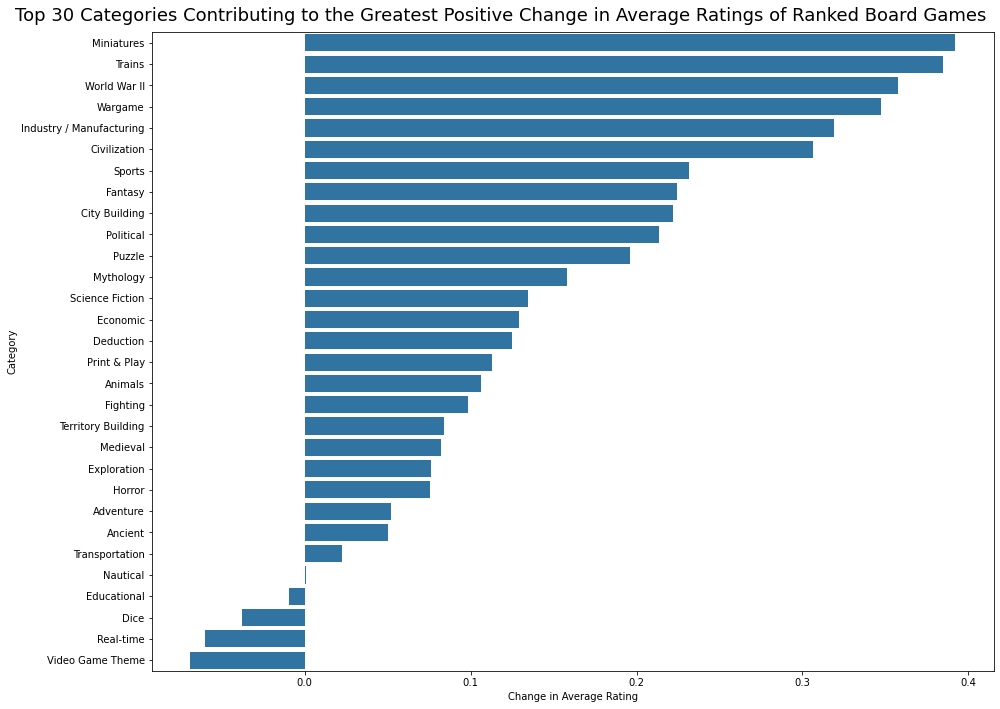

In [752]:
fig, ax = plt.subplots(figsize=(14,10))

sns.barplot(
    data=category_rating_df[1:].head(30), #Fan Expansion removed
    y= category_rating_df[1:].head(30).index,
    x= 'Coef.',
)

fig.suptitle('Top 30 Categories Contributing to the Greatest Positive Change in Average Ratings of Ranked Board Games',
             size=18)
ax.set_ylabel('Category')
ax.set_xlabel('Change in Average Rating')

plt.tight_layout()

In [753]:
bgg_ranked_category[bgg_ranked_category['Miniatures'] != 0]\
.sort_values('bgg_rank', ascending=True).head(10)[['name', 'bgg_rank']]

name  bgg_rank
2                                 Gloomhaven         3
7               Gloomhaven: Jaws of the Lion         8
9                       Star Wars: Rebellion        10
11                              Gaia Project        12
20                                   Nemesis        21
23  Clank! Legacy: Acquisitions Incorporated        24
32                    Mage Knight Board Game        33
37                                Frosthaven        38
45                                Blood Rage        46
55       Mansions of Madness: Second Edition        56

* The graph and table above shows how `miniature` and `wargame` categories contribute to the the greatest change in average rating. Furthermore, the top 10 games with `minature` categories are all within the top 100 BGG ranked games. On the other hand, games with under `trains` category are also highly rated with games like  *Brass: Birmingham* and *Ticket to Ride* and its expansions are commonly know far. 

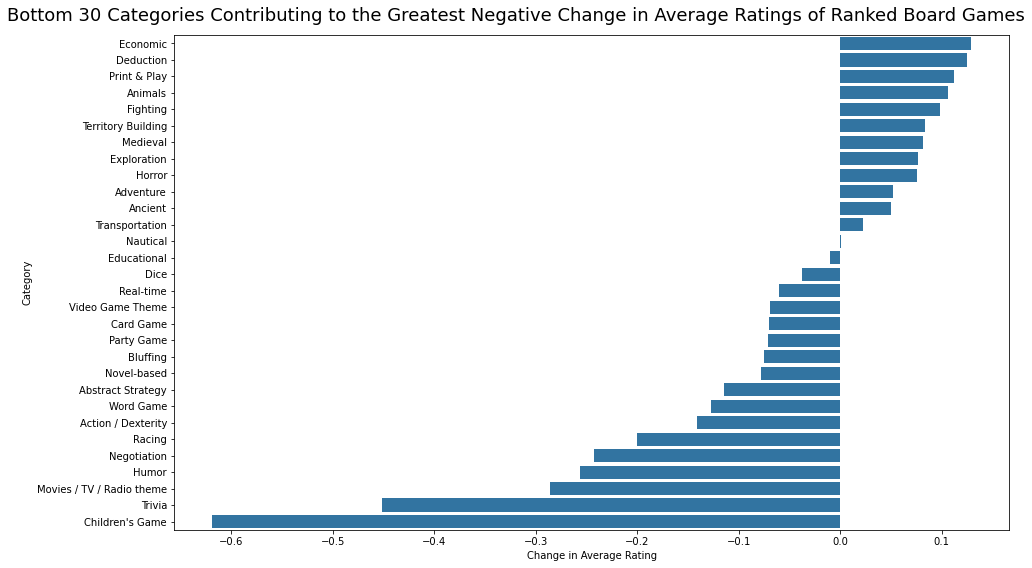

In [754]:
fig, ax = plt.subplots(figsize=(14,8))

sns.barplot(
    data=category_rating_df[1:].tail(30),
    y= category_rating_df[1:].tail(30).index,
    x= 'Coef.',
)

fig.suptitle('Bottom 30 Categories Contributing to the Greatest Negative Change in Average Ratings of Ranked Board Games',
             size=18)
ax.set_ylabel('Category')
ax.set_xlabel('Change in Average Rating')

plt.tight_layout()

* `Children's Game` appears to contribute the most to the negative change in average rating, likely because such games are not tailored for the audience that comprises the BGG community.

---
## 8. Multivariate Analysis <a id="multivariate_analysis"></a>

In this section, the contribution of two features to the average rating of board games will be explored to have a better understanding of their significance.

#### 8.1 Average Ratings vs (Geek Rating, Number of Ratings) <a id="geek_number_multivariate"></a>

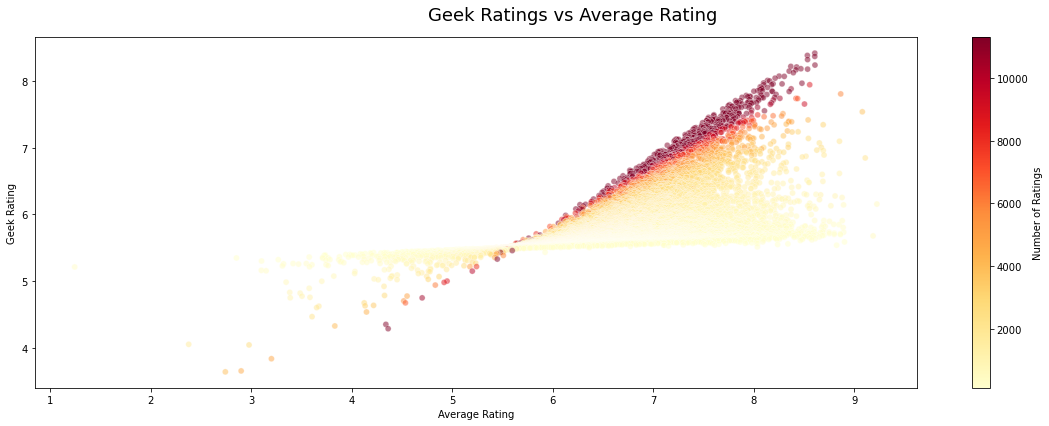

In [772]:
fig, ax= plt.subplots(figsize=(16,6))

sns.scatterplot(
    ax=ax,
    data=bgg_ranked,
    x='average',
    y='bayes_average',
    hue='users_rated',
    palette='YlOrRd',
    alpha=0.5,
    hue_norm=(bgg_ranked['users_rated'].min(), 
              bgg_ranked['users_rated'].quantile(0.97)),
    legend=False
)

#Add colorbar
norm = plt.Normalize(bgg_ranked['users_rated'].min(), bgg_ranked['users_rated'].quantile(0.97))
sm = plt.cm.ScalarMappable(cmap="YlOrRd", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, label='Number of Ratings')

fig.suptitle('Geek Ratings vs Average Rating', size=18)
ax.set_ylabel('Geek Rating')
ax.set_xlabel('Average Rating')

plt.tight_layout()

* A positive linear correlation between geek rating and average rating becomes evident when a specific board game receives more than 8000 votes. This aligns with the intended practice by BGG administrators, where the ratings of board games with only a few votes are intentionally adjusted to have lower values, preventing inflated average ratings based on minimal votes.

#### 8.2 Average Ratings vs (Weight, Number of Ratings) <a id="weight_number_multivariate"></a>

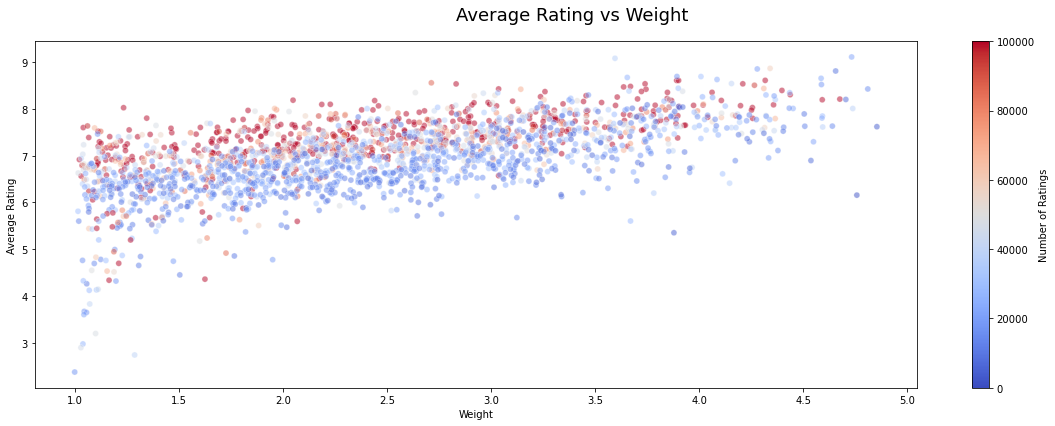

In [798]:
fig, ax= plt.subplots(figsize=(16,6))

sns.scatterplot(
    ax=ax,
    data=bgg_ranked[bgg_ranked['num_weights'] > 100], 
    x='average_weight',
    y='average',
    hue='users_rated',
    palette='coolwarm',
    alpha=0.5,
    hue_norm=(0, 
              10000),
    legend=False
)

#Add colorbar
norm = plt.Normalize(0, 100000)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, label='Number of Ratings')

fig.suptitle('Average Rating vs Weight', size=18)
ax.set_ylabel('Average Rating')
ax.set_xlabel('Weight')

plt.tight_layout()

* In the plot above, the number of votes continues to influence the ratings of board games. When considering both the complexity of the board game and the number of user votes, there is a noticeable distinction between the red and blue dots. Red dots represent games with a higher number of votes, given the same board game weight. This suggests that higher voter participation tends to correlate with higher ratings, even when adjusting for complexity.


#### 8.3 Average Ratings vs (Weight, Year Published) <a id="weight_year_multivariate"></a>

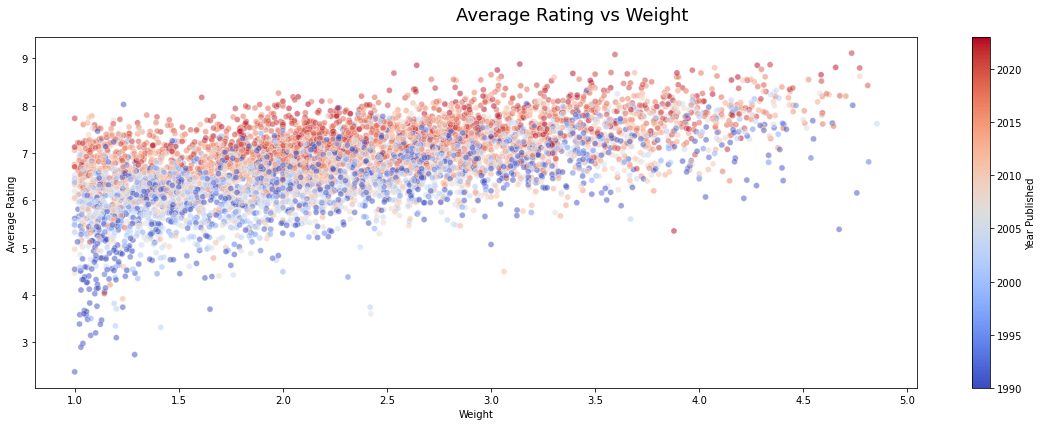

In [800]:
fig, ax= plt.subplots(figsize=(16,6))

sns.scatterplot(
    ax=ax,
    data=bgg_ranked[bgg_ranked['num_weights'] > bgg_ranked['num_weights'].median()], 
    x='average_weight',
    y='average',
    hue='year_published',
    palette='coolwarm',
    alpha=0.5,
    hue_norm=(1990, 
              2023),
    legend=False
)

#Add colorbar
norm = plt.Normalize(1990, 2023)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, label='Year Published')

fig.suptitle('Average Rating vs Weight', size=18)
ax.set_ylabel('Average Rating')
ax.set_xlabel('Weight')

plt.tight_layout()

* The scatterplot above also reflects the presence of recency bias, as observed in the bivariate analysis. It's apparent that more recent board games tend to receive higher ratings. The distinction between the red and blue dots indicates that the year of publication (`year_published`) divides the data points into higher and lower ratings, which is consistent across all weights.

#### 8.4 Average Ratings vs (Mechanics, Categories) <a id="mechanics_categories_multivariate"></a>

In [56]:
#Create dataframe with mechanic and category occurrence
df_mech = bgg_id_mechanics.drop('classification', axis=1)
df_cat = bgg_id_categories.drop('classification', axis=1)
df_mech_cat = pd.merge(df_mech,
        df_cat,
        on='bgg_id',
        how='inner').rename(columns={'value_x':'mechanic', 
                                     'value_y':'category'})
df_mech_cat = df_mech_cat[(df_mech_cat['mechanic'].isin(mechanics_rep)) & (df_mech_cat['category'].isin(categories_rep))]

#Dataframe consisting of mechanic and category occurence with other features
mech_cat_rating = pd.merge(bgg_ranked[['bgg_id', 'name','bgg_rank', 'average', 'bayes_average', 'average_weight', 
                                       'users_rated']],
                           df_mech_cat,
                           on='bgg_id',
                           how='left').dropna()

#Filter occurence of mechanic and category > median
mech_cat_count = mech_cat_rating.value_counts(['mechanic', 'category']).reset_index(name='count')
mech_cat_remove = mech_cat_count[mech_cat_count['count'] < mech_cat_count['count'].median()]
mech_cat_remove = [(row[1], row[2]) for row in mech_cat_remove[['mechanic', 'category']].itertuples()]
mech_cat_rating = mech_cat_rating[~mech_cat_rating[['mechanic', 'category']].apply(tuple, axis=1).isin(mech_cat_remove)]

#pivot to create mechanic vs category df with average rating as values
mech_cat_rating_pivot = mech_cat_rating.drop(['bgg_id', 'name','bgg_rank', 'bayes_average', 'average_weight', 
                                               'users_rated'], axis=1).pivot_table(index='mechanic',
                                                                           columns='category',
                                                                           aggfunc='mean')

In [57]:
mech_cat_rating_pivot.head()

average                                         \
category         Abstract Strategy Action / Dexterity Adventure   Ancient   
mechanic                                                                    
Acting                         NaN           5.789275       NaN       NaN   
Action Drafting                NaN                NaN       NaN       NaN   
Action Points             6.594134           6.591107  7.074991  6.927067   
Action Queue              6.455030                NaN  6.966069  6.784480   
Action Retrieval               NaN                NaN       NaN       NaN   

                                                                              \
category           Animals  Bluffing Card Game Children's Game City Building   
mechanic                                                                       
Acting            6.218673  6.242475  6.139575        5.808480           NaN   
Action Drafting        NaN       NaN  6.991768             NaN           NaN   
Action Points     6.639013  6.912076  6.898642             NaN      6.936345   
Action Queue      6.634570  6.658179  6.663923        6.053821           NaN   
Action Retrieval       NaN       NaN  6.898900             NaN           NaN   

                                                                        \
category         Deduction      Dice  Economic Educational Exploration   
mechanic                                                                 
Acting            6.363199       NaN       NaN         NaN         NaN   
Action Drafting        NaN       NaN  7.540353         NaN         NaN   
Action Points     6.990326  6.927839  6.841734    6.821534    7.058658   
Action Queue      6.611373  7.013477  7.158042         NaN    7.115749   
Action Retrieval       NaN       NaN  7.348391         NaN         NaN   

                                                                              \
category           Fantasy  Fighting    Horror     Humor  Medieval    Memory   
mechanic                                                                       
Acting                 NaN       NaN       NaN  6.247840       NaN  6.086269   
Action Drafting   7.239918       NaN       NaN       NaN       NaN       NaN   
Action Points     7.174967  7.210607  7.242728  6.363540  6.954912       NaN   
Action Queue      7.069551  7.033737       NaN  6.534389  7.197007       NaN   
Action Retrieval  7.509576       NaN       NaN       NaN       NaN       NaN   

                                                                      \
category         Miniatures Modern Warfare Movies / TV / Radio theme   
mechanic                                                               
Acting                  NaN            NaN                  5.788475   
Action Drafting         NaN            NaN                       NaN   
Action Points      7.384173       7.322519                  6.885108   
Action Queue       7.430764            NaN                       NaN   
Action Retrieval        NaN            NaN                       NaN   

                                                                             \
category         Murder/Mystery Mythology  Nautical Negotiation Novel-based   
mechanic                                                                      
Acting                      NaN       NaN       NaN         NaN         NaN   
Action Drafting             NaN       NaN       NaN         NaN         NaN   
Action Points               NaN  7.331523  7.050338     6.67442     7.33946   
Action Queue                NaN       NaN  6.812417         NaN         NaN   
Action Retrieval            NaN       NaN       NaN         NaN         NaN   

                                                                        \
category         Party Game Political Print & Play    Puzzle    Racing   
mechanic                                                                 
Acting             6.139412       NaN          NaN       NaN       NaN   
Action Drafting         NaN  

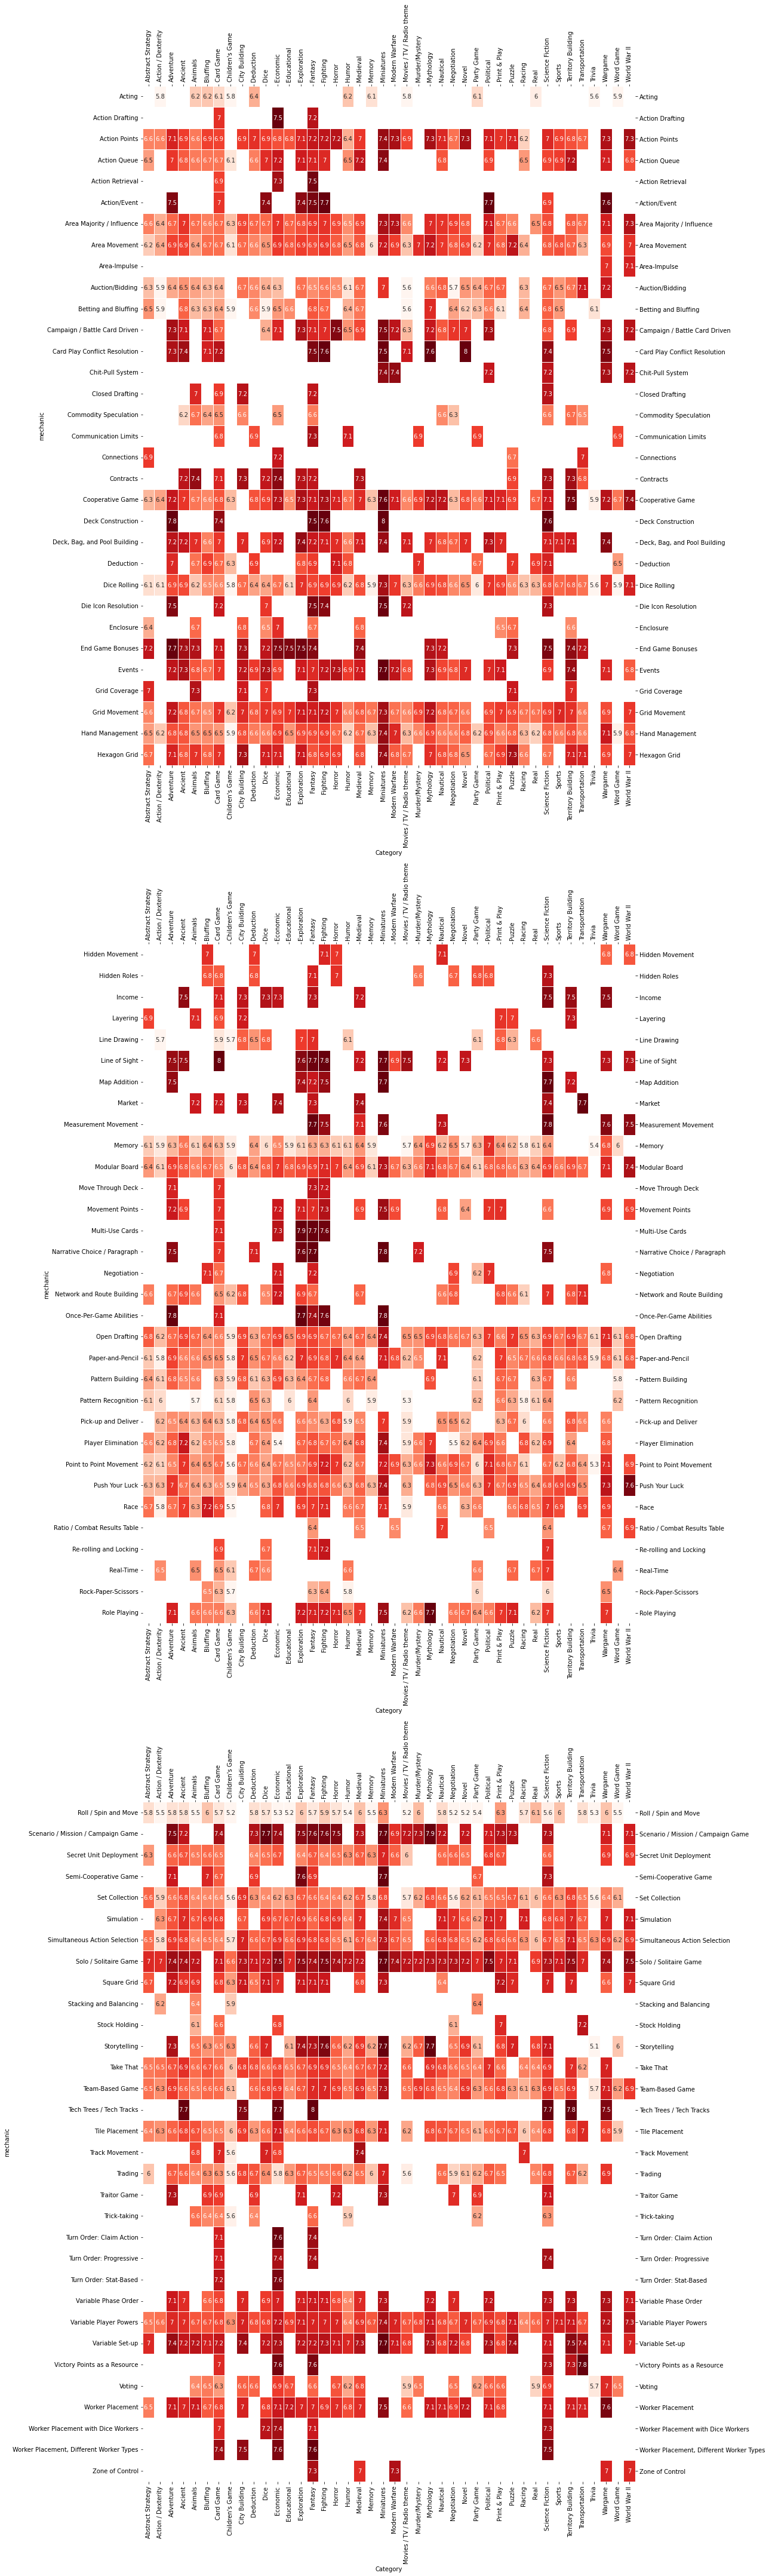

In [60]:
fig, axs = plt.subplots(ncols=1,
                       nrows=3,
                       figsize=(18,60))

for i in range(0,3):
    sns.heatmap(
        ax=axs[i],
        data=mech_cat_rating_pivot.iloc[32*i:32*(i+1)],
        annot=True,
        cbar=False,
        cmap='Reds',
        robust=True,
        linewidth=0.5,
        yticklabels=True
    )

    xtick_labels = [label.get_text().split('-')[1] for label in axs[i].get_xticklabels()]


    axs[i].set_xticklabels(xtick_labels)

    axs[i].tick_params(right=True, top=True, labelright=True, labeltop=True, labelrotation=0)
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].set_xlabel('Category')
    

plt.tight_layout()

* The heatmap reveals that certain mechanics are exclusive to particular categories. For instance, mechanics like `Stacking and Balancing` are only relevant in categories such as party games or children's games, whereas `Variable Player Powers` is nearly universal across all categories. Interestingly, `Tech Trees / Tech Tracks` are limited to a few categories but consistently receive a minimum rating of 7.5 across all those categories.

In [1079]:
#Top mechanic and category pairs

mech_cat_rating_pivot.stack().sort_values('average', ascending=False).head(20)

average
mechanic                           category                          
Scenario / Mission / Campaign Game Mythology                 8.199771
Tech Trees / Tech Tracks           Exploration               8.064117
Card Play Conflict Resolution      Novel-based               8.010958
Tech Trees / Tech Tracks           Fantasy                   7.977217
Role Playing                       Mythology                 7.972822
Multi-Use Cards                    Exploration               7.967315
Tech Trees / Tech Tracks           Fighting                  7.952847
Turn Order: Stat-Based             Industry / Manufacturing  7.945919
Map Addition                       Miniatures                7.936917
Once-Per-Game Abilities            Adventure                 7.931609
Deck Construction                  Adventure                 7.914877
Line of Sight                      Card Game                 7.912577
Once-Per-Game Abilities            Miniatures                7.905265
Narrative Choice / Paragraph       Miniatures                7.881455
Deck Construction                  Miniatures                7.867109
Narrative Choice / Paragraph       Fighting                  7.843758
Victory Points as a Resource       Transportation            7.839066
Hexagon Grid                       Video Game Theme          7.818163
Ownership                          Trains                    7.816821
Card Play Conflict Resolution      Fighting                  7.815588

In [1087]:
#Board games that has the top mechanic and category occurrence

mech_cat_rating[(mech_cat_rating['mechanic'] == 'Scenario / Mission / Campaign Game') & \
                (mech_cat_rating['category'] == 'Mythology')].sort_values('bgg_rank', ascending=True)

bgg_id                               name  bgg_rank  average  \
2736   264220  Tainted Grail: The Fall of Avalon        92  8.10467   
2926   251661       Oathsworn: Into the Deepwood        95  9.07839   
9240   186751           Mythic Battles: Pantheon       438  8.34110   
12529  242705             Aeon Trespass: Odyssey       624  9.10743   
42866  284333               Yggdrasil Chronicles      3147  7.36107   
45955  273814                        Deliverance      3454  8.75147   
52154  317511                            Tindaya      4133  7.30216   
60051  336195              League of Dungeoneers      5024  8.74777   
61183  266064                   Trudvang Legends      5153  7.00388   

       bayes_average  average_weight  users_rated  \
2736         7.55452          3.3458        11760   
2926         7.54052          3.5954         3740   
9240         7.00841          3.0325         3120   
12529        6.84810          4.7321         2116   
42866        5.94663          3.0000          696   
45955        5.89739          3.0303          443   
52154        5.81469          3.9625          564   
60051        5.73644          3.9667          291   
61183        5.72765          2.4800          518   

                                 mechanic   category  
2736   Scenario / Mission / Campaign Game  Mythology  
2926   Scenario / Mission / Campaign Game  Mythology  
9240   Scenario / Mission / Campaign Game  Mythology  
12529  Scenario / Mission / Campaign Game  Mythology  
42866  Scenario / Mission / Campaign Game  Mythology  
45955  Scenario / Mission / Campaign Game  Mythology  
52154  Scenario / Mission / Campaign Game  Mythology  
60051  Scenario / Mission / Campaign Game  Mythology  
61183  Scenario / Mission / Campaign Game  Mythology

* The majority of board games featuring the top mechanic-category pair are complex games, with an average weight rating of 3.5 (ranging from medium to medium-heavy complexity). Notably, *Aeon Trespass: Odyssey* stands out with the highest weight rating (4.73) and the highest overall rating (9.07) among all games in the list. This further emphasizes the notion that highly complex games, often featuring campaign or mission formats, are highly favored by the BGG community.

---

## 9. Conclusion <a id="conclusion"></a>

The following overall insights can be derived from the preceding analysis:

- Over the past two decades, there has been a **remarkable surge in the number of board games**, largely due to the accessibility of *crowdfunding platforms*. These platforms have empowered board game developers to secure funding for their projects more easily.

- The average rating of board games follows a normal distribution pattern, with a mean of 6.5. This indicates a generally **positive sentiment** among the Board Game Geek (BGG) community towards rated board games.

- Geek ratings tend to center around a median value of 5.5. However, a **positive correlation** exists between the average rating and the number of ratings a board game receives. This suggests that as the number of ratings increases, the average rating tends to rise as well.

- User ratings and the number of ownership for board games are primarily concentrated among the top 1000 games. This concentration may serve as a **proxy indicator for the popularity** of board games.

- Board game weight (complexity) and publication year emerge as significant factors contributing to a positive rating. This indicates a preference within the BGG community for **highly complex and recently published games.**

- Mechanics that promote **strategic planning** and **long-term decision-making** are more favored compared to those primarily based on chance or random occurrence.

- There is a growing adoption of **card game** categories, while **war games** are experiencing a decline in popularity.

- **Campaign board games** with mythological thematic narratives are the most prevalent mechanic-category pairs observed in the dataset. This reinforces the idea that complex games, for which campaign board games are known for, are highly rated in the BGG community.

---